# Librerías y paquetes

In [1]:
!pip install rasterio fiona

In [2]:
!pip install pygeodes

In [3]:
!pip install -q geemap earthengine-api

In [4]:
import pandas as pd              # Para analizar datos en formato tabla (tablas (DataFrames)
import numpy as np               # Para calcular y manejar arrays
import matplotlib.pyplot as plt  # Para visualizar datos en gráficas
import ee                        # Para conectar con API a Google Earth Engine para hacer análisis geoespacial
import geemap                    # Para trabajar con GEE con herramientas y mapas interactivos
import geopandas as gpd          # Para trabajar en pandas con datos geoespaciales
import random                    # Para generar o seleccionar datos aleatoriamente
from datetime import datetime    # Para el tratamiento de fechas y horas
from datetime import timedelta   # Para sumar o restar fechas
import shapely
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import transform as shp_transform
import shapely.ops as sops
from shapely.geometry import mapping  # Para convertir geometrías a diccionarios de tipo GeoJSON
import rasterio                  # Para leer, escribir y analizar datos ráster
from rasterio.mask import mask   # Para recortar datos ráster con máscaras geométricas
from rasterio.transform import Affine  # Para transformaciones de coordenadas
from pyproj import Transformer   # Para la transofrmación de coordenadas
import fiona                     # Para manejar archivos vectoriales geoespaciales (shapefiles, GeoPackage, etc.)
import os                        # Para interactuar con el sistema operativo
from tqdm import tqdm            # Para visualización del proceso de cálculo
from affine import Affine        # Para transformaciones
import math                      # Para operaciones matemáticas
from pathlib import Path         # Para trabajar con rutas de archivos
import re                        # Para trabajar con expresiones regulares
from IPython.display import display # Para mejorar la visualización en el notebook
from rasterio.warp import reproject, Resampling, transform_bounds
from rasterio.crs import CRS
from rasterio.features import rasterize
import json
from shapely.geometry import mapping



# Montaje de Google drive y autentificación e inicialización de Google Earth Engine

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
ee.Authenticate()
# Utilizo mi cuenta personal de gmail y el proyecto imaglandsat
ee.Initialize(project='imaglandsat')

# Definición periodo de estudio y geometría (Shapefile) de Andorra a formato GEE

In [7]:
# Periodo de estudio

inicio = '2000-10-01'
fin = '2025-07-01'


# Geometría de Andorra desde el Shapefile
# (reproyección + reparación + conversión a EE)

shp_path = '/content/drive/MyDrive/TFM/Frontera_Andorra/Frontera_Andorra.shp'
assert os.path.exists(shp_path), f"No se encontró el shapefile en: {shp_path}"

# WKT (Well-Known Text) de la proyección original del shapefile
NTF_Lambert_Sud_WKT = (
    'PROJCS["NTF_Paris_Lambert_Sud_France",'
    'GEOGCS["GCS_NTF_Paris",DATUM["D_NTF",SPHEROID["Clarke_1880_IGN",6378249.2,293.46602]],'
    'PRIMEM["Paris",2.33722917],UNIT["grad",0.01570796326794897]],'
    'PROJECTION["Lambert_Conformal_Conic"],'
    'PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",0],'
    'PARAMETER["scale_factor",0.999877499],PARAMETER["false_easting",600000],'
    'PARAMETER["false_northing",200000],UNIT["Meter",1],PARAMETER["standard_parallel_1",49]]'
)

# Leo el shapefile
gdf = gpd.read_file(shp_path)

# Aseguro el crs correcto y reproyecto a WGS84
if gdf.crs is None:
    gdf = gdf.set_crs(NTF_Lambert_Sud_WKT)
gdf = gdf.to_crs(epsg=4326)

# Repara geometrías del shapefile (make_valid + buffer(0) y elimino las vacías
def fix_geom(g):
    try:
        g = shapely.make_valid(g)
    except Exception:
        pass
    try:
        g = g.buffer(0)
    except Exception:
        pass
    return g

gdf["geometry"] = gdf["geometry"].apply(fix_geom)
gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.is_valid].copy()

# Uno geometrías quedándome con un Polgígono/Multipolígono
geom = gdf.unary_union
if geom.geom_type == "GeometryCollection":
    geoms = [gi for gi in geom.geoms if gi.is_valid and not gi.is_empty and gi.geom_type in ("Polygon","MultiPolygon")]
    geom = sops.unary_union(geoms)

# Fuerzo que sea un polígono 2D y hago un MultiPolygon para EE
geom_2d = shp_transform(lambda x, y, z=None: (x, y), geom)

def ring_to_xy(ring):
    coords = [[float(c[0]), float(c[1])] for c in list(ring.coords)]
    if coords[0] != coords[-1]:
        coords.append(coords[0])
    return coords

def poly_to_coords(p: Polygon):
    ext = ring_to_xy(p.exterior)
    holes = []
    for hole in p.interiors:
        if len(hole.coords) >= 4:
            holes.append(ring_to_xy(hole))
    return [ext] + holes

def shapely_to_ee_multipolygon(g):
    if isinstance(g, Polygon):
        polys = [g]
    elif isinstance(g, MultiPolygon):
        polys = list(g.geoms)
    else:
        raise ValueError(f"Geometría no soportada: {g.geom_type}")
    ee_polys = []
    for p in polys:
        if (not p.is_empty) and p.is_valid:
            ee_polys.append(poly_to_coords(p))
    if not ee_polys:
        raise ValueError("No hay polígonos válidos tras la reparación.")
    return ee.Geometry.MultiPolygon(ee_polys, proj='EPSG:4326', geodesic=True)

try:
    andorra_geom = shapely_to_ee_multipolygon(geom_2d)
except Exception:
    try:
        andorra_geom = shapely_to_ee_multipolygon(geom_2d.simplify(1e-6, preserve_topology=True))
    except Exception:
        andorra_geom = shapely_to_ee_multipolygon(geom_2d.simplify(1e-5, preserve_topology=True))

# “Limpieza” de la geometría con maxError > 0
andorra_geom = andorra_geom.buffer(0, 100)  # 100 m de tolerancia

# Objetos finales válidos para el uso con GEE
andorra_fc = ee.FeatureCollection(ee.Feature(andorra_geom))
andorra    = andorra_fc.geometry()


/tmp/ipython-input-2295252644.py:48: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = gdf.unary_union


# Cálculo de distintos índices espectrales

### Imagen utilizada para las pruebas (sin nubes)

In [8]:
# Imagen satelital utilizada para las pruebas (sin nubes)

img_id = 'COPERNICUS/S2_SR_HARMONIZED/20230107T104329_20230107T104329_T31TCH'
satelite = 'SENTINEL_2'

fecha = '20230107'
nombre_base = f"{fecha}_{satelite}"

print("Imagen seleccionada:")
print(f"ID:        {img_id}")
print(f"Satélite:  {satelite}")
print(f"Fecha:     {fecha}")

Imagen seleccionada:
ID:        COPERNICUS/S2_SR_HARMONIZED/20230107T104329_20230107T104329_T31TCH
Satélite:  SENTINEL_2
Fecha:     20230107


### Carga de la imagen

In [9]:
# Sentinel-2: carga + escalado (sin máscaras)
S2_SCALE = 10000
scale = 10

img_raw = ee.Image(img_id)
img = img_raw.divide(S2_SCALE)   # reflectancia escalada

# Bandas utilizadas
blue, green, red, nir, swir1, swir2 = 'B2', 'B3', 'B4', 'B8', 'B11', 'B12'
rgb_bands = [red, green, blue]

# Índices
ndsi = img.normalizedDifference([green, swir1]).rename('NDSI')
ndvi = img.normalizedDifference([nir,   red  ]).rename('NDVI')
ndwi = img.normalizedDifference([green, nir  ]).rename('NDWI')

# RGB (color natural, con reflectancia ya escalada)
rgb_raw = img.select(rgb_bands)

# Bandas escaladas
blue_s, green_s, red_s, nir_s, swir1_s, swir2_s = (
    img.select(blue), img.select(green), img.select(red),
    img.select(nir),  img.select(swir1), img.select(swir2)
)

# Reflectancias para otros cálculos
refl = img.select([nir, red, swir1]).rename(['NIR', 'RED', 'SWIR'])



###Cálculo de índices

In [10]:
# Cálculo de índices para la imagen sin nubes

EPS = 1e-6

# NDSI binarios con distintos umbrales de detección nieve/no nieve

ndsi_thresholds = [0.40, 0.25, 0.15, 0.10, 0.00]

ndsi_bins = ee.Image.cat([
    ndsi.gte(t).rename(f'NDSI_ge_{t:.2f}'.replace('.', '_'))
    for t in ndsi_thresholds
])

ndsi_ge_0_40 = ndsi_bins.select('NDSI_ge_0_40')
ndsi_ge_0_25 = ndsi_bins.select('NDSI_ge_0_25')
ndsi_ge_0_15 = ndsi_bins.select('NDSI_ge_0_15')
ndsi_ge_0_10 = ndsi_bins.select('NDSI_ge_0_10')
ndsi_ge_0_00 = ndsi_bins.select('NDSI_ge_0_00')


# Combinación NDSI–NDVI
ndvi_lt_010 = ndvi.lt(0.10)

indice_ndsi_ndvi_040 = ndsi.gte(0.40).And(ndvi_lt_010).rename('Indice_NDSI_NDVI_040')
indice_ndsi_ndvi_015 = ndsi.gte(0.15).And(ndvi_lt_010).rename('Indice_NDSI_NDVI_015')


# S3 continuo y binarios con distintos umbrales
nir  = refl.select('NIR')
red  = refl.select('RED')
swir = refl.select('SWIR')

s3 = nir.multiply(red.subtract(swir)) \
        .divide(nir.add(red).multiply(nir.add(swir)).add(EPS)) \
        .rename('S3')

s3_thresholds = [0.05, 0.00, -0.05, -0.10, -0.15]
s3_bins = ee.Image.cat([
    s3.gt(t).rename(f'S3_gt_{t:+.2f}'.replace('+', 'p').replace('-', 'm').replace('.', '_'))
    for t in s3_thresholds
])

# S3 de base
s3_bin = s3.gt(0.05).rename('S3_gt_0_05')


# NBSI-MS según documentación oficial del índice y distintos umbrales
k = 0.36
nbsi_ms_oficial = (
    (green_s.add(red_s).add(nir_s)).multiply(k)
    .subtract(blue_s.add(swir2_s).divide(green_s.add(EPS)).add(swir1_s))
    .rename('NBSI_MS_oficial')
)

nbsi_thresholds = [-2.0, -1.75, -1.5, -1.25]
nbsi_bins = ee.Image.cat([
    nbsi_ms_oficial.gt(t).rename(f'NBSI_MS_of_gt_{t:+.2f}'.replace('+', 'p').replace('-', 'm').replace('.', '_'))
    for t in nbsi_thresholds
])

# FSC por SCAmod con parámetros ajustados
rho_obs = green_s

rho_snow_val, rho_ground_val, rho_forest_val = 0.60, 0.20, 0.05
t2_val = 0.35
fsc_bin_threshold = 0.10

rho_snow   = ee.Image.constant(rho_snow_val)
rho_ground = ee.Image.constant(rho_ground_val)
rho_forest = ee.Image.constant(rho_forest_val)

inv_t2 = ee.Image.constant(1.0 / t2_val)

num = inv_t2.multiply(rho_obs) \
    .add(ee.Image.constant(1).subtract(inv_t2).multiply(rho_forest)) \
    .subtract(rho_ground)

den = rho_snow.subtract(rho_ground).add(EPS)

fsc_scmod     = num.divide(den).max(0).min(1).rename('FSC_SCAmod')
fsc_scmod_pct = fsc_scmod.multiply(100).rename('FSC_SCAmod_pct')
fsc_scmod_bin = fsc_scmod.gt(fsc_bin_threshold).rename('FSC_SCAmod_bin')




### Cálculo de % cubierto de nieve sobre Andorra en la imágen según distintos índices

In [11]:
# Creación dela tabla del % cubierto de nieve sobre Andorra en la imagen según distintos ínidces

# Definición de los parámetros genéricos de reducción
MAX_PIX   = 1e10
TILESCALE = 2
area_img = ee.Image.pixelArea()

total_km2 = ee.Number(
    area_img.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=andorra,
        scale=scale,
        maxPixels=MAX_PIX,
        tileScale=TILESCALE
    ).get('area')
).divide(1e6)

def pct_area(mask_img):
    snow_km2 = ee.Number(
        area_img.updateMask(mask_img).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=andorra,
            scale=scale,
            maxPixels=MAX_PIX,
            tileScale=TILESCALE
        ).get('area')
    ).divide(1e6)
    return snow_km2.divide(total_km2).multiply(100)


# Definición de las máscaras a evaluar de los índices calculados
masks = {
    # NDSI
    'NDSI ≥ 0.40 (%)': ndsi_bins.select('NDSI_ge_0_40'),
    'NDSI ≥ 0.25 (%)': ndsi_bins.select('NDSI_ge_0_25'),
    'NDSI ≥ 0.15 (%)': ndsi_bins.select('NDSI_ge_0_15'),
    'NDSI ≥ 0.10 (%)': ndsi_bins.select('NDSI_ge_0_10'),
    'NDSI ≥ 0.00 (%)': ndsi_bins.select('NDSI_ge_0_00'),

    # NDSI–NDVI
    'NDSI-NDVI (NDSI≥0.40 & NDVI<0.10) (%)': indice_ndsi_ndvi_040,
    'NDSI-NDVI (NDSI≥0.15 & NDVI<0.10) (%)': indice_ndsi_ndvi_015,

    # NBSI-MS oficial
    'NBSI-MS oficial > -2.00 (%)':  nbsi_bins.select('NBSI_MS_of_gt_m2_00'),
    'NBSI-MS oficial > -1.75 (%)':  nbsi_bins.select('NBSI_MS_of_gt_m1_75'),
    'NBSI-MS oficial > -1.50 (%)':  nbsi_bins.select('NBSI_MS_of_gt_m1_50'),
    'NBSI-MS oficial > -1.25 (%)':  nbsi_bins.select('NBSI_MS_of_gt_m1_25'),

    # S3
    'S3 > 0.05 (%)':  s3_bins.select('S3_gt_p0_05'),
    'S3 > 0.00 (%)':  s3_bins.select('S3_gt_p0_00'),
    'S3 > -0.05 (%)': s3_bins.select('S3_gt_m0_05'),
    'S3 > -0.10 (%)': s3_bins.select('S3_gt_m0_10'),
    'S3 > -0.15 (%)': s3_bins.select('S3_gt_m0_15'),

    # FSC
    f'FSC SCAmod > {int(fsc_bin_threshold*100)}% (%)': fsc_scmod_bin,
}

# Cálculo de resultados
results = {
    name: pct_area(mask).format('%.1f').getInfo()
    for name, mask in masks.items()
}

df = pd.DataFrame([results])
print("\n% de área cubierta por nieve en Andorra según distintos índices para la imagen de prueba:")
print(df.to_string(index=False))





% de área cubierta por nieve en Andorra según distintos índices para la imagen de prueba:
NDSI ≥ 0.40 (%) NDSI ≥ 0.25 (%) NDSI ≥ 0.15 (%) NDSI ≥ 0.10 (%) NDSI ≥ 0.00 (%) NDSI-NDVI (NDSI≥0.40 & NDVI<0.10) (%) NDSI-NDVI (NDSI≥0.15 & NDVI<0.10) (%) NBSI-MS oficial > -2.00 (%) NBSI-MS oficial > -1.75 (%) NBSI-MS oficial > -1.50 (%) NBSI-MS oficial > -1.25 (%) S3 > 0.05 (%) S3 > 0.00 (%) S3 > -0.05 (%) S3 > -0.10 (%) S3 > -0.15 (%) FSC SCAmod > 10% (%)
           40.0            42.9            44.8            45.7            47.8                                  33.5                                  34.6                        56.0                        50.1                        44.5                        37.8          43.4          45.6           48.6           52.9           60.4                 42.9


## Visualización de los índices en um mapa

In [12]:
import geemap
import ee

Map = geemap.Map()
Map.centerObject(andorra, 10)

# Para hacer clip del límite de Andorra
clip = lambda img: img.clip(andorra)

# Capa de la frontera de Andorra

boundary = ee.Image().paint(andorra, 1, 2)
Map.addLayer(boundary, {'palette': ['yellow']}, 'Límite Andorra')


# Capa de la Ortofoto RGB

Map.addLayer(clip(rgb_raw), {'min': 0, 'max': 0.3}, 'Ortofoto RGB')

# Capas de los índices contínuos NDSI, S3m NBSI-MS y FSC
continuous_layers = [
    ('NDSI', ndsi, {'min': -1, 'max': 1, 'palette': ['blue', 'white']}),
    ('S3', s3, {'min': -1, 'max': 1, 'palette': ['#543005', '#3288bd', '#f7f7f7']}),
    ('NBSI-MS oficial', nbsi_ms_oficial, {'min': -3, 'max': 1, 'palette': ['#543005', '#3288bd', '#f7f7f7']}),
    ('FSC SCAmod (%)', fsc_scmod_pct, {'min': 0, 'max': 100, 'palette': ['#101010', '#3a7', '#ade', '#fff']}),
]
for name, img, viz in continuous_layers:
    Map.addLayer(clip(img), viz, name)

# Capas de los índices binarios

binary_layers = []

# NDSI binarios
ndsi_thresholds = [0.40, 0.25, 0.15, 0.10, 0.00]
ndsi_colors     = ['#00FFFF', '#0099FF', '#0066FF', '#0033FF', '#0011AA']
for t, col in zip(ndsi_thresholds, ndsi_colors):
    band = f"NDSI_ge_{t:.2f}".replace('.', '_')
    binary_layers.append((f'NDSI ≥ {t:.2f}', ndsi_bins.select(band), {'palette': [col]}))

# NDSI–NDVI binarios
binary_layers += [
    ('NDSI-NDVI (≥0.40 & NDVI<0.10)', indice_ndsi_ndvi_040, {'palette': ['#00B5FF']}),
    ('NDSI-NDVI (≥0.15 & NDVI<0.10)', indice_ndsi_ndvi_015, {'palette': ['#00FFB5']}),
]

# NBSI binarios
nbsi_thresholds = [-2.00, -1.75, -1.50, -1.25]
nbsi_colors     = ['#FFCCEE', '#FF99DD', '#FF66CC', '#FF33BB']
for t, col in zip(nbsi_thresholds, nbsi_colors):
    band = f"NBSI_MS_of_gt_{t:+.2f}".replace('+','p').replace('-','m').replace('.', '_')
    binary_layers.append((f'NBSI-MS oficial > {t:g}', nbsi_bins.select(band), {'palette': [col]}))

# S3 binarios
s3_thresholds = [0.05, 0.00, -0.05, -0.10, -0.15]
s3_colors     = ['#FFA500', '#FFCC66', '#FFDD99', '#FFEEBB', '#FFF2DD']
for t, col in zip(s3_thresholds, s3_colors):
    band = f"S3_gt_{t:+.2f}".replace('+','p').replace('-','m').replace('.', '_')
    binary_layers.append((f'S3 > {t:g}', s3_bins.select(band), {'palette': [col]}))

# FSC binario
binary_layers.append(
    (f'FSC SCAmod > {int(fsc_bin_threshold*100)}%', fsc_scmod_bin, {'palette': ['#FFEE00']})
)

# Añado todas las capaas de binarios
for name, img, viz in binary_layers:
    Map.addLayer(clip(img).selfMask(), viz, f'{name} (binario)')

# Muestro el mapa
Map.addLayerControl()

Map


Map(center=[42.54523931775899, 1.5758745039384787], controls=(WidgetControl(options=['position', 'transparent_…

## Exportación ortofoto utilizada para el análisis

In [ ]:
task = ee.batch.Export.image.toDrive(
    image = rgb_raw.clip(andorra),
    description = 'Ortofoto_20230107',
    folder = 'TFM',
    fileNamePrefix = 'Ortofoto_20230107',
    scale = 10,
    region = andorra,
    fileFormat = 'GeoTIFF',
    maxPixels = 1e13
)

task.start()

## Ínidice de nieve con Deep Learning SonwCoverage

### Preparación del modelo (instalación de librerías), activación previa de GPU

In [ ]:
!pip install -q rasterio fiona einops segmentation-models-pytorch
!pip install -q geemap earthengine-api


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.7 MB/s eta 0:00:00


In [ ]:
import torch
print("CUDA disponible?:", torch.cuda.is_available())
print("Dispositivo por defecto:", torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


CUDA disponible?: True
Dispositivo por defecto: cuda


### Descarga del modelo Snowcoverage de Github

In [ ]:
%cd /content
!rm -rf SnowCoverage
!git clone https://github.com/yiluyucheng/SnowCoverage.git
%cd SnowCoverage

!ls -lh


/content
Cloning into 'SnowCoverage'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 150 (delta 11), reused 18 (delta 6), pack-reused 124 (from 1)
Receiving objects: 100% (150/150), 1.17 GiB | 30.37 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Updating files: 100% (91/91), done.
/content/SnowCoverage
total 4.3M
drwxr-xr-x 4 root root 4.0K Dec 20 16:22 datasets
-rw-r--r-- 1 root root 5.0K Dec 20 16:22 make_prediction.py
drwxr-xr-x 2 root root 4.0K Dec 20 16:22 models
-rw-r--r-- 1 root root 1.8K Dec 20 16:22 README.md
-rw-r--r-- 1 root root 4.3M Dec 20 16:22 Ref_Paper.pdf
-rw-r--r-- 1 root root   88 Dec 20 16:22 requirements.txt
drwxr-xr-x 2 root root 4.0K Dec 20 16:22 test_data
-rw-r--r-- 1 root root 3.5K Dec 20 16:22 u_net.py


In [ ]:
!cp /content/drive/MyDrive/TFM/unet_4bands.pth ./models/unet_4bands.pth
!ls -lh models

total 237M
-rw-r--r-- 1 root root 237M Dec 20 16:23 unet_4bands.pth


### Parche del modelo U-Net, se debe usar el archivo make_prediction.py modificado que se adjunta

In [ ]:
import textwrap

path = Path("make_prediction.py")
texto = path.read_text()

# Remplazo el bloque donde se cargaba el modelo ya que daba error
bloque_nuevo = textwrap.dedent("""
    # ================== Carga del modelo U-Net (parcheada) ==================
    import torch
    # Miro si uso GPU o CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Usando dispositivo:", device)

    # Cargo el archivo unet_4bands.pth, permitiendo objetos completos (weights_only=False)
    state = torch.load("./models/unet_4bands.pth",
                       map_location=device,
                       weights_only=False)

    # Algunos checkpoints guardan solo el state_dict, otros el modelo entero
    try:
        net.load_state_dict(state)
        print("Checkpoint interpretado como state_dict.")
    except Exception:
        net = state
        print("Checkpoint interpretado como modelo completo.")
    # Paso el modelo al dispositivo y lo pongo en modo evaluación
    net.to(device)
    net.eval()
    # ===============================================================
""").strip("\n")

# Localizo la parte original donde se cargaba el modelo.
# Aparecen estas líneas:
#   net.load_state_dict(torch.load("./models/unet_4bands.pth"))
#   net = torch.load("./models/unet_4bands.pth")
old_1 = '    net.load_state_dict(torch.load("./models/unet_4bands.pth"))'
old_2 = '    net = torch.load("./models/unet_4bands.pth")'
# Si encuentro esas líneas, edita el archivo
if old_1 in texto or old_2 in texto:
    # Elimino ambas líneas y pego el bloque nuevo
    texto = texto.replace(old_1, "")
    texto = texto.replace(old_2, bloque_nuevo)
    path.write_text(texto)
    print("make_prediction.py parcheado correctamente.")
else:
    print("No se encontraron las líneas esperadas")


No se encontraron las líneas esperadas


### Predicción sobre la imagen de prueba
Importante: se debe sustituir el archivo make_prediction.py que proviene de Github por el modificado y facilitado

In [ ]:
%cd /content/SnowCoverage

input_tif = '/content/drive/MyDrive/TFM/S2_12bands_Andorra_20230107.tif'
output_pdf = '/content/drive/MyDrive/TFM/Andorra_SnowCoverage_20230107.pdf'

!python make_prediction.py "$input_tif" "$output_pdf"


/content/SnowCoverage
Usando dispositivo: cuda:0
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

✔ TIFF georreferenciado guardado en:
/content/drive/MyDrive/TFM/Andorra_SnowCoverage_20230107.tif


In [ ]:
!pip install localtileserver # Para renderizar el raster

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.0/277.0 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: pystac
    Found existing installation: pystac 1.8.0
    Uninstalling pystac-1.8.0:
      Successfully uninstalled pystac-1.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pygeodes 0.1.5 requires pystac==1.8.0, but you have pystac 1.14.2 which is incompatible.


In [ ]:
# Visualización en el mapa

Map = geemap.Map()
Map.centerObject(andorra, 10)

# 1. Capa de la frontera
boundary = ee.Image().paint(andorra, 1, 2)
Map.addLayer(boundary, {'palette': ['yellow']}, 'Límite Andorra')

# 2. Imagen color natural
Map.addLayer(
    rgb_raw.clip(andorra),
    {'min': 0, 'max': 0.3},
    'Color natural'
)

# 3. Imagen resultante de Deep Learning SnowCoverage (GeoTIFF en Drive)
snowcov_tif = '/content/drive/MyDrive/TFM/Andorra_SnowCoverage_20230107.tif'
Map.add_raster(
    source=snowcov_tif,
    band=1,
    vmin=0,
    vmax=2,
    layer_name='SnowCoverage DL'
)

# 4. Control de capas estándar
Map.addLayerControl()

Map

Map(center=[42.54523931775899, 1.5758745039384787], controls=(WidgetControl(options=['position', 'transparent_…

# Obtención del Listado de satélites que cubren todo Andorra

In [ ]:
# Función para verificar cobertura completa de Andorra por los satélites
def cubre_andorra_completa(img):
    try:
        return img.geometry().contains(andorra, maxError=1)
    except Exception as e:
        print(f"Error al verificar cobertura de {img.id().getInfo()}: {e}")
        return ee.Boolean(False)

In [ ]:
# Conecto con las colecciones de datos satelitales disponibles en Google Earth Engine

# Landsat (5, 7, 8 y 9) TOA
coleccion_landsat = (
    ee.ImageCollection('LANDSAT/LT05/C02/T1_TOA')
    .merge(ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA'))
    .merge(ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA'))
    .merge(ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA'))
    .filterBounds(andorra) # Para Andorra
    .filterDate(inicio, fin) # Fechas de inicio y fin de datos
    .map(lambda img: img.set('cubre_andorra', cubre_andorra_completa(img))) # Cubre Andorra completo
    .filter(ee.Filter.eq('cubre_andorra', True))
)

# Extraigo los metadatos de Landsat
def extraer_info_landsat(img):
    return ee.Feature(None, {
        'INDEX_ID': img.get('system:index'),
        'ID': img.id(),
        'Fecha': img.date().format('YYYY-MM-dd'),
        'Satelite': img.get('SPACECRAFT_ID'),
        'Sensor': img.get('SENSOR_ID'),
        'WRS_PATH': img.get('WRS_PATH'),
        'WRS_ROW': img.get('WRS_ROW'),
        'CLOUD_COVER': img.get('CLOUD_COVER'),
        'SUN_ELEVATION': img.get('SUN_ELEVATION'),
        'SUN_AZIMUTH': img.get('SUN_AZIMUTH'),
        'EARTH_SUN_DISTANCE': img.get('EARTH_SUN_DISTANCE'),
        'IMAGE_QUALITY_TIER': img.get('IMAGE_QUALITY_TIER')
    })

features_landsat = coleccion_landsat.map(extraer_info_landsat).getInfo()['features']
datos_landsat = [f['properties'] for f in features_landsat]
df_landsat = pd.DataFrame(datos_landsat)

# Limpio INDEX_ID de los datos Landsat
df_landsat['INDEX_ID'] = df_landsat['INDEX_ID'].str.extract(
    r'(L[CET]\d{2}_\d{6}_\d{8})'
)[0]

# Construyo el ID completo para el satélite de Landsat
def construir_id_completo(row):
    index = row['INDEX_ID']

    if isinstance(index, str):
        if row['Satelite'] == 'LANDSAT_8':
            return f'LANDSAT/LC08/C02/T1_TOA/{index}'
        elif row['Satelite'] == 'LANDSAT_9':
            return f'LANDSAT/LC09/C02/T1_TOA/{index}'
        elif row['Satelite'] == 'LANDSAT_7':
            return f'LANDSAT/LE07/C02/T1_TOA/{index}'
        elif row['Satelite'] == 'LANDSAT_5':
            return f'LANDSAT/LT05/C02/T1_TOA/{index}'

    return None

df_landsat.insert(1, 'ID_completo', df_landsat.apply(construir_id_completo, axis=1))

df_landsat['Fecha'] = pd.to_datetime(df_landsat['Fecha'], errors='coerce')

for col in ['CLOUD_COVER', 'SUN_ELEVATION', 'SUN_AZIMUTH', 'EARTH_SUN_DISTANCE']:
    df_landsat[col] = pd.to_numeric(df_landsat[col], errors='coerce')

# Sentinel-2
coleccion_sentinel = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(andorra)
    .filterDate(inicio, fin)
    .map(lambda img: img.set('cubre_andorra', cubre_andorra_completa(img)))
    .filter(ee.Filter.eq('cubre_andorra', True))
)

# Extraigo los metadatos Sentinel-2
def extraer_info_sentinel(img):
    # Elevación = 90 - ángulo cenital medio
    sun_elevation = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_ZENITH_ANGLE')))
    return ee.Feature(None, {
        'INDEX_ID': img.get('system:index'),
        'ID': img.id(),
        'Fecha': img.date().format('YYYY-MM-dd'),
        'Satelite': 'SENTINEL_2',
        'Sensor': img.get('SENSOR_OPERATING_MODE'),
        'WRS_PATH': None,
        'WRS_ROW': None,
        'CLOUD_COVER': img.get('CLOUDY_PIXEL_PERCENTAGE'),
        'SUN_ELEVATION': sun_elevation,
        'SUN_AZIMUTH': img.get('MEAN_SOLAR_AZIMUTH_ANGLE'),
        'EARTH_SUN_DISTANCE': None,
        'IMAGE_QUALITY_TIER': None
    })

features_sentinel = coleccion_sentinel.map(extraer_info_sentinel).getInfo()['features']
datos_sentinel = [f['properties'] for f in features_sentinel]
df_sentinel = pd.DataFrame(datos_sentinel)

# ID completo para Sentinel-2
df_sentinel['ID_completo'] = df_sentinel['INDEX_ID'].apply(
    lambda x: f'COPERNICUS/S2_SR_HARMONIZED/{x}' if isinstance(x, str) else None
)

# Convierto tipos de datos a fecha y alineo columnas con Landsat
df_sentinel['Fecha'] = pd.to_datetime(df_sentinel['Fecha'], errors='coerce')
for col in ['CLOUD_COVER', 'SUN_ELEVATION', 'SUN_AZIMUTH']:
    df_sentinel[col] = pd.to_numeric(df_sentinel[col], errors='coerce')
df_sentinel = df_sentinel.reindex(columns=df_landsat.columns)

# Hago la Unión de tablas de Landsat + Sentinel
df = pd.concat([df_landsat, df_sentinel], ignore_index=True)
df = df.sort_values('Fecha').reset_index(drop=True)

# Imprimo los Resultados
print(df.head())
print("\nTotal de imágenes que cubren completamente Andorra:", len(df))

   CLOUD_COVER                                   ID_completo  \
0         18.0  LANDSAT/LE07/C02/T1_TOA/LE07_198030_20001004   
1         81.0  LANDSAT/LE07/C02/T1_TOA/LE07_198030_20001020   
2         77.0  LANDSAT/LE07/C02/T1_TOA/LE07_198030_20001105   
3         36.0  LANDSAT/LE07/C02/T1_TOA/LE07_198030_20001121   
4         53.0  LANDSAT/LT05/C02/T1_TOA/LT05_198030_20001215   

   EARTH_SUN_DISTANCE      Fecha                          ID  \
0            1.000147 2000-10-04  1_1_2_LE07_198030_20001004   
1            0.995591 2000-10-20  1_1_2_LE07_198030_20001020   
2            0.991351 2000-11-05  1_1_2_LE07_198030_20001105   
3            0.987758 2000-11-21  1_1_2_LE07_198030_20001121   
4            0.984191 2000-12-15  1_1_1_LT05_198030_20001215   

  IMAGE_QUALITY_TIER              INDEX_ID  SUN_AZIMUTH  SUN_ELEVATION  \
0               None  LE07_198030_20001004   155.443668      39.324318   
1               None  LE07_198030_20001020   158.762903      33.889154   
2       

# Filtrado del listado de satélites

## Filtro el dataframe por meses del año con nive (octubre a junio), ambos meses incluidos

In [ ]:
# Filtro el dataframe por los meses con presencia de nieve (ocutbre a junio)
df_meses_nieve = df[
    (df['Fecha'].dt.month >= 10) | (df['Fecha'].dt.month <= 6)
].copy()

## Filtro el dataframe para eliminar las imágenes que presentan fallos en el sensor de Landsat 7 (a partir de 2003-05-31)

In [ ]:
# Creo la variable con la fecha del fallo del SLC en Landsat 7
fecha_fallo_slc = pd.Timestamp('2003-05-31')

# Creo el DataFrame filtrado considerando el fallo del sensor de Landsat 7
df_meses_nieve_Landsat7_2003 = df_meses_nieve[
    ~((df_meses_nieve['Satelite'] == 'LANDSAT_7') & (df_meses_nieve['Fecha'] >= fecha_fallo_slc))
].reset_index(drop=True)


# Exportación del dataframe a Google Drive en formato csv

In [ ]:
# Ruta de salida
ruta_salida = '/content/drive/MyDrive/TFM/Andorra_Sentinel_Landsat_Invierno.csv'

# Guardo el dataframe a formato CSV
df_meses_nieve_Landsat7_2003.to_csv(ruta_salida, index=False)
print(f"Archivo guardado en: {ruta_salida}")

Archivo guardado en: /content/drive/MyDrive/TFM/Andorra_Sentinel_Landsat_Invierno.csv


# Importación  el dataframe preprocesado y estadísticas y gráfico

## Importación y estadísticas generales

In [ ]:
csv_path = '/content/drive/MyDrive/TFM/Andorra_Sentinel_Landsat_Invierno.csv'
df_Andorra_Sentinel_Landsat_Invierno_csv = pd.read_csv(csv_path)

# Muestro las estadísticas principales del dataset de imágenes satelitales disponibles
print("Forma del DataFrame (Andorra_Sentinel_Landsat_Invierno):", df_Andorra_Sentinel_Landsat_Invierno_csv.shape)
print("\nColumnas:", df_Andorra_Sentinel_Landsat_Invierno_csv.columns.tolist())
print("\nTipos de datos:")
print(df_Andorra_Sentinel_Landsat_Invierno_csv.dtypes)
print("\nValores nulos por columna:")
print(df_Andorra_Sentinel_Landsat_Invierno_csv.isnull().sum())
print("\nResumen estadístico:")
print(df_Andorra_Sentinel_Landsat_Invierno_csv.describe())
print("\nNúmero de imágenes por satélite:")
print(df_Andorra_Sentinel_Landsat_Invierno_csv['Satelite'].value_counts())

Forma del DataFrame (Andorra_Sentinel_Landsat_Invierno): (1283, 13)

Columnas: ['CLOUD_COVER', 'ID_completo', 'EARTH_SUN_DISTANCE', 'Fecha', 'ID', 'IMAGE_QUALITY_TIER', 'INDEX_ID', 'SUN_AZIMUTH', 'SUN_ELEVATION', 'Satelite', 'Sensor', 'WRS_PATH', 'WRS_ROW']

Tipos de datos:
CLOUD_COVER           float64
ID_completo            object
EARTH_SUN_DISTANCE    float64
Fecha                  object
ID                     object
IMAGE_QUALITY_TIER    float64
INDEX_ID               object
SUN_AZIMUTH           float64
SUN_ELEVATION         float64
Satelite               object
Sensor                 object
WRS_PATH              float64
WRS_ROW               float64
dtype: object

Valores nulos por columna:
CLOUD_COVER              0
ID_completo              0
EARTH_SUN_DISTANCE     883
Fecha                    0
ID                       0
IMAGE_QUALITY_TIER    1283
INDEX_ID                 0
SUN_AZIMUTH              0
SUN_ELEVATION            0
Satelite                 0
Sensor                 

## Gráfico del número satélites disponibles

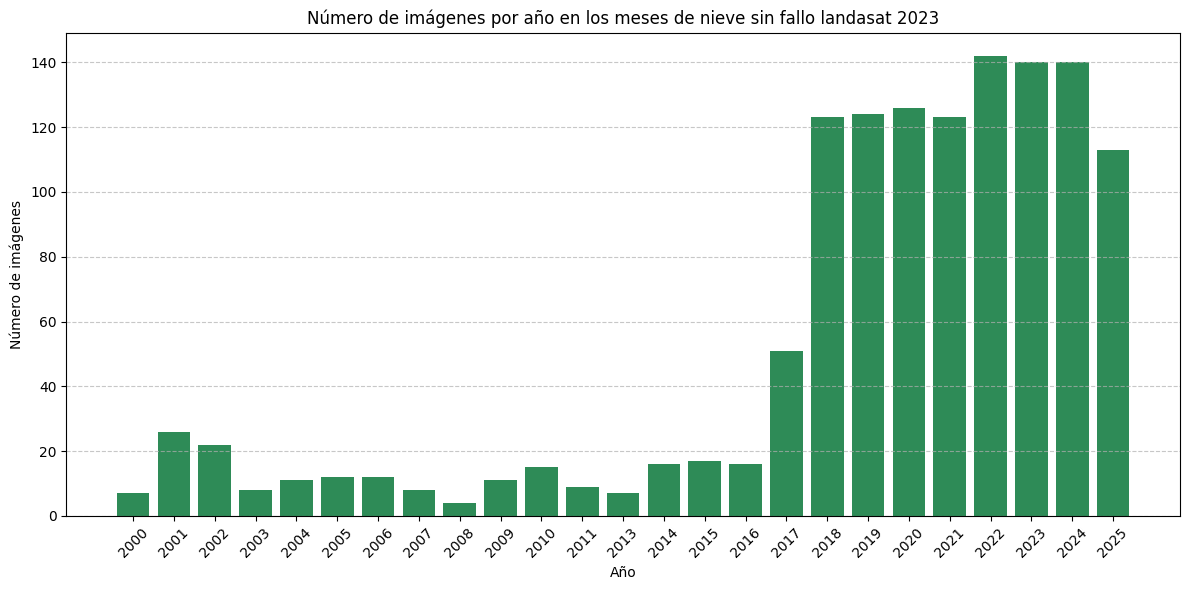

In [ ]:
# Confirmo que la columna 'Fecha' es tipo datetime
df_Andorra_Sentinel_Landsat_Invierno_csv['Fecha'] = pd.to_datetime(df_Andorra_Sentinel_Landsat_Invierno_csv['Fecha'], errors='coerce')

# Extraigo el año
df_Andorra_Sentinel_Landsat_Invierno_csv['Anio'] = df_Andorra_Sentinel_Landsat_Invierno_csv['Fecha'].dt.year

# Cuento el número de imágenes por año
conteo_anio = df_Andorra_Sentinel_Landsat_Invierno_csv['Anio'].value_counts().sort_index()

# Creo la visualización
plt.figure(figsize=(12, 6))
plt.bar(conteo_anio.index.astype(str), conteo_anio.values, color='seagreen')
plt.title('Número de imágenes por año en los meses de nieve sin fallo landasat 2023')
plt.xlabel('Año')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Compruebo el número de imágenes por año y mes

     Anio  Mes Mes_nombre  Numero_imagenes AnioMes 
0    2000  10    October          2         2000-10
1    2000  11   November          2         2000-11
2    2000  12   December          3         2000-12
3    2001   1    January          3         2001-01
4    2001   2   February          3         2001-02
5    2001   3      March          4         2001-03
6    2001   4      April          2         2001-04
7    2001   5        May          2         2001-05
8    2001   6       June          4         2001-06
9    2001  10    October          3         2001-10
10   2001  11   November          2         2001-11
11   2001  12   December          3         2001-12
12   2002   1    January          4         2002-01
13   2002   2   February          4         2002-02
14   2002   3      March          2         2002-03
15   2002   4      April          2         2002-04
16   2002   5        May          2         2002-05
17   2002   6       June          3         2002-06
18   2002  1

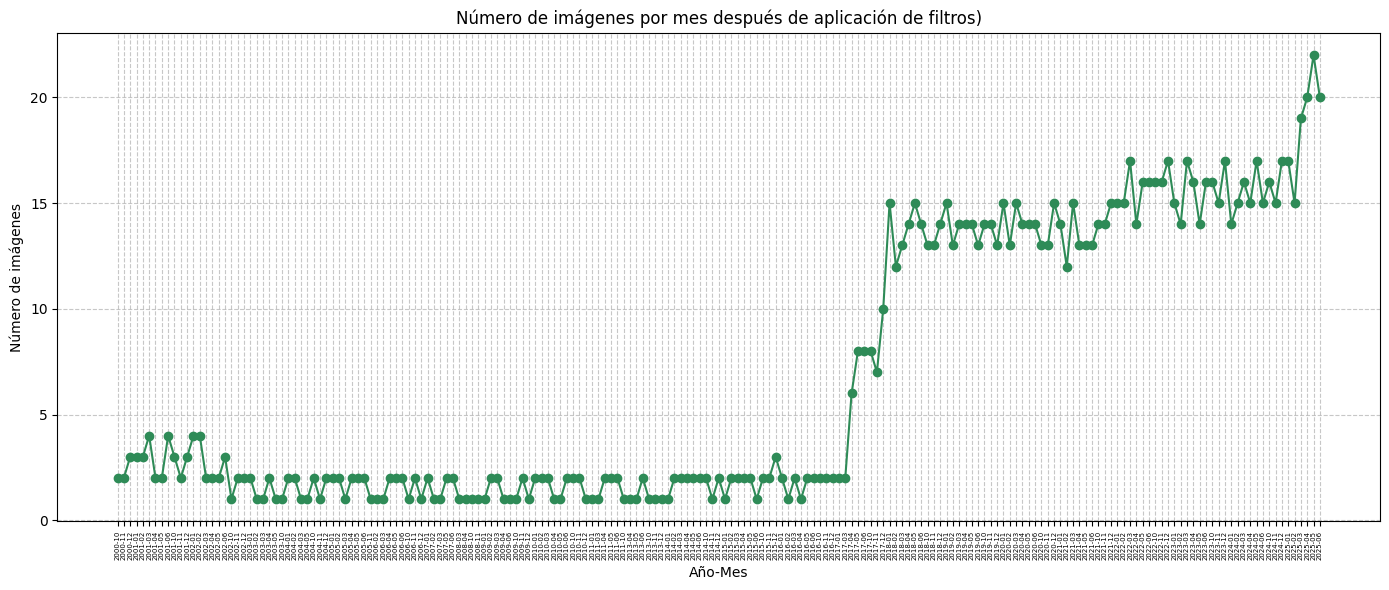

In [ ]:
# Confirmo que 'Fecha' es tipo datetime
df_Andorra_Sentinel_Landsat_Invierno_csv['Fecha'] = pd.to_datetime(
    df_Andorra_Sentinel_Landsat_Invierno_csv['Fecha'], errors='coerce'
)

# Extraigo año y mes
df_Andorra_Sentinel_Landsat_Invierno_csv['Anio'] = df_Andorra_Sentinel_Landsat_Invierno_csv['Fecha'].dt.year
df_Andorra_Sentinel_Landsat_Invierno_csv['Mes'] = df_Andorra_Sentinel_Landsat_Invierno_csv['Fecha'].dt.month
df_Andorra_Sentinel_Landsat_Invierno_csv['Mes_nombre'] = df_Andorra_Sentinel_Landsat_Invierno_csv['Fecha'].dt.strftime('%B')

# Agrupo por año y mes (siguendo un orden cronológico)
tabla_imagenes_por_anio_mes = (
    df_Andorra_Sentinel_Landsat_Invierno_csv
    .groupby(['Anio', 'Mes', 'Mes_nombre'])
    .size()
    .reset_index(name='Numero_imagenes')
    .sort_values(['Anio', 'Mes'])
    .reset_index(drop=True)
)

# Creo columna Año-Mes en formato YYYY-MM
tabla_imagenes_por_anio_mes['AnioMes'] = tabla_imagenes_por_anio_mes['Anio'].astype(str) + "-" + tabla_imagenes_por_anio_mes['Mes'].astype(str).str.zfill(2)

# Muestro la tabla completa
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 0)

print(tabla_imagenes_por_anio_mes)

# Creo la gráfica de líneas por mes/año y número de imágenes
plt.figure(figsize=(14, 6))
plt.plot(
    tabla_imagenes_por_anio_mes['AnioMes'],
    tabla_imagenes_por_anio_mes['Numero_imagenes'],
    marker='o',
    color='seagreen',
    linestyle='-'
)
plt.title('Número de imágenes por mes después de aplicación de filtros)')
plt.xlabel('Año-Mes')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=90, fontsize=5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Gap-filling. Rellenado de áreas con nubes

## Algoritmo Gap-filling

In [ ]:
# Se divide el algoritmo en los distintos pasos.

# 0. Constantes de GEE

MAX_PIX   = 1e10
TILESCALE = 2
area_img  = ee.Image.pixelArea()

# Umbral de parada temprana (algoritmo no pasa al siguiente rellenado si el nubes<1%)
STOP_CLOUD_PCT = 1.0  # %

# 1. Leo el diccionario de satélites de la tabla csv creada anteriormente

csv_path = '/content/drive/MyDrive/TFM/Andorra_Sentinel_Landsat_Invierno.csv'
df_all = pd.read_csv(csv_path)
df_all['Fecha_dt'] = pd.to_datetime(df_all['Fecha'], errors='coerce')

# Para la prueba se elige la temporada 2022/2023
# Más adelante se escogerá la imagen a limpiar (SENTINEL_2 del 2023-03-23)
inicio_inv = pd.Timestamp('2022-10-01')
fin_inv    = pd.Timestamp('2023-06-30')

mask_periodo = (df_all['Fecha_dt'] >= inicio_inv) & (df_all['Fecha_dt'] <= fin_inv)
df_22_23 = df_all[mask_periodo].copy().reset_index(drop=True)

print("Imágenes:", df_22_23.shape[0])
print(df_22_23['Satelite'].value_counts())

# 2. Máscaras de nubes

# 2.1 Máscara para Sentinel -2

CLD_PRB_THRESH = 50    # Probabilidad de nube (%)
NIR_DRK_THRESH = 0.15  # Umbral NIR oscuro para sombras de nubes
CLD_PRJ_DIST   = 1     # Distancia máx. de proyección de sombra (km)
BUFFER         = 50    # Buffer para dilatar nubes/sombras (m)


def masks_s2_v2(img):
    """
    Máscara de nubes/sombras para Sentinel-2 siguiendo el tutorial:
    https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless

    Objetivo:
      - Obtener una máscara robusta de nubes y sombras minimizando
        falsas detecciones de nieve como nube.

    Entrada:
      - img (ee.Image): Imagen Sentinel-2 SR armonizada que incluye banda SCL.

    Devuelve:
      - img_m (ee.Image): imagen original limitada a píxeles válidos (según SCL)
      - clear_mask (ee.Image): máscara de píxeles despejados (sin nubes ni sombras)
      - cloud_final (ee.Image): máscara de nubes + sombras
      - valid_mask (ee.Image): máscara de píxeles válidos según SCL
    """
    # a) Máscara de píxeles válidos

    scl = img.select("SCL")
    valid_mask = scl.neq(0).And(scl.neq(1))  # 0 NO_DATA, 1 SATURATED_OR_DEFECTIVE

    # b) Imagen de probabilidad de nubes (s2cloudless)

    s2_index = img.get('system:index')
    cld_prb_img = (
        ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filter(ee.Filter.eq('system:index', s2_index))
        .first()
    )

    cld_prb = cld_prb_img.select('probability')
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # c) Componentes de sombra de nubes

    not_water = scl.neq(6)

    SR_BAND_SCALE = 1e4
    dark_pixels = (
        img.select('B8')
        .lt(NIR_DRK_THRESH * SR_BAND_SCALE)
        .multiply(not_water)
        .rename('dark_pixels')
    )

    shadow_azimuth = ee.Number(90).subtract(
        ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE'))
    )

    cld_proj = (
        is_cloud.directionalDistanceTransform(
            shadow_azimuth,
            CLD_PRJ_DIST * 10
        )
        .reproject(crs=img.select([0]).projection(), scale=100)
        .select('distance')
        .mask()
        .rename('cloud_transform')
    )

    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # d) Máscara final nubes + sombras

    is_cld_shdw = is_cloud.add(shadows).gt(0)

    is_cld_shdw = (
        is_cld_shdw
        .focalMin(2)
        .focalMax(BUFFER * 2 / 20)
        .reproject(crs=img.select([0]).projection(), scale=20)
        .rename('cloudmask')
    )

    cloud_final = is_cld_shdw
    clear_mask  = valid_mask.And(cloud_final.Not())

    img_m = img.updateMask(valid_mask)

    return img_m, clear_mask, cloud_final, valid_mask

# 2.2 Máscara para LANDSAT 5 TOA

def masks_landsat5_toa_v1(img):
    """
    Máscara de nubes/sombras para Landsat 5 Collection 2 TOA.

    Dataset origen:
      - LANDSAT/LT05/C02/T1_TOA/...

    Objetivo:
      - Generar máscaras de píxeles válidos, nubes y despejado
        usando QA_PIXEL (Collection 2).
      - Añadir cálculo de NDSI  para no confundir nieve con nube

    Entrada:
      - img (ee.Image): Imagen Landsat 5 TOA con banda QA_PIXEL (y opcional QA_RADSAT).

    Devuelve:
      - img_m (ee.Image): imagen original limitada a píxeles válidos
      - clear_mask (ee.Image): máscara de despejado (la nieve cuenta como despejado)
      - is_cloud (ee.Image): máscara de nubes final
      - valid_mask (ee.Image): máscara de píxeles válidos (fill y saturación)
    """
    qa = img.select("QA_PIXEL")

    # Bits QA_PIXEL (Collection 2)
    fill         = qa.bitwiseAnd(1 << 0).neq(0)
    dilatedCloud = qa.bitwiseAnd(1 << 1).neq(0)
    cirrus       = qa.bitwiseAnd(1 << 2).neq(0)
    cloud        = qa.bitwiseAnd(1 << 3).neq(0)
    cloudShadow  = qa.bitwiseAnd(1 << 4).neq(0)

    # Máscara de píxeles válidos:
    valid_mask = fill.Not()

    # Si existe QA_RADSAT, lo usamos para eliminar saturados
    band_names = img.bandNames()
    valid_mask = ee.Image(
        ee.Algorithms.If(
            band_names.contains('QA_RADSAT'),
            valid_mask.And(img.select('QA_RADSAT').eq(0)),
            valid_mask
        )
    )

    # Bandas (TOA) para índices
    blue  = img.select("B1")
    green = img.select("B2")
    red   = img.select("B3")
    nir   = img.select("B4")
    swir1 = img.select("B5")

    # Índices auxiliares para ayuda de la detección/diferenciación
    ndvi = nir.subtract(red).divide(nir.add(red))
    ndsi = green.subtract(swir1).divide(green.add(swir1))
    brightness = blue.add(green).add(red).divide(3)

    # Nieve (con umbral conservador de 0.35 para estar seguros)
    is_snow = ndsi.gt(0.35)

    # Pasos para evitar la confusión nieve/nube

    # a) Nube "core": cloud + dilatedCloud
    qa_cloud_core = cloud.Or(dilatedCloud)

    # b) Cirros: si apareciese, solo si es brillante y NDVI bajo-moderado
    qa_cloud_cirrus = cirrus.And(brightness.gt(0.20)).And(ndvi.lt(0.6))

    # c) Sombra: oscuro y NDVI bajo
    qa_cloud_shadow = (
        cloudShadow
        .And(brightness.lt(0.25))
        .And(ndvi.lt(0.4))
    )

    qa_cloud = qa_cloud_core.Or(qa_cloud_cirrus).Or(qa_cloud_shadow)

    # Nubes finales: QA + exclusión de nieve
    is_cloud = qa_cloud.And(is_snow.Not())

    # Clear = píxeles válidos y sin nubes (la nieve cuenta como despejado)
    clear_mask = valid_mask.And(is_cloud.Not())

    # Imagen con solo píxeles válidos (incluye nubes, nieve y tierra)
    img_m = img.updateMask(valid_mask)

    return img_m, clear_mask, is_cloud, valid_mask


# 2.3 Máscara para LANDSAT 8/9 TOA
def masks_landsat_toa_v3(img):
    """
    Máscara de nubes/sombras para Landsat 8/9 Collection 2 TOA.

    Objetivo:
      - Generar máscaras de píxeles válidos, nubes y despejado
        usando QA_PIXEL y diferenciación entre nieve y nube.
      - Se incluye también el bit de 'dilated cloud'
        para una detección de nubes más conservadora.

    Entrada:
      - img (ee.Image): Imagen Landsat TOA con banda QA_PIXEL (y opcional QA_RADSAT).

    Devuelve:
      - img_m (ee.Image): imagen original limitada a píxeles válidos
      - clear_mask (ee.Image): máscara de despejado (la nieve cuenta como despejado)
      - is_cloud (ee.Image): máscara de nubes final
      - valid_mask (ee.Image): máscara de píxeles válidos (fill y saturación)
    """
    qa = img.select("QA_PIXEL")

    # Bits QA_PIXEL (Collection 2)
    fill         = qa.bitwiseAnd(1 << 0).neq(0)
    dilatedCloud = qa.bitwiseAnd(1 << 1).neq(0)
    cirrus       = qa.bitwiseAnd(1 << 2).neq(0)
    cloud        = qa.bitwiseAnd(1 << 3).neq(0)
    cloudShadow  = qa.bitwiseAnd(1 << 4).neq(0)

    # Máscara de píxeles válidos:
    valid_mask = fill.Not()

    # Si existe QA_RADSAT, lo usamos para eliminar saturados
    band_names = img.bandNames()
    valid_mask = ee.Image(
        ee.Algorithms.If(
            band_names.contains('QA_RADSAT'),
            valid_mask.And(img.select('QA_RADSAT').eq(0)),
            valid_mask
        )
    )

    # Bandas (TOA) para índices
    blue  = img.select("B2")
    green = img.select("B3")
    red   = img.select("B4")
    nir   = img.select("B5")
    swir1 = img.select("B6")

    # Índices auxiliares
    ndvi = nir.subtract(red).divide(nir.add(red))
    ndsi = green.subtract(swir1).divide(green.add(swir1))
    brightness = blue.add(green).add(red).divide(3)

    # Nieve con índice ndsi y valor umbral conservador
    is_snow = ndsi.gt(0.35)

    # Pasos para evitar la confusión nieve/nube

    # 1) Nube "core": cloud + dilatedCloud
    qa_cloud_core = cloud.Or(dilatedCloud)

    # 2) Cirros: solo si son relativamente brillantes y con NDVI bajo-moderado
    qa_cloud_cirrus = cirrus.And(brightness.gt(0.20)).And(ndvi.lt(0.6))

    # 3) Sombra de nube: solo si es oscuro y con NDVI bajo
    qa_cloud_shadow = (
        cloudShadow
        .And(brightness.lt(0.25))
        .And(ndvi.lt(0.4))
    )

    qa_cloud = qa_cloud_core.Or(qa_cloud_cirrus).Or(qa_cloud_shadow)

    # Nubes finales: QA + exclusión de nieve
    is_cloud = qa_cloud.And(is_snow.Not())

    clear_mask = valid_mask.And(is_cloud.Not())
    img_m = img.updateMask(valid_mask)

    return img_m, clear_mask, is_cloud, valid_mask


# 3. Preparación de la imagen satelital

def prep_image(img_id, sat):
    """
    Prepara una imagen de entrada para el pipeline de clasificación nieve/tierra/nube.

    Objetivo:
      - Cargar la imagen por el ID propio de la imagen de GEE
      - Aplicar la máscara de nubes/sombras apropiada según satélite.
      - Calcular NDSI y una máscara inicial de nieve.
      - Devolver también la proyección y escala de trabajo asociadas.

    Entradas:
      - img_id (str): ID completo de la imagen en GEE.
      - sat (str): Identificador de satélite ('SENTINEL_2', 'LANDSAT_5', 'LANDSAT_8', 'LANDSAT_9').

    Devuelve un diccionario con:
      - 'ndsi' (ee.Image): NDSI calculado.
      - 'snow_mask' (ee.Image): máscara binaria inicial de nieve (NDSI >= 0.15).
      - 'clear_mask' (ee.Image): máscara de píxeles despejados.
      - 'cloud_mask' (ee.Image): máscara de nube/sombra.
      - 'valid_mask' (ee.Image): máscara de píxeles válidos.
      - 'scale' (int): escala  de trabajo (10 o 30) según satélite.
      - 'projection' (ee.Projection): proyección espacial de trabajo.
    """
    img = ee.Image(img_id)

    if sat in ['LANDSAT_8', 'LANDSAT_9']:
        img_m, clear, cloud, valid = masks_landsat_toa_v3(img)
        scale = 30
        green, swir = 'B3', 'B6'

    elif sat == 'LANDSAT_5':
        img_m, clear, cloud, valid = masks_landsat5_toa_v1(img)
        scale = 30
        green, swir = 'B2', 'B5'

    elif sat == 'SENTINEL_2':
        img_m, clear, cloud, valid = masks_s2_v2(img)
        scale = 10
        green, swir = 'B3', 'B11'

    else:
        raise ValueError(f"Satélite no válido para la función prep_image: {sat}")

    ndsi = img_m.normalizedDifference([green, swir]).rename('NDSI')
    snow = ndsi.gte(0.15)
    proj = ndsi.projection()

    return {
        'ndsi'      : ndsi,
        'snow_mask' : snow,
        'clear_mask': clear,
        'cloud_mask': cloud,
        'valid_mask': valid,
        'scale'     : scale,
        'projection': proj
    }

# 4. Relleno temporal ±5 DÍAS (Con 2 iteraciones)

def get_classification_after_temporal(img_id, sat, fecha_dt, df_all):
    """
    Relleno temporal de nubes usando imágenes cercanas en el tiempo.

    Objetivo:
      - Partir de la clasificación inicial derivada de la imagen objetivo.
      - Identificar píxeles nublados (unknown0).
      - Buscar imágenes candidatas dentro de ±5 días.
      - Rellenar nubes con 2 iteraciones usando las imágenes más próximas.

    Entradas:
      - img_id (str): ID completo de la imagen objetivo.
      - sat (str): satélite de la imagen objetivo.
      - fecha_dt (pd.Timestamp): fecha de la imagen objetivo.
      - df_all (pd.DataFrame): Tabla de datos de imágenes satelitales.

    Salidas:
      - snow (ee.Image): máscara de nieve tras relleno temporal.
      - land (ee.Image): máscara de tierra tras relleno temporal.
      - cloud (ee.Image): máscara de nubes remanentes.
      - None: valor mantenido de la estructura.
      - scale (int): escala declarada de trabajo según satélite objetivo.
      - proj0 (ee.Projection): proyección objetivo a la que se reproyectan vecinos.
    """
    info0  = prep_image(img_id, sat)
    snow0  = info0['snow_mask'].unmask(0)
    clear0 = info0['clear_mask'].unmask(0)
    cloud0 = info0['cloud_mask'].unmask(0)
    scale  = info0['scale']
    proj0  = info0['projection']

    land0    = clear0.And(snow0.Not()).unmask(0)
    unknown0 = cloud0

    if pd.isna(fecha_dt):
        return snow0, land0, cloud0, None, scale, proj0

    window_start = fecha_dt - timedelta(days=5)
    window_end   = fecha_dt + timedelta(days=5)

    df_cands = df_all[
        (df_all['Fecha_dt'] >= window_start) &
        (df_all['Fecha_dt'] <= window_end) &
        (df_all['ID_completo'] != img_id)
    ].copy()

    if df_cands.empty:
        return snow0, land0, cloud0, None, scale, proj0

    df_cands['delta_abs'] = (df_cands['Fecha_dt'] - fecha_dt).abs()
    df_cands = df_cands.sort_values('delta_abs')

    # 1ª iteración
    row_nei1 = df_cands.iloc[0]
    infoN1 = prep_image(row_nei1['ID_completo'], row_nei1['Satelite'])
    snowN1  = infoN1['snow_mask'].reproject(proj0).unmask(0)
    clearN1 = infoN1['clear_mask'].reproject(proj0).unmask(0)

    fill_mask1 = unknown0.And(clearN1)
    new_snow1 = fill_mask1.And(snowN1)
    new_land1 = fill_mask1.And(snowN1.Not())

    land1  = land0.where(unknown0, new_land1)
    snow1  = snow0.where(unknown0, new_snow1)
    cloud1 = unknown0.And(clearN1.Not())

    if df_cands.shape[0] == 1:
        return snow1.unmask(0), land1.unmask(0), cloud1.unmask(0), None, scale, proj0

    # 2ª iteración
    row_nei2 = df_cands.iloc[1]
    infoN2 = prep_image(row_nei2['ID_completo'], row_nei2['Satelite'])
    snowN2  = infoN2['snow_mask'].reproject(proj0).unmask(0)
    clearN2 = infoN2['clear_mask'].reproject(proj0).unmask(0)

    unknown1   = cloud1
    fill_mask2 = unknown1.And(clearN2)

    new_snow2 = fill_mask2.And(snowN2)
    new_land2 = fill_mask2.And(snowN2.Not())

    land2  = land1.where(unknown1, new_land2)
    snow2  = snow1.where(unknown1, new_snow2)
    cloud2 = unknown1.And(clearN2.Not())

    return snow2.unmask(0), land2.unmask(0), cloud2.unmask(0), None, scale, proj0

# 5. Vecinos por método KNN global por distancia, 2 iteraciones


MAX_KNN_DIST_PIX_SENTINEL = 15
MAX_KNN_DIST_PIX_LANDSAT  = 5
N_KNN_ITERS = 2


def _knn_fill_once(snow, land, cloud, max_dist_pix, proj):
    """
    Relleno espacial de zonas remanentes con nubes por vecindad (KNN)

    Objetivo:
      - Asignar valor de nieve o tierra a píxeles con nubes
        según la clase más cercana dentro de un radio máximo.

    Entradas:
      - snow (ee.Image): máscara binaria de nieve.
      - land (ee.Image): máscara binaria de tierra.
      - cloud (ee.Image): máscara binaria de nubes.
      - max_dist_pix (int): distancia máxima en píxeles para buscar vecinos.
      - proj (ee.Projection): proyección objetivo.

    Salidas:
      - snow2 (ee.Image): nieve tras una pasada de relleno.
      - land2 (ee.Image): tierra tras una pasada de relleno.
      - cloud2 (ee.Image): nubes remanentes tras una pasada.
    """
    snow  = snow.unmask(0).reproject(proj)
    land  = land.unmask(0).reproject(proj)
    cloud = cloud.unmask(0).reproject(proj)

    dist_snow = snow.fastDistanceTransform(
        neighborhood=max_dist_pix * 2,
        units='pixels',
        metric='squared_euclidean'
    ).sqrt()

    dist_land = land.fastDistanceTransform(
        neighborhood=max_dist_pix * 2,
        units='pixels',
        metric='squared_euclidean'
    ).sqrt()

    closer_to_snow = dist_snow.lt(dist_land)
    closer_to_land = dist_land.lt(dist_snow)

    within_snow = dist_snow.lte(max_dist_pix)
    within_land = dist_land.lte(max_dist_pix)

    fill_snow = cloud.And(closer_to_snow).And(within_snow)
    fill_land = cloud.And(closer_to_land).And(within_land)

    snow2  = snow.Or(fill_snow)
    land2  = land.Or(fill_land)
    cloud2 = cloud.And(fill_snow.Not()).And(fill_land.Not())

    return snow2, land2, cloud2


def get_classification_after_neighbors(img_id, sat, fecha_dt, df_all):
    """
    Relleno espacial de nubes usando vecinos cercanos (hasta 2 iteraciones).

    Objetivo:
      - Partir del resultado del relleno temporal.
      - Aplicar un relleno por distancia a nieve/tierra
        usando un radio equivalente ~150 m ajustado por satélite.

    Entradas:
      - img_id (str): ID de la imagen objetivo.
      - sat (str): satélite de la imagen objetivo.
      - fecha_dt (pd.Timestamp): fecha de la imagen objetivo (no usada aquí directamente).
      - df_all (pd.DataFrame): DataFrame con metadatos (usado en el paso temporal previo).

    Devuelve:
      - snow (ee.Image): nieve tras relleno por vecinos.
      - land (ee.Image): tierra tras relleno por vecinos.
      - cloud (ee.Image): nubes remanentes.
      - None: valor mantenido de la estructura.
      - scale (int): escala declarada de trabajo.
      - proj0 (ee.Projection): proyección objetivo.
    """
    snow, land, cloud, _, scale, proj0 = \
        get_classification_after_temporal(img_id, sat, fecha_dt, df_all)

    max_dist_pix = (
        MAX_KNN_DIST_PIX_SENTINEL if sat == 'SENTINEL_2' else MAX_KNN_DIST_PIX_LANDSAT
    )

    for _ in range(N_KNN_ITERS):
        snow, land, cloud = _knn_fill_once(snow, land, cloud, max_dist_pix, proj0)

    return snow.unmask(0), land.unmask(0), cloud.unmask(0), None, scale, proj0



# 6. Filtro  DEM (nieve)
# Imagen
# https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003?hl=es-419
dem = ee.Image('USGS/SRTMGL1_003').clip(andorra)

MAX_DEM_DIST_PIX_SENTINEL = 15
MAX_DEM_DIST_PIX_LANDSAT  = 5
N_DEM_ITERS = 2


def _compute_snowline(dem_t, snow_mask, scale):
    """
    Estima la cota de nieve (snowline)  por percentil 20 a partir del DEM.

    Objetivo:
      - Calcular una snowline usando el percentil 20 de elevación
        donde hay nieve.
      - Si no hay nieve, usar el percentil 20 del DEM completo
        dentro de Andorra.

    Entradas:
      - dem_t (ee.Image): DEM reproyectado a la proyección objetivo.
      - snow_mask (ee.Image): máscara binaria de nieve.
      - scale (int): escala a usar en reduceRegion.

    Salida:
      - base_snowline (ee.Number): estimación de snowline en metros.
    """
    snow_elev = dem_t.updateMask(snow_mask)

    snow_stats = ee.Dictionary(
        snow_elev.reduceRegion(
            reducer=ee.Reducer.percentile([20]),
            geometry=andorra,
            scale=scale,
            maxPixels=MAX_PIX,
            tileScale=TILESCALE
        )
    )

    dem_stats = ee.Dictionary(
        dem_t.reduceRegion(
            reducer=ee.Reducer.percentile([20]),
            geometry=andorra,
            scale=scale,
            maxPixels=MAX_PIX,
            tileScale=TILESCALE
        )
    )

    snow_has_values = snow_stats.size().gt(0)

    base_snowline = ee.Number(ee.Algorithms.If(
        snow_has_values,
        snow_stats.values().sort().get(0),
        dem_stats.values().sort().get(0)
    ))

    return base_snowline


def _dem_fill_once(snow, land, cloud, dem_t, max_dist_pix, scale, proj0):
    """
    Aplica una iteración de relleno DEM para asignar nieve en nubes.

    Regla para asignar nieve a zona clasificada como nube:
      - nube + cerca de nieve + por encima de (snowline - 100 m) -> nieve

    Entradas:
      - snow (ee.Image): máscara de nieve.
      - land (ee.Image): máscara de tierra.
      - cloud (ee.Image): máscara de nubes.
      - dem_t (ee.Image): DEM reproyectado.
      - max_dist_pix (int): radio máximo en píxeles para proximidad a nieve.
      - scale (int): escala para calcular snowline.
      - proj0 (ee.Projection): proyección objetivo.

    Devuelve:
      - snow_out, land_out, cloud_out (ee.Image): máscaras actualizadas.
    """
    snowline = _compute_snowline(dem_t, snow, scale).subtract(100)

    snow_dist = snow.unmask(0).reproject(proj0).fastDistanceTransform(
        neighborhood=max_dist_pix * 2,
        units='pixels',
        metric='squared_euclidean'
    ).sqrt()

    near_snow = snow_dist.lte(max_dist_pix)

    high_cloud_near_snow = (
        cloud
        .And(near_snow)
        .And(dem_t.gte(snowline))
    )

    snow_out  = snow.Or(high_cloud_near_snow)
    land_out  = land.And(snow_out.Not())
    cloud_out = cloud.And(high_cloud_near_snow.Not())

    return snow_out, land_out, cloud_out


def get_classification_after_dem(img_id, sat, fecha_dt, df_all, dem_img):
    """
    Relleno basado en DEM para asignar nieve a nubes.

    Objetivo:
      - Partir del resultado tras vecinos.
      - Estimar snowline.
      - Asignar nieve a nubes cercanas a nieve y a cota según snowlina.
      - Ejecuta 2 iteraciones.

    Entradas:
      - img_id (str): ID imagen objetivo.
      - sat (str): satélite imagen objetivo.
      - fecha_dt (pd.Timestamp): fecha (no usada directamente en este paso).
      - df_all (pd.DataFrame): DataFrame de metadatos.
      - dem_img (ee.Image): DEM base.

    Devuelve:
      - snow, land, cloud, None, scale, proj0
    """
    snow2, land2, cloud2, _, scale, proj0 = \
        get_classification_after_neighbors(img_id, sat, fecha_dt, df_all)

    dem_t = dem_img.reproject(proj0)

    max_dist_pix = (
        MAX_DEM_DIST_PIX_SENTINEL if sat == 'SENTINEL_2' else MAX_DEM_DIST_PIX_LANDSAT
    )

    snow_i, land_i, cloud_i = snow2, land2, cloud2

    for _ in range(N_DEM_ITERS):
        snow_i, land_i, cloud_i = _dem_fill_once(
            snow_i, land_i, cloud_i,
            dem_t, max_dist_pix,
            scale, proj0
        )

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), None, scale, proj0



# Cálculo de la cota de nieve (snowline) para una imagen

def get_snowline_for_image(img_id, sat, fecha_dt, df_all, dem_img):
    """
    Calcula la snowline estimada para una imagen objetivo.

    Objetivo:
      - Usar la nieve obtenida tras el paso de vecinos (KNN)
      - Calcular snowline con la función _compute_snowline.

    Entradas:
      - img_id (str): ID imagen objetivo.
      - sat (str): satélite de la imagen.
      - fecha_dt (pd.Timestamp): fecha de la imagen.
      - df_all (pd.DataFrame): DataFrame de metadatos.
      - dem_img (ee.Image): DEM base.

    Devuelve:
      - snowline (ee.Number): cota de nieve estimada (m).
    """
    snow2, land2, cloud2, _, scale, proj0 = \
        get_classification_after_neighbors(img_id, sat, fecha_dt, df_all)

    dem_t = dem_img.reproject(proj0)
    snowline = _compute_snowline(dem_t, snow2, scale)

    return snowline


# 7. Filtro DEM inverso (tierra)

N_DEM_INV_ITERS = 2
DEM_INV_MARGIN_M = 100


def _dem_inverse_fill_once(snow, land, cloud, dem_t, max_dist_pix, scale, proj0):
    """
    Aplica una iteración de relleno DEM inverso para asignar categoría tierra en nubes.

    Regla:
      - nube + cerca de tierra + por debajo de (snowline - 100) -> tierra

    Entradas:
      - snow (ee.Image): máscara de nieve.
      - land (ee.Image): máscara de tierra.
      - cloud (ee.Image): máscara de nubes.
      - dem_t (ee.Image): DEM reproyectado.
      - max_dist_pix (int): radio de proximidad a tierra (en píxeles).
      - scale (int): escala para cálculo de snowline.
      - proj0 (ee.Projection): proyección objetivo.

    Devuelve:
      - snow_out, land_out, cloud_out (ee.Image): máscaras actualizadas.
    """
    snowline = _compute_snowline(dem_t, snow, scale)
    landline = snowline.subtract(DEM_INV_MARGIN_M)

    land_dist = land.unmask(0).reproject(proj0).fastDistanceTransform(
        neighborhood=max_dist_pix * 2,
        units='pixels',
        metric='squared_euclidean'
    ).sqrt()

    near_land = land_dist.lte(max_dist_pix)

    low_cloud_near_land = (
        cloud
        .And(near_land)
        .And(dem_t.lte(landline))
    )

    land_out  = land.Or(low_cloud_near_land)
    snow_out  = snow.And(land_out.Not())
    cloud_out = cloud.And(low_cloud_near_land.Not())

    return snow_out, land_out, cloud_out


def get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_all, dem_img):
    """
    Relleno DEM inverso para asignar categoría TIERRA en nubes.

    Objetivo:
      - Partir del resultado del filtro DEM de nieve.
      - Estimar snowline.
      - Asignar tierra a nubes cercanas a tierra y por debajo del umbral altitudinal.
      - Ejecutar 2 iteraciones.

    Entradas:
      - img_id (str): ID imagen objetivo.
      - sat (str): satélite de la imagen objetivo.
      - fecha_dt (pd.Timestamp): fecha de la imagen.
      - df_all (pd.DataFrame): DataFrame de metadatos.
      - dem_img (ee.Image): DEM base.

    Devuelve:
      - snow, land, cloud, None, scale, proj0
    """
    snow3, land3, cloud3, _, scale, proj0 = \
        get_classification_after_dem(img_id, sat, fecha_dt, df_all, dem_img)

    dem_t = dem_img.reproject(proj0)

    max_dist_pix = (
        MAX_DEM_DIST_PIX_SENTINEL if sat == 'SENTINEL_2' else MAX_DEM_DIST_PIX_LANDSAT
    )

    snow_i, land_i, cloud_i = snow3, land3, cloud3

    for _ in range(N_DEM_INV_ITERS):
        snow_i, land_i, cloud_i = _dem_inverse_fill_once(
            snow_i, land_i, cloud_i,
            dem_t, max_dist_pix,
            scale, proj0
        )

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), None, scale, proj0



# 8. Funciones auxiliares


def build_class_image(snow, land, cloud):
    """
    Construye una imagen de clases (0-3) a partir de máscaras binarias.

    Objetivo:
      - Crear una imagen categórica para visualización:
          0: sin datos
          1: tierra
          2: nieve
          3: nube
      - Heredar una proyección razonable desde la máscara de nieve.

    Entradas:
      - snow (ee.Image): máscara binaria de nieve.
      - land (ee.Image): máscara binaria de tierra.
      - cloud (ee.Image): máscara binaria de nubes.

    Devuelve:
      - class_img (ee.Image): imagen de clase en banda 'class'
    """
    proj = snow.projection()

    class_img = (
        ee.Image(0).reproject(proj)
        .where(land, 1)
        .where(snow, 2)
        .where(cloud, 3)
        .rename('class')
    )

    mask_final = land.Or(snow).Or(cloud)
    return class_img.updateMask(mask_final)


def compute_cloud_pct(mask, scale, geometry=andorra):
    """
    Calcula el porcentaje de nubosidad sobre un polígono objetivo.

    Objetivo:
      - Convertir una máscara de nubes en área (km²) usando pixelArea.
      - Calcular el porcentaje respecto al área total del polígono.

    Entradas:
      - mask (ee.Image): máscara binaria de nubes.
      - scale (int): escala de cómputo (10 para S2, 30 para Landsat).
      - geometry (ee.Geometry): geometría de cálculo (por defecto Andorra).

    Devuelve:
      - cloud_pct (float): porcentaje de área cubierta por nubes.
    """
    cloud_area = area_img.updateMask(mask).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=scale,
        maxPixels=MAX_PIX,
        tileScale=TILESCALE
    )
    total_area = area_img.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=scale,
        maxPixels=MAX_PIX,
        tileScale=TILESCALE
    )

    cloud_km2 = ee.Number(cloud_area.get('area')).divide(1e6)
    total_km2 = ee.Number(total_area.get('area')).divide(1e6)
    return cloud_km2.divide(total_km2).multiply(100).getInfo()


vis_rgb   = {'min': 0.0, 'max': 0.3}
vis_ndsi  = {'min': -1, 'max': 1, 'palette': ['blue', 'white']}
vis_class = {
    'min': 0, 'max': 3,
    'palette': ['#00000000', '#8B4513', '#FFFFFF', '#FF0000']
}
vis_andorra = {'palette': ['#FFFF00'], 'min': 0, 'max': 1}

vis_dem = {
    'min': 800,
    'max': 3000,
    'palette': ['0000ff','00ffff','00ff00','ffff00','ff0000','ffffff']
}


# 9. Relleno final con MODIS


MAX_MODIS_ITERS = 5
MODIS_CLOUD_STOP_PCT = 1.0
MODIS_SNOW_THRESH = 15


def prep_modis_snow_masks(modis_img, proj0):
    """
    Prepara máscaras binarias de MODIS para relleno de nubes.

    Objetivo:
      - Derivar una máscara de nieve a partir de la banda
        'NDSI_Snow_Cover'.
      - Derivar una máscara de "clear" donde MODIS tiene dato válido.
      - Reproyectar ambas a la proyección de la imagen objetivo.

    Entradas:
      - modis_img (ee.Image): imagen MODIS MOD10A1.
      - proj0 (ee.Projection): proyección de la imagen objetivo.

    Devuelve:
      - snowM (ee.Image): máscara binaria de nieve MODIS.
      - clearM (ee.Image): máscara binaria de píxeles válidos MODIS.
    """
    snow_cover = modis_img.select('NDSI_Snow_Cover')
    clearM = snow_cover.mask()
    snowM = snow_cover.gte(MODIS_SNOW_THRESH)

    clearM = clearM.reproject(proj0).unmask(0)
    snowM  = snowM.reproject(proj0).unmask(0)

    return snowM, clearM


def get_modis_candidates_sorted(fecha_dt):
    """
    Obtiene una colección MODIS ordenada por fechas próximas a la objetivo.

    Objetivo:
      - Buscar imágenes MODIS dentro de una ventana de ±10 días.
      - Añadir una propiedad 'delta_abs' con la distancia absoluta en días.
      - Ordenar la colección por dicha distancia.

    Entradas:
      - fecha_dt (pd.Timestamp): fecha de la imagen objetivo.

    Devuelve:
      - col (ee.ImageCollection): colección MODIS ordenada por delta_abs.
    """
    start = ee.Date(fecha_dt.strftime('%Y-%m-%d')).advance(-10, 'day')
    end   = ee.Date(fecha_dt.strftime('%Y-%m-%d')).advance(10, 'day')

    col = (
        ee.ImageCollection('MODIS/061/MOD10A1')
        .filterDate(start, end)
        .select('NDSI_Snow_Cover')
    )

    target = ee.Date(fecha_dt.strftime('%Y-%m-%d'))

    def add_delta(img):
        d = img.date().difference(target, 'day').abs()
        return img.set('delta_abs', d)

    return col.map(add_delta).sort('delta_abs')


def get_classification_after_modis(img_id, sat, fecha_dt, df_all, dem_img):
    """
    Relleno final de nubes con MODIS tras el paso DEM inverso.

    Objetivo:
      - Ejecutar el relleno para reducir nubes.
      - Usar MODIS MOD10A1 (snow cover diario) ordenado por cercanía temporal.
      - Parar cuando la nubosidad baje de 1% o tras 5 iteraciones.

    Condiciones:
      - Solo actúa si la nubosidad tras DEM inverso > 1%.
      - Si no hay fecha válida, no realiza relleno.

    Entradas:
      - img_id (str): ID imagen objetivo.
      - sat (str): satélite de la imagen objetivo.
      - fecha_dt (pd.Timestamp): fecha de la imagen objetivo.
      - df_all (pd.DataFrame): DataFrame de metadatos del periodo.
      - dem_img (ee.Image): DEM base.

    Devuelve:
      - snow (ee.Image): nieve tras relleno MODIS.
      - land (ee.Image): tierra tras relleno MODIS.
      - cloud (ee.Image): nubes remanentes.
      - iters_used (int): número de iteraciones MODIS aplicadas.
      - scale (int): escala declarada de la imagen objetivo.
      - proj0 (ee.Projection): proyección objetivo.
    """
    snow4, land4, cloud4, _, scale, proj0 = \
        get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_all, dem_img)

    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= MODIS_CLOUD_STOP_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0, scale, proj0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0, scale, proj0

    modis_col = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= MODIS_CLOUD_STOP_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used, scale, proj0


# 10. Elección de la imagen de muesttra para verificar el proceso
# Selección de la imagen

img_fixed_id = "COPERNICUS/S2_SR_HARMONIZED/20230323T103711_20230323T104703_T31TCH"
row = df_22_23[df_22_23["ID_completo"] == img_fixed_id].iloc[0]

img_id   = row['ID_completo']
satelite = row['Satelite']
fecha_dt = row['Fecha_dt']

print("\nImagen seleccionada (fija):")
print("  ID       :", img_id)
print("  Satélite :", satelite)
print("  Fecha    :", fecha_dt)


# 11. PIPELINE DE CLASIFICACIÓN CON PARADA TEMPRANA

# Paso inicial
info0  = prep_image(img_id, satelite)
ndsi   = info0['ndsi']
snow0  = info0['snow_mask']
clear0 = info0['clear_mask']
cloud0 = info0['cloud_mask']
scale0 = info0['scale']

land0 = clear0.And(snow0.Not())

cloud0_pct = compute_cloud_pct(cloud0, scale0)

# Inicializamos variables de pasos
snow1 = land1 = cloud1 = None
snow2 = land2 = cloud2 = None
snow3 = land3 = cloud3 = None
snow4 = land4 = cloud4 = None
snow5 = land5 = cloud5 = None

scale1 = scale2 = scale3 = scale4 = scale5 = scale0
modis_iters = 0

cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None

stopped = False
stop_pct = None

# Relleno temporal ±5 días
if cloud0_pct <= STOP_CLOUD_PCT:
    stopped = True
    stop_pct = cloud0_pct

    snow1, land1, cloud1 = snow0, land0, cloud0
    cloud1_pct = stop_pct
else:
    snow1, land1, cloud1, _, scale1, _ = \
        get_classification_after_temporal(img_id, satelite, fecha_dt, df_22_23)
    cloud1_pct = compute_cloud_pct(cloud1, scale1)

    if cloud1_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud1_pct

# Relleno por vecinos
if stopped:
    snow2, land2, cloud2 = snow1, land1, cloud1
    scale2 = scale1
    cloud2_pct = stop_pct
else:
    snow2, land2, cloud2, _, scale2, _ = \
        get_classification_after_neighbors(img_id, satelite, fecha_dt, df_22_23)
    cloud2_pct = compute_cloud_pct(cloud2, scale2)

    if cloud2_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud2_pct

# Relleno por DEM (nieve)
if stopped:
    snow3, land3, cloud3 = snow2, land2, cloud2
    scale3 = scale2
    cloud3_pct = stop_pct
else:
    snow3, land3, cloud3, _, scale3, _ = \
        get_classification_after_dem(img_id, satelite, fecha_dt, df_22_23, dem)
    cloud3_pct = compute_cloud_pct(cloud3, scale3)

    if cloud3_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud3_pct

# Relleno por DEM inverso (tierra)
if stopped:
    snow4, land4, cloud4 = snow3, land3, cloud3
    scale4 = scale3
    cloud4_pct = stop_pct
else:
    snow4, land4, cloud4, _, scale4, _ = \
        get_classification_after_dem_inverse(img_id, satelite, fecha_dt, df_22_23, dem)
    cloud4_pct = compute_cloud_pct(cloud4, scale4)

    if cloud4_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud4_pct

# Relleno por MODIS
if stopped:
    snow5, land5, cloud5 = snow4, land4, cloud4
    scale5 = scale4
    cloud5_pct = stop_pct
    modis_iters = 0
else:
    snow5, land5, cloud5, modis_iters, scale5, _ = \
        get_classification_after_modis(img_id, satelite, fecha_dt, df_22_23, dem)
    cloud5_pct = compute_cloud_pct(cloud5, scale5)

    # Si MODIS deja <1% también lo mostramos
    if cloud5_pct <= STOP_CLOUD_PCT:
        stop_pct = cloud5_pct


# 12. Tabla de % de nubes de la imagen

df_info = pd.DataFrame({
    "Paso": [
        "Inicial",
        "Tras ±5 días",
        "Tras vecinos",
        "Tras filtro DEM",
        "Tras DEM inverso",
        "Tras relleno MODIS"
    ],
    "Nubes (%)": [
        cloud0_pct,
        cloud1_pct,
        cloud2_pct,
        cloud3_pct,
        cloud4_pct,
        cloud5_pct
    ]
})

print("\n Tabla de nubes para esta imagen")
print(df_info.to_string(index=False, formatters={"Nubes (%)": "{:.3f}".format}))
print(f"Iteraciones usadas en relleno MODIS: {modis_iters}\n")


# 13. Visualización

class0 = build_class_image(snow0, land0, cloud0)
class1 = build_class_image(snow1, land1, cloud1)
class2 = build_class_image(snow2, land2, cloud2)
class3 = build_class_image(snow3, land3, cloud3)
class4 = build_class_image(snow4, land4, cloud4)
class5 = build_class_image(snow5, land5, cloud5)

imagen_raw = ee.Image(img_id)

if satelite in ['LANDSAT_5', 'LANDSAT_7']:
    rgb_full = imagen_raw.select(['B3','B2','B1'])
elif satelite in ['LANDSAT_8','LANDSAT_9']:
    rgb_full = imagen_raw.select(['B4','B3','B2'])
elif satelite == 'SENTINEL_2':
    rgb_full = imagen_raw.select(['B4','B3','B2']).divide(10000)
else:
    rgb_full = imagen_raw

rgb_full  = rgb_full.clip(andorra)
rgb_clear = rgb_full.updateMask(clear0)

andorra_outline = ee.Image().byte().paint(andorra, 1, 2)

m = geemap.Map(center=[42.55, 1.6], zoom=11, google_map=False)
m.addLayer(andorra_outline, vis_andorra, 'Límite Andorra')
m.addLayer(dem.clip(andorra), vis_dem, 'DEM')
m.addLayer(rgb_full,  vis_rgb, 'RGB completa')
m.addLayer(rgb_clear, vis_rgb, 'RGB despejada')
m.addLayer(ndsi.clip(andorra), vis_ndsi, 'NDSI')

m.addLayer(class0.clip(andorra), vis_class, 'Paso 1 (inicial)', opacity=1)
m.addLayer(class1.clip(andorra), vis_class, 'Paso 2 (±5 días)', opacity=1)
m.addLayer(class2.clip(andorra), vis_class, 'Paso 3 (vecinos)', opacity=1)
m.addLayer(class3.clip(andorra), vis_class, 'Paso 4 (DEM)', opacity=1)
m.addLayer(class4.clip(andorra), vis_class, 'Paso 5 (DEM inverso tierra)', opacity=1)
m.addLayer(class5.clip(andorra), vis_class, 'Paso 6 (relleno MODIS)', opacity=1)

m.addLayerControl()
m


Imágenes: 141
Satelite
SENTINEL_2    108
LANDSAT_9      17
LANDSAT_8      16
Name: count, dtype: int64

Imagen seleccionada (fija):
  ID       : COPERNICUS/S2_SR_HARMONIZED/20230323T103711_20230323T104703_T31TCH
  Satélite : SENTINEL_2
  Fecha    : 2023-03-23 00:00:00

 Tabla de nubes para esta imagen
              Paso Nubes (%)
           Inicial    51.754
      Tras ±5 días    48.706
      Tras vecinos    16.441
   Tras filtro DEM    11.044
  Tras DEM inverso     6.999
Tras relleno MODIS     0.935
Iteraciones usadas en relleno MODIS: 3



Map(center=[42.55, 1.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

# Extracción de mapas nieve/no nieve/nubes y tablas por temporada

## Temporada 2024/2025

In [ ]:
# PROCESADO POR TEMPORADA 2024/2025 (PARADA TEMPRANA)

# Rango de temporada

inicio_temp = pd.Timestamp('2024-10-01')
fin_temp    = pd.Timestamp('2025-06-30')

df_24_25 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2024/2025")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_24_25.shape[0])
print(df_24_25['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)



# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used



# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)

        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct

    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }


# Ejecutar temporada 2024/2025


results_24_25 = []
DO_EXPORTS = True

for idx, row in df_24_25.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_24_25,
            dem,
            do_export=DO_EXPORTS
        )
        results_24_25.append(out)

        print(
            f"[{idx+1}/{len(df_24_25)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_24_25)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_24_25.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_24_25 = pd.DataFrame(results_24_25)


# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_24_25.columns:
        df_temporada_24_25[c] = pd.to_numeric(df_temporada_24_25[c], errors='coerce')

df_temporada_24_25.loc[:, cols_pct] = df_temporada_24_25[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2024/2025 (preview)")
print(df_temporada_24_25.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2024_2025.csv'

df_temporada_24_25.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)



Temporada 2024/2025
Rango: 2024-10-01 -> 2025-06-30
Imágenes: 161
Satelite
SENTINEL_2    130
LANDSAT_8      16
LANDSAT_9      15
Name: count, dtype: int64

[1/161] OK -> 2024-10-01 Sentinel2 | Nubes MODIS/final: 0.028% | MODIS iters: 2
[2/161] OK -> 2024-10-03 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 3
[3/161] OK -> 2024-10-06 Landsat9 | Nubes MODIS/final: 0.076% | MODIS iters: 2
[4/161] OK -> 2024-10-06 Sentinel2 | Nubes MODIS/final: 0.094% | MODIS iters: 2
[5/161] OK -> 2024-10-08 Sentinel2 | Nubes MODIS/final: 0.338% | MODIS iters: 5
[6/161] OK -> 2024-10-11 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[7/161] OK -> 2024-10-13 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[8/161] OK -> 2024-10-14 Landsat8 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[9/161] OK -> 2024-10-16 Sentinel2 | Nubes MODIS/final: 42.323% | MODIS iters: 5
[10/161] OK -> 2024-10-18 Sentinel2 | Nubes MODIS/final: 0.060% | MODIS iters: 0
[11/161] OK -> 2024-10-21 Sentinel2 | Nubes

[18/161] OK -> 2024-11-05 Sentinel2 | Nubes MODIS/final: 8.991% | MODIS iters: 5
[19/161] OK -> 2024-11-07 Sentinel2 | Nubes MODIS/final: 1.751% | MODIS iters: 5
[20/161] OK -> 2024-11-07 Landsat9 | Nubes MODIS/final: 1.752% | MODIS iters: 5
[21/161] OK -> 2024-11-10 Sentinel2 | Nubes MODIS/final: 0.100% | MODIS iters: 3
[22/161] OK -> 2024-11-12 Sentinel2 | Nubes MODIS/final: 0.011% | MODIS iters: 0
[23/161] OK -> 2024-11-15 Sentinel2 | Nubes MODIS/final: 0.011% | MODIS iters: 0
[24/161] OK -> 2024-11-15 Landsat8 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[25/161] OK -> 2024-11-17 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[26/161] OK -> 2024-11-20 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[27/161] OK -> 2024-11-22 Sentinel2 | Nubes MODIS/final: 0.083% | MODIS iters: 0
[28/161] OK -> 2024-11-23 Landsat9 | Nubes MODIS/final: 0.283% | MODIS iters: 0
[29/161] OK -> 2024-11-25 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[30/161] OK -> 2024-11-27 Senti

[52/161] OK -> 2025-01-06 Sentinel2 | Nubes MODIS/final: 0.708% | MODIS iters: 3
[53/161] OK -> 2025-01-09 Sentinel2 | Nubes MODIS/final: 0.085% | MODIS iters: 0
[54/161] OK -> 2025-01-10 Landsat9 | Nubes MODIS/final: 0.262% | MODIS iters: 0
[55/161] OK -> 2025-01-11 Sentinel2 | Nubes MODIS/final: 0.084% | MODIS iters: 0
[56/161] OK -> 2025-01-14 Sentinel2 | Nubes MODIS/final: 0.056% | MODIS iters: 0
[57/161] OK -> 2025-01-16 Sentinel2 | Nubes MODIS/final: 0.004% | MODIS iters: 0
[58/161] OK -> 2025-01-18 Landsat8 | Nubes MODIS/final: 0.672% | MODIS iters: 2
[59/161] OK -> 2025-01-19 Sentinel2 | Nubes MODIS/final: 1.068% | MODIS iters: 5
[60/161] OK -> 2025-01-21 Sentinel2 | Nubes MODIS/final: 1.687% | MODIS iters: 5
[61/161] OK -> 2025-01-24 Sentinel2 | Nubes MODIS/final: 24.417% | MODIS iters: 5
[62/161] OK -> 2025-01-26 Landsat9 | Nubes MODIS/final: 30.123% | MODIS iters: 5
[63/161] OK -> 2025-01-26 Sentinel2 | Nubes MODIS/final: 29.181% | MODIS iters: 5
[64/161] OK -> 2025-01-29 Se

[75/161] OK -> 2025-02-19 Landsat8 | Nubes MODIS/final: 0.349% | MODIS iters: 0


[76/161] OK -> 2025-02-20 Sentinel2 | Nubes MODIS/final: 0.151% | MODIS iters: 0
[77/161] OK -> 2025-02-23 Sentinel2 | Nubes MODIS/final: 0.010% | MODIS iters: 0
[78/161] OK -> 2025-02-25 Sentinel2 | Nubes MODIS/final: 0.024% | MODIS iters: 0
[79/161] OK -> 2025-02-27 Landsat9 | Nubes MODIS/final: 0.555% | MODIS iters: 2
[80/161] OK -> 2025-02-28 Sentinel2 | Nubes MODIS/final: 0.291% | MODIS iters: 4
[81/161] OK -> 2025-03-02 Sentinel2 | Nubes MODIS/final: 1.338% | MODIS iters: 5
[82/161] OK -> 2025-03-05 Sentinel2 | Nubes MODIS/final: 0.993% | MODIS iters: 0
[83/161] OK -> 2025-03-07 Sentinel2 | Nubes MODIS/final: 0.993% | MODIS iters: 0
[84/161] OK -> 2025-03-07 Landsat8 | Nubes MODIS/final: 0.990% | MODIS iters: 0
[85/161] OK -> 2025-03-10 Sentinel2 | Nubes MODIS/final: 34.578% | MODIS iters: 5


[86/161] OK -> 2025-03-12 Sentinel2 | Nubes MODIS/final: 11.971% | MODIS iters: 5
[87/161] OK -> 2025-03-14 Sentinel2 | Nubes MODIS/final: 0.009% | MODIS iters: 0
[88/161] OK -> 2025-03-15 Sentinel2 | Nubes MODIS/final: 0.009% | MODIS iters: 0
[89/161] OK -> 2025-03-15 Landsat9 | Nubes MODIS/final: 0.029% | MODIS iters: 0
[90/161] OK -> 2025-03-17 Sentinel2 | Nubes MODIS/final: 0.066% | MODIS iters: 0
[91/161] OK -> 2025-03-17 Sentinel2 | Nubes MODIS/final: 0.066% | MODIS iters: 0
[92/161] OK -> 2025-03-20 Sentinel2 | Nubes MODIS/final: 0.455% | MODIS iters: 4
[93/161] OK -> 2025-03-22 Sentinel2 | Nubes MODIS/final: 32.550% | MODIS iters: 5
[94/161] OK -> 2025-03-24 Sentinel2 | Nubes MODIS/final: 16.200% | MODIS iters: 5
[95/161] OK -> 2025-03-25 Sentinel2 | Nubes MODIS/final: 9.421% | MODIS iters: 5
[96/161] OK -> 2025-03-27 Sentinel2 | Nubes MODIS/final: 31.956% | MODIS iters: 5
[97/161] OK -> 2025-03-27 Sentinel2 | Nubes MODIS/final: 31.956% | MODIS iters: 5
[98/161] OK -> 2025-03-3

[109/161] OK -> 2025-04-14 Sentinel2 | Nubes MODIS/final: 28.693% | MODIS iters: 5
[110/161] OK -> 2025-04-16 Sentinel2 | Nubes MODIS/final: 0.002% | MODIS iters: 5
[111/161] OK -> 2025-04-16 Landsat9 | Nubes MODIS/final: 0.003% | MODIS iters: 5
[112/161] OK -> 2025-04-16 Sentinel2 | Nubes MODIS/final: 0.002% | MODIS iters: 5
[113/161] OK -> 2025-04-19 Sentinel2 | Nubes MODIS/final: 0.270% | MODIS iters: 2
[114/161] OK -> 2025-04-21 Sentinel2 | Nubes MODIS/final: 1.890% | MODIS iters: 5
[115/161] OK -> 2025-04-23 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[116/161] OK -> 2025-04-24 Sentinel2 | Nubes MODIS/final: 0.006% | MODIS iters: 0
[117/161] OK -> 2025-04-24 Landsat8 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[118/161] OK -> 2025-04-26 Sentinel2 | Nubes MODIS/final: 0.002% | MODIS iters: 0
[119/161] OK -> 2025-04-29 Sentinel2 | Nubes MODIS/final: 0.021% | MODIS iters: 3
[120/161] OK -> 2025-05-01 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[121/161] OK -> 2

[128/161] OK -> 2025-05-13 Sentinel2 | Nubes MODIS/final: 5.582% | MODIS iters: 5
[129/161] OK -> 2025-05-14 Sentinel2 | Nubes MODIS/final: 0.084% | MODIS iters: 0
[130/161] OK -> 2025-05-16 Sentinel2 | Nubes MODIS/final: 0.036% | MODIS iters: 0
[131/161] OK -> 2025-05-16 Sentinel2 | Nubes MODIS/final: 0.036% | MODIS iters: 0
[132/161] OK -> 2025-05-18 Landsat9 | Nubes MODIS/final: 0.064% | MODIS iters: 0
[133/161] OK -> 2025-05-19 Sentinel2 | Nubes MODIS/final: 0.006% | MODIS iters: 0
[134/161] OK -> 2025-05-21 Sentinel2 | Nubes MODIS/final: 0.022% | MODIS iters: 0
[135/161] OK -> 2025-05-23 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[136/161] OK -> 2025-05-24 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[137/161] OK -> 2025-05-26 Landsat8 | Nubes MODIS/final: 0.712% | MODIS iters: 0
[138/161] OK -> 2025-05-26 Sentinel2 | Nubes MODIS/final: 0.364% | MODIS iters: 0
[139/161] OK -> 2025-05-26 Sentinel2 | Nubes MODIS/final: 0.364% | MODIS iters: 0
[140/161] OK -> 20

## Temporada 2023/2024

In [ ]:
# PROCESADO POR TEMPORADA 2023/2024

# Rango de temporada

inicio_temp = pd.Timestamp('2023-10-01')
fin_temp    = pd.Timestamp('2024-06-30')

df_23_24 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2023/2024")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_23_24.shape[0])
print(df_23_24['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)

def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }


# Ejecutar temporada 2023/2024


results_23_24 = []
DO_EXPORTS = True

for idx, row in df_23_24.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_23_24,
            dem,
            do_export=DO_EXPORTS
        )
        results_23_24.append(out)

        print(
            f"[{idx+1}/{len(df_23_24)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_23_24)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_23_24.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_23_24 = pd.DataFrame(results_23_24)



# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_23_24.columns:
        df_temporada_23_24[c] = pd.to_numeric(df_temporada_23_24[c], errors='coerce')

df_temporada_23_24.loc[:, cols_pct] = df_temporada_23_24[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2023/2024 (preview)")
print(df_temporada_23_24.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2023_2024.csv'

df_temporada_23_24.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2023/2024
Rango: 2023-10-01 -> 2024-06-30
Imágenes: 140
Satelite
SENTINEL_2    108
LANDSAT_8      17
LANDSAT_9      15
Name: count, dtype: int64

[1/140] OK -> 2023-10-02 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[2/140] OK -> 2023-10-04 Landsat9 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[3/140] OK -> 2023-10-04 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[4/140] OK -> 2023-10-07 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[5/140] OK -> 2023-10-09 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[6/140] OK -> 2023-10-12 Landsat8 | Nubes MODIS/final: 0.169% | MODIS iters: 0
[7/140] OK -> 2023-10-12 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[8/140] OK -> 2023-10-14 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[9/140] OK -> 2023-10-17 Sentinel2 | Nubes MODIS/final: 9.042% | MODIS iters: 5
[10/140] OK -> 2023-10-19 Sentinel2 | Nubes MODIS/final: 9.106% | MODIS iters: 5
[11/140] OK -> 2023-10-20 Landsat9 | Nubes M

[35/140] OK -> 2023-12-07 Landsat9 | Nubes MODIS/final: 0.064% | MODIS iters: 0
[36/140] OK -> 2023-12-08 Sentinel2 | Nubes MODIS/final: 0.063% | MODIS iters: 0
[37/140] OK -> 2023-12-11 Sentinel2 | Nubes MODIS/final: 0.616% | MODIS iters: 0
[38/140] OK -> 2023-12-13 Sentinel2 | Nubes MODIS/final: 0.043% | MODIS iters: 0
[39/140] OK -> 2023-12-15 Landsat8 | Nubes MODIS/final: 0.001% | MODIS iters: 0
[40/140] OK -> 2023-12-16 Sentinel2 | Nubes MODIS/final: 0.156% | MODIS iters: 0
[41/140] OK -> 2023-12-18 Sentinel2 | Nubes MODIS/final: 0.022% | MODIS iters: 0
[42/140] OK -> 2023-12-21 Sentinel2 | Nubes MODIS/final: 0.102% | MODIS iters: 0
[43/140] OK -> 2023-12-23 Landsat9 | Nubes MODIS/final: 0.101% | MODIS iters: 0
[44/140] OK -> 2023-12-23 Sentinel2 | Nubes MODIS/final: 0.853% | MODIS iters: 0
[45/140] OK -> 2023-12-26 Sentinel2 | Nubes MODIS/final: 0.495% | MODIS iters: 0
[46/140] OK -> 2023-12-28 Sentinel2 | Nubes MODIS/final: 0.491% | MODIS iters: 0
[47/140] OK -> 2023-12-31 Lands

[73/140] OK -> 2024-02-21 Sentinel2 | Nubes MODIS/final: 0.515% | MODIS iters: 5
[74/140] OK -> 2024-02-24 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[75/140] OK -> 2024-02-25 Landsat9 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[76/140] OK -> 2024-02-26 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[77/140] OK -> 2024-02-29 Sentinel2 | Nubes MODIS/final: 0.018% | MODIS iters: 0
[78/140] OK -> 2024-03-02 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[79/140] OK -> 2024-03-04 Landsat8 | Nubes MODIS/final: 0.539% | MODIS iters: 0
[80/140] OK -> 2024-03-05 Sentinel2 | Nubes MODIS/final: 0.517% | MODIS iters: 0
[81/140] OK -> 2024-03-07 Sentinel2 | Nubes MODIS/final: 0.517% | MODIS iters: 0
[82/140] OK -> 2024-03-10 Sentinel2 | Nubes MODIS/final: 0.042% | MODIS iters: 0
[83/140] OK -> 2024-03-12 Sentinel2 | Nubes MODIS/final: 0.042% | MODIS iters: 0
[84/140] OK -> 2024-03-12 Landsat9 | Nubes MODIS/final: 0.041% | MODIS iters: 0
[85/140] OK -> 2024-03-15 Senti

[113/140] OK -> 2024-05-09 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[114/140] OK -> 2024-05-11 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[115/140] OK -> 2024-05-14 Sentinel2 | Nubes MODIS/final: 33.806% | MODIS iters: 5
[116/140] OK -> 2024-05-15 Landsat9 | Nubes MODIS/final: 34.822% | MODIS iters: 5
[117/140] OK -> 2024-05-16 Sentinel2 | Nubes MODIS/final: 24.236% | MODIS iters: 5
[118/140] OK -> 2024-05-19 Sentinel2 | Nubes MODIS/final: 11.949% | MODIS iters: 5
[119/140] OK -> 2024-05-21 Sentinel2 | Nubes MODIS/final: 6.195% | MODIS iters: 5
[120/140] OK -> 2024-05-23 Landsat8 | Nubes MODIS/final: 21.228% | MODIS iters: 5
[121/140] OK -> 2024-05-24 Sentinel2 | Nubes MODIS/final: 23.285% | MODIS iters: 5
[122/140] OK -> 2024-05-26 Sentinel2 | Nubes MODIS/final: 0.318% | MODIS iters: 5
[123/140] OK -> 2024-05-29 Sentinel2 | Nubes MODIS/final: 0.900% | MODIS iters: 0
[124/140] OK -> 2024-05-31 Landsat9 | Nubes MODIS/final: 0.910% | MODIS iters: 0
[125/140] OK 

## Temporada 2022/2023

In [ ]:
# PROCESADO POR TEMPORADA 2022/2023

# Rango de temporada

inicio_temp = pd.Timestamp('2022-10-01')
fin_temp    = pd.Timestamp('2023-06-30')

df_22_23 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2022/2023")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_22_23.shape[0])
print(df_22_23['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export

def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """

    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct

    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2022/2023


results_22_23 = []
DO_EXPORTS = True

for idx, row in df_22_23.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_22_23,
            dem,
            do_export=DO_EXPORTS
        )
        results_22_23.append(out)

        print(
            f"[{idx+1}/{len(df_22_23)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_22_23)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_22_23.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_22_23 = pd.DataFrame(results_22_23)


# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_22_23.columns:
        df_temporada_22_23[c] = pd.to_numeric(df_temporada_22_23[c], errors='coerce')

df_temporada_22_23.loc[:, cols_pct] = df_temporada_22_23[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2022/2023 (preview)")
print(df_temporada_22_23.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2022_2023.csv'

df_temporada_22_23.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2022/2023
Rango: 2022-10-01 -> 2023-06-30
Imágenes: 141
Satelite
SENTINEL_2    108
LANDSAT_9      17
LANDSAT_8      16
Name: count, dtype: int64

[1/141] OK -> 2022-10-01 Landsat9 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[2/141] OK -> 2022-10-02 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[3/141] OK -> 2022-10-04 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[4/141] OK -> 2022-10-07 Sentinel2 | Nubes MODIS/final: 0.645% | MODIS iters: 0
[5/141] OK -> 2022-10-09 Sentinel2 | Nubes MODIS/final: 0.644% | MODIS iters: 0
[6/141] OK -> 2022-10-09 Landsat8 | Nubes MODIS/final: 0.730% | MODIS iters: 0
[7/141] OK -> 2022-10-12 Sentinel2 | Nubes MODIS/final: 0.005% | MODIS iters: 0
[8/141] OK -> 2022-10-14 Sentinel2 | Nubes MODIS/final: 0.225% | MODIS iters: 0
[9/141] OK -> 2022-10-17 Landsat9 | Nubes MODIS/final: 4.428% | MODIS iters: 5
[10/141] OK -> 2022-10-17 Sentinel2 | Nubes MODIS/final: 4.337% | MODIS iters: 5
[11/141] OK -> 2022-10-19 Sentinel2 | Nubes M

[34/141] OK -> 2022-12-03 Sentinel2 | Nubes MODIS/final: 0.035% | MODIS iters: 0
[35/141] OK -> 2022-12-04 Landsat9 | Nubes MODIS/final: 0.999% | MODIS iters: 2
[36/141] OK -> 2022-12-06 Sentinel2 | Nubes MODIS/final: 0.569% | MODIS iters: 2
[37/141] OK -> 2022-12-08 Sentinel2 | Nubes MODIS/final: 3.198% | MODIS iters: 5
[38/141] OK -> 2022-12-11 Sentinel2 | Nubes MODIS/final: 0.014% | MODIS iters: 0
[39/141] OK -> 2022-12-12 Landsat8 | Nubes MODIS/final: 0.013% | MODIS iters: 0
[40/141] OK -> 2022-12-13 Sentinel2 | Nubes MODIS/final: 0.014% | MODIS iters: 0
[41/141] OK -> 2022-12-16 Sentinel2 | Nubes MODIS/final: 0.226% | MODIS iters: 0
[42/141] OK -> 2022-12-18 Sentinel2 | Nubes MODIS/final: 0.112% | MODIS iters: 0
[43/141] OK -> 2022-12-20 Landsat9 | Nubes MODIS/final: 0.066% | MODIS iters: 0
[44/141] OK -> 2022-12-21 Sentinel2 | Nubes MODIS/final: 0.083% | MODIS iters: 0
[45/141] OK -> 2022-12-23 Sentinel2 | Nubes MODIS/final: 0.083% | MODIS iters: 0
[46/141] OK -> 2022-12-26 Senti

[110/141] OK -> 2023-04-27 Landsat9 | Nubes MODIS/final: 10.817% | MODIS iters: 5
[111/141] OK -> 2023-04-30 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[112/141] OK -> 2023-05-02 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[113/141] OK -> 2023-05-05 Landsat8 | Nubes MODIS/final: 0.937% | MODIS iters: 2
[114/141] OK -> 2023-05-05 Sentinel2 | Nubes MODIS/final: 0.844% | MODIS iters: 2
[115/141] OK -> 2023-05-07 Sentinel2 | Nubes MODIS/final: 0.003% | MODIS iters: 3
[116/141] OK -> 2023-05-10 Sentinel2 | Nubes MODIS/final: 0.088% | MODIS iters: 0
[117/141] OK -> 2023-05-12 Sentinel2 | Nubes MODIS/final: 0.088% | MODIS iters: 0
[118/141] OK -> 2023-05-15 Sentinel2 | Nubes MODIS/final: 0.236% | MODIS iters: 0
[119/141] OK -> 2023-05-17 Sentinel2 | Nubes MODIS/final: 0.484% | MODIS iters: 0
[120/141] OK -> 2023-05-20 Sentinel2 | Nubes MODIS/final: 0.486% | MODIS iters: 0
[121/141] OK -> 2023-05-22 Sentinel2 | Nubes MODIS/final: 13.563% | MODIS iters: 5
[122/141] OK -> 

[137/141] OK -> 2023-06-22 Landsat8 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[138/141] OK -> 2023-06-24 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[139/141] OK -> 2023-06-26 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[140/141] OK -> 2023-06-29 Sentinel2 | Nubes MODIS/final: 0.069% | MODIS iters: 2
[141/141] OK -> 2023-06-30 Landsat9 | Nubes MODIS/final: 0.027% | MODIS iters: 4

Tabla temporada 2022/2023 (preview)
                           ID_completo                               Fecha     Fecha_dt   Satelite  Nubes_inicial_% Nubes_±5d_% Nubes_vecinos_% Nubes_DEM_% Nubes_DEM_inverso_% Nubes_MODIS_%  Snowline_DEM_m  Snowline_DEM_inverso_m  MODIS_iters Export_task_description
                      LANDSAT/LC09/C02/T1_TOA/LC09_198030_20221001 2022-10-01 2022-10-01  LANDSAT_9      12.58          0.00          0.00          0.00            0.00             0.00            NaN                 NaN               0          2022_10_01-Landsat9 
COPERNICUS/S2_SR_HARM

## Temporada 2021/2022

In [ ]:
# PROCESADO POR TEMPORADA 2021/2022

# Rango de temporada

inicio_temp = pd.Timestamp('2021-10-01')
fin_temp    = pd.Timestamp('2022-06-30')

df_21_22 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2021/2022")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_21_22.shape[0])
print(df_21_22['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used

# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct

    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2021/2022


results_21_22 = []
DO_EXPORTS = True

for idx, row in df_21_22.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_21_22,
            dem,
            do_export=DO_EXPORTS
        )
        results_21_22.append(out)

        print(
            f"[{idx+1}/{len(df_21_22)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_21_22)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_21_22.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_21_22 = pd.DataFrame(results_21_22)



# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_21_22.columns:
        df_temporada_21_22[c] = pd.to_numeric(df_temporada_21_22[c], errors='coerce')

df_temporada_21_22.loc[:, cols_pct] = df_temporada_21_22[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2021/2022 (preview)")
print(df_temporada_21_22.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2021_2022.csv'

df_temporada_21_22.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2021/2022
Rango: 2021-10-01 -> 2022-06-30
Imágenes: 136
Satelite
SENTINEL_2    106
LANDSAT_8      16
LANDSAT_9      14
Name: count, dtype: int64

[1/136] OK -> 2021-10-02 Sentinel2 | Nubes MODIS/final: 0.246% | MODIS iters: 0
[2/136] OK -> 2021-10-04 Sentinel2 | Nubes MODIS/final: 0.246% | MODIS iters: 0
[3/136] OK -> 2021-10-06 Landsat8 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[4/136] OK -> 2021-10-07 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[5/136] OK -> 2021-10-09 Sentinel2 | Nubes MODIS/final: 0.228% | MODIS iters: 0
[6/136] OK -> 2021-10-12 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[7/136] OK -> 2021-10-14 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[8/136] OK -> 2021-10-17 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[9/136] OK -> 2021-10-19 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[10/136] OK -> 2021-10-22 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[11/136] OK -> 2021-10-22 Landsat8 | Nubes 

[22/136] OK -> 2021-11-16 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[23/136] OK -> 2021-11-18 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[24/136] OK -> 2021-11-21 Sentinel2 | Nubes MODIS/final: 4.262% | MODIS iters: 5


[25/136] OK -> 2021-11-23 Landsat8 | Nubes MODIS/final: 3.161% | MODIS iters: 5
[26/136] OK -> 2021-11-23 Sentinel2 | Nubes MODIS/final: 3.142% | MODIS iters: 5
[27/136] OK -> 2021-11-26 Sentinel2 | Nubes MODIS/final: 0.005% | MODIS iters: 2
[28/136] OK -> 2021-11-28 Sentinel2 | Nubes MODIS/final: 0.584% | MODIS iters: 5
[29/136] OK -> 2021-12-01 Sentinel2 | Nubes MODIS/final: 1.183% | MODIS iters: 5
[30/136] OK -> 2021-12-03 Sentinel2 | Nubes MODIS/final: 0.884% | MODIS iters: 0
[31/136] OK -> 2021-12-06 Sentinel2 | Nubes MODIS/final: 0.312% | MODIS iters: 0
[32/136] OK -> 2021-12-08 Sentinel2 | Nubes MODIS/final: 0.876% | MODIS iters: 0
[33/136] OK -> 2021-12-09 Landsat8 | Nubes MODIS/final: 0.336% | MODIS iters: 0
[34/136] OK -> 2021-12-11 Sentinel2 | Nubes MODIS/final: 0.290% | MODIS iters: 0
[35/136] OK -> 2021-12-16 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[36/136] OK -> 2021-12-17 Landsat9 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[37/136] OK -> 2021-12-18 Senti

[77/136] OK -> 2022-03-07 Landsat9 | Nubes MODIS/final: 14.559% | MODIS iters: 5
[78/136] OK -> 2022-03-08 Sentinel2 | Nubes MODIS/final: 14.691% | MODIS iters: 5
[79/136] OK -> 2022-03-11 Sentinel2 | Nubes MODIS/final: 85.387% | MODIS iters: 5
[80/136] OK -> 2022-03-13 Sentinel2 | Nubes MODIS/final: 1.290% | MODIS iters: 5
[81/136] OK -> 2022-03-15 Landsat8 | Nubes MODIS/final: 1.341% | MODIS iters: 5
[82/136] OK -> 2022-03-16 Sentinel2 | Nubes MODIS/final: 1.290% | MODIS iters: 5
[83/136] OK -> 2022-03-18 Sentinel2 | Nubes MODIS/final: 13.624% | MODIS iters: 5
[84/136] OK -> 2022-03-21 Sentinel2 | Nubes MODIS/final: 0.033% | MODIS iters: 0
[85/136] OK -> 2022-03-23 Sentinel2 | Nubes MODIS/final: 0.052% | MODIS iters: 0
[86/136] OK -> 2022-03-23 Landsat9 | Nubes MODIS/final: 0.034% | MODIS iters: 0
[87/136] OK -> 2022-03-26 Sentinel2 | Nubes MODIS/final: 0.001% | MODIS iters: 0
[88/136] OK -> 2022-03-28 Sentinel2 | Nubes MODIS/final: 15.474% | MODIS iters: 5
[89/136] OK -> 2022-03-31 

[102/136] OK -> 2022-04-25 Sentinel2 | Nubes MODIS/final: 0.971% | MODIS iters: 0
[103/136] OK -> 2022-04-27 Sentinel2 | Nubes MODIS/final: 0.967% | MODIS iters: 0
[104/136] OK -> 2022-04-30 Sentinel2 | Nubes MODIS/final: 1.148% | MODIS iters: 5
[105/136] OK -> 2022-05-02 Sentinel2 | Nubes MODIS/final: 16.326% | MODIS iters: 5
[106/136] OK -> 2022-05-02 Landsat8 | Nubes MODIS/final: 18.056% | MODIS iters: 5
[107/136] OK -> 2022-05-05 Sentinel2 | Nubes MODIS/final: 64.540% | MODIS iters: 5
[108/136] OK -> 2022-05-07 Sentinel2 | Nubes MODIS/final: 2.210% | MODIS iters: 5
[109/136] OK -> 2022-05-10 Landsat9 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[110/136] OK -> 2022-05-10 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[111/136] OK -> 2022-05-12 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[112/136] OK -> 2022-05-15 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[113/136] OK -> 2022-05-17 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[114/136] OK ->

[128/136] ERROR -> COPERNICUS/S2_SR_HARMONIZED/20220614T104629_20220614T105901_T31TCH | SENTINEL_2 | 2022-06-14 00:00:00 | An internal error has occurred (request: b8efaf76-e10d-42b9-8b8a-41b40da2a835) (computation: "QJT7QUMOBCAMGHI3TEW6VZGH")
[129/136] OK -> 2022-06-16 Sentinel2 | Nubes MODIS/final: 0.449% | MODIS iters: 0
[130/136] OK -> 2022-06-19 Landsat8 | Nubes MODIS/final: 0.299% | MODIS iters: 0
[131/136] OK -> 2022-06-19 Sentinel2 | Nubes MODIS/final: 0.294% | MODIS iters: 0
[132/136] OK -> 2022-06-21 Sentinel2 | Nubes MODIS/final: 0.294% | MODIS iters: 0
[133/136] OK -> 2022-06-24 Sentinel2 | Nubes MODIS/final: 0.238% | MODIS iters: 4
[134/136] OK -> 2022-06-26 Sentinel2 | Nubes MODIS/final: 0.570% | MODIS iters: 5
[135/136] OK -> 2022-06-27 Landsat9 | Nubes MODIS/final: 0.399% | MODIS iters: 0
[136/136] OK -> 2022-06-29 Sentinel2 | Nubes MODIS/final: 0.380% | MODIS iters: 0

Tabla temporada 2021/2022 (preview)
                           ID_completo                           

## Temporada 2020/2021

In [ ]:
# PROCESADO POR TEMPORADA 2020/2021


# Rango de temporada

inicio_temp = pd.Timestamp('2020-10-01')
fin_temp    = pd.Timestamp('2021-06-30')

df_20_21 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2020/2021")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_20_21.shape[0])
print(df_20_21['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export

def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }


# Ejecutar temporada 2020/2021


results_20_21 = []
DO_EXPORTS = True

for idx, row in df_20_21.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_20_21,
            dem,
            do_export=DO_EXPORTS
        )
        results_20_21.append(out)

        print(
            f"[{idx+1}/{len(df_20_21)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_20_21)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_20_21.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_20_21 = pd.DataFrame(results_20_21)


# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_20_21.columns:
        df_temporada_20_21[c] = pd.to_numeric(df_temporada_20_21[c], errors='coerce')

df_temporada_20_21.loc[:, cols_pct] = df_temporada_20_21[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2020/2021 (preview)")
print(df_temporada_20_21.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2020_2021.csv'

df_temporada_20_21.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2020/2021
Rango: 2020-10-01 -> 2021-06-30
Imágenes: 121
Satelite
SENTINEL_2    107
LANDSAT_8      14
Name: count, dtype: int64

[1/121] OK -> 2020-10-02 Sentinel2 | Nubes MODIS/final: 0.208% | MODIS iters: 0
[2/121] OK -> 2020-10-03 Landsat8 | Nubes MODIS/final: 0.208% | MODIS iters: 0
[3/121] OK -> 2020-10-04 Sentinel2 | Nubes MODIS/final: 0.208% | MODIS iters: 0
[4/121] OK -> 2020-10-07 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 3
[5/121] OK -> 2020-10-09 Sentinel2 | Nubes MODIS/final: 0.771% | MODIS iters: 0
[6/121] OK -> 2020-10-12 Sentinel2 | Nubes MODIS/final: 0.594% | MODIS iters: 0
[7/121] OK -> 2020-10-14 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0


[8/121] OK -> 2020-10-17 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[9/121] OK -> 2020-10-19 Landsat8 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[10/121] OK -> 2020-10-19 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[11/121] OK -> 2020-10-24 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[12/121] OK -> 2020-10-27 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[13/121] OK -> 2020-10-29 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[14/121] OK -> 2020-11-01 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[15/121] OK -> 2020-11-03 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[16/121] OK -> 2020-11-06 Sentinel2 | Nubes MODIS/final: 0.235% | MODIS iters: 5
[17/121] OK -> 2020-11-08 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[18/121] OK -> 2020-11-11 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[19/121] OK -> 2020-11-13 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[20/121] OK -> 2020-11-16 Senti

[54/121] OK -> 2021-01-27 Sentinel2 | Nubes MODIS/final: 0.090% | MODIS iters: 2
[55/121] OK -> 2021-01-30 Sentinel2 | Nubes MODIS/final: 0.411% | MODIS iters: 4
[56/121] OK -> 2021-02-01 Sentinel2 | Nubes MODIS/final: 0.670% | MODIS iters: 3
[57/121] OK -> 2021-02-04 Sentinel2 | Nubes MODIS/final: 0.548% | MODIS iters: 2
[58/121] OK -> 2021-02-06 Sentinel2 | Nubes MODIS/final: 0.673% | MODIS iters: 2
[59/121] OK -> 2021-02-09 Sentinel2 | Nubes MODIS/final: 0.197% | MODIS iters: 0
[60/121] OK -> 2021-02-11 Sentinel2 | Nubes MODIS/final: 0.197% | MODIS iters: 0
[61/121] OK -> 2021-02-14 Sentinel2 | Nubes MODIS/final: 0.165% | MODIS iters: 0
[62/121] OK -> 2021-02-16 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[63/121] OK -> 2021-02-19 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[64/121] OK -> 2021-02-21 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[65/121] OK -> 2021-02-24 Sentinel2 | Nubes MODIS/final: 0.299% | MODIS iters: 0
[66/121] OK -> 2021-02-24 La

[99/121] OK -> 2021-05-12 Sentinel2 | Nubes MODIS/final: 0.621% | MODIS iters: 5
[100/121] OK -> 2021-05-15 Landsat8 | Nubes MODIS/final: 0.096% | MODIS iters: 4
[101/121] OK -> 2021-05-15 Sentinel2 | Nubes MODIS/final: 0.093% | MODIS iters: 4
[102/121] OK -> 2021-05-17 Sentinel2 | Nubes MODIS/final: 0.112% | MODIS iters: 3
[103/121] OK -> 2021-05-20 Sentinel2 | Nubes MODIS/final: 0.022% | MODIS iters: 0
[104/121] OK -> 2021-05-22 Sentinel2 | Nubes MODIS/final: 0.123% | MODIS iters: 0
[105/121] OK -> 2021-05-25 Sentinel2 | Nubes MODIS/final: 0.329% | MODIS iters: 0
[106/121] OK -> 2021-05-27 Sentinel2 | Nubes MODIS/final: 0.561% | MODIS iters: 0
[107/121] OK -> 2021-05-30 Sentinel2 | Nubes MODIS/final: 17.782% | MODIS iters: 5
[108/121] OK -> 2021-05-31 Landsat8 | Nubes MODIS/final: 12.103% | MODIS iters: 5
[109/121] OK -> 2021-06-01 Sentinel2 | Nubes MODIS/final: 2.253% | MODIS iters: 5
[110/121] OK -> 2021-06-04 Sentinel2 | Nubes MODIS/final: 0.181% | MODIS iters: 3
[111/121] OK -> 2

## Temporada 2019-2020

In [ ]:
# PROCESADO POR TEMPORADA 2019/2020

# Rango de temporada

inicio_temp = pd.Timestamp('2019-10-01')
fin_temp    = pd.Timestamp('2020-06-30')

df_19_20 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2019/2020")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_19_20.shape[0])
print(df_19_20['Satelite'].value_counts())
print("==============================\n")



# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)



# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task



# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used



# Pipeline por imagen con parada temprana

def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }


# Ejecutar temporada 2019/2020


results_19_20 = []
DO_EXPORTS = True

for idx, row in df_19_20.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_19_20,
            dem,
            do_export=DO_EXPORTS
        )
        results_19_20.append(out)

        print(
            f"[{idx+1}/{len(df_19_20)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_19_20)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_19_20.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_19_20 = pd.DataFrame(results_19_20)



# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_19_20.columns:
        df_temporada_19_20[c] = pd.to_numeric(df_temporada_19_20[c], errors='coerce')

df_temporada_19_20.loc[:, cols_pct] = df_temporada_19_20[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2019/2020 (preview)")
print(df_temporada_19_20.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2019_2020.csv'

df_temporada_19_20.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2019/2020
Rango: 2019-10-01 -> 2020-06-30
Imágenes: 126
Satelite
SENTINEL_2    109
LANDSAT_8      17
Name: count, dtype: int64

[1/126] OK -> 2019-10-01 Landsat8 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[2/126] OK -> 2019-10-03 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[3/126] OK -> 2019-10-05 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[4/126] OK -> 2019-10-08 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[5/126] OK -> 2019-10-10 Sentinel2 | Nubes MODIS/final: 0.401% | MODIS iters: 0
[6/126] OK -> 2019-10-13 Sentinel2 | Nubes MODIS/final: 0.001% | MODIS iters: 0
[7/126] OK -> 2019-10-15 Sentinel2 | Nubes MODIS/final: 0.053% | MODIS iters: 0
[8/126] OK -> 2019-10-17 Landsat8 | Nubes MODIS/final: 0.140% | MODIS iters: 2
[9/126] OK -> 2019-10-18 Sentinel2 | Nubes MODIS/final: 3.423% | MODIS iters: 5
[10/126] OK -> 2019-10-20 Sentinel2 | Nubes MODIS/final: 90.627% | MODIS iters: 5
[11/126] OK -> 2019-10-23 Sentinel2 | Nubes MODIS/final: 0.06

[95/126] OK -> 2020-04-25 Sentinel2 | Nubes MODIS/final: 14.335% | MODIS iters: 5
[96/126] OK -> 2020-04-26 Landsat8 | Nubes MODIS/final: 13.075% | MODIS iters: 5
[97/126] OK -> 2020-04-27 Sentinel2 | Nubes MODIS/final: 7.218% | MODIS iters: 5
[98/126] OK -> 2020-04-30 Sentinel2 | Nubes MODIS/final: 0.998% | MODIS iters: 2
[99/126] OK -> 2020-05-02 Sentinel2 | Nubes MODIS/final: 0.162% | MODIS iters: 0
[100/126] OK -> 2020-05-05 Sentinel2 | Nubes MODIS/final: 0.875% | MODIS iters: 0
[101/126] OK -> 2020-05-07 Sentinel2 | Nubes MODIS/final: 0.027% | MODIS iters: 0
[102/126] OK -> 2020-05-10 Sentinel2 | Nubes MODIS/final: 0.091% | MODIS iters: 2
[103/126] OK -> 2020-05-12 Sentinel2 | Nubes MODIS/final: 32.321% | MODIS iters: 5
[104/126] OK -> 2020-05-12 Landsat8 | Nubes MODIS/final: 32.968% | MODIS iters: 5
[105/126] OK -> 2020-05-15 Sentinel2 | Nubes MODIS/final: 0.043% | MODIS iters: 0
[106/126] OK -> 2020-05-17 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[107/126] OK -> 202

## Temporada 2018-2019

In [ ]:
# PROCESADO POR TEMPORADA 2018/2019

# Rango de temporada

inicio_temp = pd.Timestamp('2018-10-01')
fin_temp    = pd.Timestamp('2019-06-30')

df_18_19 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2018/2019")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_18_19.shape[0])
print(df_18_19['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export

def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2018/2019


results_18_19 = []
DO_EXPORTS = True

for idx, row in df_18_19.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_18_19,
            dem,
            do_export=DO_EXPORTS
        )
        results_18_19.append(out)

        print(
            f"[{idx+1}/{len(df_18_19)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_18_19)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_18_19.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_18_19 = pd.DataFrame(results_18_19)


# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_18_19.columns:
        df_temporada_18_19[c] = pd.to_numeric(df_temporada_18_19[c], errors='coerce')

df_temporada_18_19.loc[:, cols_pct] = df_temporada_18_19[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2018/2019 (preview)")
print(df_temporada_18_19.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2018_2019.csv'

df_temporada_18_19.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2018/2019
Rango: 2018-10-01 -> 2019-06-30
Imágenes: 123
Satelite
SENTINEL_2    107
LANDSAT_8      16
Name: count, dtype: int64



[1/123] OK -> 2018-10-03 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[2/123] OK -> 2018-10-05 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[3/123] OK -> 2018-10-08 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[4/123] OK -> 2018-10-10 Sentinel2 | Nubes MODIS/final: 0.200% | MODIS iters: 0
[5/123] OK -> 2018-10-13 Sentinel2 | Nubes MODIS/final: 0.489% | MODIS iters: 0
[6/123] OK -> 2018-10-14 Landsat8 | Nubes MODIS/final: 0.627% | MODIS iters: 0
[7/123] OK -> 2018-10-15 Sentinel2 | Nubes MODIS/final: 0.490% | MODIS iters: 0
[8/123] OK -> 2018-10-18 Sentinel2 | Nubes MODIS/final: 1.979% | MODIS iters: 5
[9/123] OK -> 2018-10-20 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 3
[10/123] OK -> 2018-10-25 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[11/123] OK -> 2018-10-28 Sentinel2 | Nubes MODIS/final: 17.045% | MODIS iters: 5
[12/123] OK -> 2018-10-30 Sentinel2 | Nubes MODIS/final: 6.739% | MODIS iters: 5
[13/123] OK -> 2018-10-30 Landsat8 | 

[83/123] OK -> 2019-04-01 Sentinel2 | Nubes MODIS/final: 0.503% | MODIS iters: 4
[84/123] OK -> 2019-04-03 Sentinel2 | Nubes MODIS/final: 20.279% | MODIS iters: 5
[85/123] OK -> 2019-04-06 Sentinel2 | Nubes MODIS/final: 17.568% | MODIS iters: 5
[86/123] OK -> 2019-04-08 Landsat8 | Nubes MODIS/final: 29.368% | MODIS iters: 5
[87/123] OK -> 2019-04-08 Sentinel2 | Nubes MODIS/final: 28.597% | MODIS iters: 5
[88/123] OK -> 2019-04-11 Sentinel2 | Nubes MODIS/final: 0.075% | MODIS iters: 0
[89/123] OK -> 2019-04-13 Sentinel2 | Nubes MODIS/final: 0.086% | MODIS iters: 0
[90/123] OK -> 2019-04-16 Sentinel2 | Nubes MODIS/final: 0.085% | MODIS iters: 0
[91/123] OK -> 2019-04-18 Sentinel2 | Nubes MODIS/final: 21.001% | MODIS iters: 5
[92/123] OK -> 2019-04-21 Sentinel2 | Nubes MODIS/final: 25.765% | MODIS iters: 5
[93/123] OK -> 2019-04-23 Sentinel2 | Nubes MODIS/final: 11.981% | MODIS iters: 5
[94/123] OK -> 2019-04-24 Landsat8 | Nubes MODIS/final: 10.233% | MODIS iters: 5
[95/123] OK -> 2019-04

## Temporada 2017-2018

In [ ]:
# PROCESADO POR TEMPORADA 2017/2018

# Rango de temporada

inicio_temp = pd.Timestamp('2017-10-01')
fin_temp    = pd.Timestamp('2018-06-30')

df_17_18 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2017/2018")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_17_18.shape[0])
print(df_17_18['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export

def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task



# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """

    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)

        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2017/2018


results_17_18 = []
DO_EXPORTS = True

for idx, row in df_17_18.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_17_18,
            dem,
            do_export=DO_EXPORTS
        )
        results_17_18.append(out)

        print(
            f"[{idx+1}/{len(df_17_18)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_17_18)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_17_18.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_17_18 = pd.DataFrame(results_17_18)



# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_17_18.columns:
        df_temporada_17_18[c] = pd.to_numeric(df_temporada_17_18[c], errors='coerce')

df_temporada_17_18.loc[:, cols_pct] = df_temporada_17_18[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2017/2018 (preview)")
print(df_temporada_17_18.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2017_2018.csv'

df_temporada_17_18.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2017/2018
Rango: 2017-10-01 -> 2018-06-30
Imágenes: 108
Satelite
SENTINEL_2    91
LANDSAT_8     17
Name: count, dtype: int64



[1/108] OK -> 2017-10-03 Sentinel2 | Nubes MODIS/final: 0.099% | MODIS iters: 0
[2/108] OK -> 2017-10-10 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[3/108] OK -> 2017-10-11 Landsat8 | Nubes MODIS/final: 0.052% | MODIS iters: 0
[4/108] OK -> 2017-10-13 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[5/108] OK -> 2017-10-20 Sentinel2 | Nubes MODIS/final: 0.120% | MODIS iters: 1
[6/108] OK -> 2017-10-23 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[7/108] OK -> 2017-10-27 Landsat8 | Nubes MODIS/final: 0.039% | MODIS iters: 0
[8/108] OK -> 2017-10-30 Sentinel2 | Nubes MODIS/final: 0.460% | MODIS iters: 0
[9/108] OK -> 2017-11-02 Sentinel2 | Nubes MODIS/final: 0.460% | MODIS iters: 0
[10/108] OK -> 2017-11-09 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[11/108] OK -> 2017-11-12 Sentinel2 | Nubes MODIS/final: 0.024% | MODIS iters: 0
[12/108] OK -> 2017-11-12 Landsat8 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[13/108] OK -> 2017-11-19 Sentinel2 | Nu

[81/108] OK -> 2018-05-03 Sentinel2 | Nubes MODIS/final: 13.572% | MODIS iters: 5
[82/108] OK -> 2018-05-06 Sentinel2 | Nubes MODIS/final: 24.381% | MODIS iters: 5
[83/108] OK -> 2018-05-07 Landsat8 | Nubes MODIS/final: 6.425% | MODIS iters: 5
[84/108] OK -> 2018-05-08 Sentinel2 | Nubes MODIS/final: 6.264% | MODIS iters: 5
[85/108] OK -> 2018-05-11 Sentinel2 | Nubes MODIS/final: 0.524% | MODIS iters: 0
[86/108] OK -> 2018-05-13 Sentinel2 | Nubes MODIS/final: 0.695% | MODIS iters: 0
[87/108] OK -> 2018-05-16 Sentinel2 | Nubes MODIS/final: 1.696% | MODIS iters: 5
[88/108] OK -> 2018-05-18 Sentinel2 | Nubes MODIS/final: 17.597% | MODIS iters: 5
[89/108] OK -> 2018-05-21 Sentinel2 | Nubes MODIS/final: 1.011% | MODIS iters: 5
[90/108] OK -> 2018-05-23 Landsat8 | Nubes MODIS/final: 1.381% | MODIS iters: 5
[91/108] OK -> 2018-05-23 Sentinel2 | Nubes MODIS/final: 1.061% | MODIS iters: 5
[92/108] OK -> 2018-05-26 Sentinel2 | Nubes MODIS/final: 0.971% | MODIS iters: 5
[93/108] OK -> 2018-05-28 S

[99/108] OK -> 2018-06-10 Sentinel2 | Nubes MODIS/final: 39.741% | MODIS iters: 5
[100/108] OK -> 2018-06-12 Sentinel2 | Nubes MODIS/final: 1.212% | MODIS iters: 5
[101/108] OK -> 2018-06-15 Sentinel2 | Nubes MODIS/final: 0.107% | MODIS iters: 2
[102/108] OK -> 2018-06-17 Sentinel2 | Nubes MODIS/final: 0.457% | MODIS iters: 0
[103/108] OK -> 2018-06-20 Sentinel2 | Nubes MODIS/final: 0.707% | MODIS iters: 0
[104/108] OK -> 2018-06-22 Sentinel2 | Nubes MODIS/final: 0.022% | MODIS iters: 0
[105/108] OK -> 2018-06-24 Landsat8 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[106/108] OK -> 2018-06-25 Sentinel2 | Nubes MODIS/final: 0.022% | MODIS iters: 0
[107/108] OK -> 2018-06-27 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[108/108] OK -> 2018-06-30 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0

Tabla temporada 2017/2018 (preview)
                           ID_completo                               Fecha     Fecha_dt   Satelite  Nubes_inicial_% Nubes_±5d_% Nubes_vecinos_% 

## Temporada 2016-2017

In [ ]:
# PROCESADO POR TEMPORADA 2016/2017

# Rango de temporada

inicio_temp = pd.Timestamp('2016-10-01')
fin_temp    = pd.Timestamp('2017-06-30')

df_16_17 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2016/2017")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_16_17.shape[0])
print(df_16_17['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)

def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso

def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2016/2017


results_16_17 = []
DO_EXPORTS = True

for idx, row in df_16_17.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_16_17,
            dem,
            do_export=DO_EXPORTS
        )
        results_16_17.append(out)

        print(
            f"[{idx+1}/{len(df_16_17)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_16_17)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_16_17.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_16_17 = pd.DataFrame(results_16_17)


# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_16_17.columns:
        df_temporada_16_17[c] = pd.to_numeric(df_temporada_16_17[c], errors='coerce')

df_temporada_16_17.loc[:, cols_pct] = df_temporada_16_17[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2016/2017 (preview)")
print(df_temporada_16_17.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2016_2017.csv'

df_temporada_16_17.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2016/2017
Rango: 2016-10-01 -> 2017-06-30
Imágenes: 32
Satelite
LANDSAT_8     16
SENTINEL_2    16
Name: count, dtype: int64

[1/32] OK -> 2016-10-08 Landsat8 | Nubes MODIS/final: 0.260% | MODIS iters: 0
[2/32] OK -> 2016-10-24 Landsat8 | Nubes MODIS/final: 35.024% | MODIS iters: 5
[3/32] OK -> 2016-11-09 Landsat8 | Nubes MODIS/final: 0.650% | MODIS iters: 0
[4/32] OK -> 2016-11-25 Landsat8 | Nubes MODIS/final: 0.131% | MODIS iters: 0
[5/32] OK -> 2016-12-11 Landsat8 | Nubes MODIS/final: 0.384% | MODIS iters: 0
[6/32] OK -> 2016-12-27 Landsat8 | Nubes MODIS/final: 0.885% | MODIS iters: 0
[7/32] OK -> 2017-01-12 Landsat8 | Nubes MODIS/final: 0.782% | MODIS iters: 0
[8/32] OK -> 2017-01-28 Landsat8 | Nubes MODIS/final: 0.002% | MODIS iters: 0
[9/32] OK -> 2017-03-01 Landsat8 | Nubes MODIS/final: 0.176% | MODIS iters: 0
[10/32] OK -> 2017-03-17 Landsat8 | Nubes MODIS/final: 0.295% | MODIS iters: 0
[11/32] OK -> 2017-04-02 Landsat8 | Nubes MODIS/final: 0.002% | MODIS iters: 0
[12

## Temporada 2015-2016

In [ ]:
# PROCESADO POR TEMPORADA 2015/2016

# Rango de temporada

inicio_temp = pd.Timestamp('2015-10-01')
fin_temp    = pd.Timestamp('2016-06-30')

df_15_16 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2015/2016")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_15_16.shape[0])
print(df_15_16['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso

def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2015/2016

results_15_16 = []
DO_EXPORTS = True

for idx, row in df_15_16.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_15_16,
            dem,
            do_export=DO_EXPORTS
        )
        results_15_16.append(out)

        print(
            f"[{idx+1}/{len(df_15_16)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_15_16)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_15_16.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_15_16 = pd.DataFrame(results_15_16)


# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_15_16.columns:
       df_temporada_15_16[c] = pd.to_numeric(df_temporada_15_16[c], errors='coerce')

df_temporada_15_16.loc[:, cols_pct] = df_temporada_15_16[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2015/2016 (preview)")
print(df_temporada_15_16.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2015_2016.csv'

df_temporada_15_16.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2015/2016
Rango: 2015-10-01 -> 2016-06-30
Imágenes: 17
Satelite
LANDSAT_8     16
SENTINEL_2     1
Name: count, dtype: int64

[1/17] OK -> 2015-10-06 Landsat8 | Nubes MODIS/final: 0.024% | MODIS iters: 3
[2/17] OK -> 2015-10-22 Landsat8 | Nubes MODIS/final: 0.711% | MODIS iters: 3
[3/17] OK -> 2015-11-07 Landsat8 | Nubes MODIS/final: 0.441% | MODIS iters: 0
[4/17] OK -> 2015-11-23 Landsat8 | Nubes MODIS/final: 0.927% | MODIS iters: 0
[5/17] OK -> 2015-12-03 Sentinel2 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[6/17] OK -> 2015-12-09 Landsat8 | Nubes MODIS/final: 0.370% | MODIS iters: 0
[7/17] OK -> 2015-12-25 Landsat8 | Nubes MODIS/final: 0.477% | MODIS iters: 0
[8/17] OK -> 2016-01-10 Landsat8 | Nubes MODIS/final: 0.003% | MODIS iters: 0
[9/17] OK -> 2016-01-26 Landsat8 | Nubes MODIS/final: 0.411% | MODIS iters: 0
[10/17] OK -> 2016-02-27 Landsat8 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[11/17] OK -> 2016-03-14 Landsat8 | Nubes MODIS/final: 0.064% | MODIS iters: 2
[12

## Temporada 2014-2015

In [ ]:
# PROCESADO POR TEMPORADA 2014/2015 (PARADA TEMPRANA)

# Rango de temporada

inicio_temp = pd.Timestamp('2014-10-01')
fin_temp    = pd.Timestamp('2015-06-30')

df_14_15 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2014/2015")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_14_15.shape[0])
print(df_14_15['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export

def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)



# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2014/2015


results_14_15 = []
DO_EXPORTS = True

for idx, row in df_14_15.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_14_15,
            dem,
            do_export=DO_EXPORTS
        )
        results_14_15.append(out)

        print(
            f"[{idx+1}/{len(df_14_15)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_14_15)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_14_15.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_14_15 = pd.DataFrame(results_14_15)


# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_14_15.columns:
       df_temporada_14_15[c] = pd.to_numeric(df_temporada_14_15[c], errors='coerce')

df_temporada_14_15.loc[:, cols_pct] = df_temporada_14_15[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2014/2015 (preview)")
print(df_temporada_14_15.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2014_2015.csv'

df_temporada_14_15.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2014/2015
Rango: 2014-10-01 -> 2015-06-30
Imágenes: 15
Satelite
LANDSAT_8    15
Name: count, dtype: int64



[1/15] OK -> 2014-10-03 Landsat8 | Nubes MODIS/final: 0.709% | MODIS iters: 0
[2/15] OK -> 2014-10-19 Landsat8 | Nubes MODIS/final: 0.216% | MODIS iters: 3
[3/15] OK -> 2014-11-20 Landsat8 | Nubes MODIS/final: 0.494% | MODIS iters: 0
[4/15] OK -> 2014-12-06 Landsat8 | Nubes MODIS/final: 0.948% | MODIS iters: 0
[5/15] OK -> 2014-12-22 Landsat8 | Nubes MODIS/final: 0.095% | MODIS iters: 0
[6/15] OK -> 2015-01-07 Landsat8 | Nubes MODIS/final: 0.347% | MODIS iters: 0
[7/15] OK -> 2015-02-08 Landsat8 | Nubes MODIS/final: 0.145% | MODIS iters: 0
[8/15] OK -> 2015-02-24 Landsat8 | Nubes MODIS/final: 0.663% | MODIS iters: 0
[9/15] OK -> 2015-03-12 Landsat8 | Nubes MODIS/final: 0.227% | MODIS iters: 0
[10/15] OK -> 2015-03-28 Landsat8 | Nubes MODIS/final: 0.471% | MODIS iters: 0
[11/15] OK -> 2015-04-13 Landsat8 | Nubes MODIS/final: 0.746% | MODIS iters: 0
[12/15] OK -> 2015-04-29 Landsat8 | Nubes MODIS/final: 0.097% | MODIS iters: 0
[13/15] OK -> 2015-05-15 Landsat8 | Nubes MODIS/final: 0.233%

## Temporada 2013-2014

In [ ]:
# PROCESADO POR TEMPORADA 2013/2014


# Rango de temporada

inicio_temp = pd.Timestamp('2013-10-01')
fin_temp    = pd.Timestamp('2014-06-30')

df_13_14 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2013/2014")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_13_14.shape[0])
print(df_13_14['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export

def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso

def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used



# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)

        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2013/2014


results_13_14 = []
DO_EXPORTS = True

for idx, row in df_13_14.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_13_14,
            dem,
            do_export=DO_EXPORTS
        )
        results_13_14.append(out)

        print(
            f"[{idx+1}/{len(df_13_14)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_13_14)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_13_14.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_13_14 = pd.DataFrame(results_13_14)


# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_13_14.columns:
       df_temporada_13_14[c] = pd.to_numeric(df_temporada_13_14[c], errors='coerce')

df_temporada_13_14.loc[:, cols_pct] = df_temporada_13_14[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2013/2014 (preview)")
print(df_temporada_13_14.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2013_2014.csv'

df_temporada_13_14.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2013/2014
Rango: 2013-10-01 -> 2014-06-30
Imágenes: 14
Satelite
LANDSAT_8    14
Name: count, dtype: int64



[1/14] OK -> 2013-10-16 Landsat8 | Nubes MODIS/final: 0.308% | MODIS iters: 1
[2/14] OK -> 2013-11-01 Landsat8 | Nubes MODIS/final: 0.968% | MODIS iters: 4
[3/14] OK -> 2013-12-03 Landsat8 | Nubes MODIS/final: 0.892% | MODIS iters: 0
[4/14] OK -> 2014-01-20 Landsat8 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[5/14] OK -> 2014-02-05 Landsat8 | Nubes MODIS/final: 0.587% | MODIS iters: 0
[6/14] OK -> 2014-02-21 Landsat8 | Nubes MODIS/final: 0.978% | MODIS iters: 0
[7/14] OK -> 2014-03-09 Landsat8 | Nubes MODIS/final: 0.326% | MODIS iters: 0
[8/14] OK -> 2014-03-25 Landsat8 | Nubes MODIS/final: 0.425% | MODIS iters: 2
[9/14] OK -> 2014-04-10 Landsat8 | Nubes MODIS/final: 0.288% | MODIS iters: 0
[10/14] OK -> 2014-04-26 Landsat8 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[11/14] OK -> 2014-05-12 Landsat8 | Nubes MODIS/final: 0.247% | MODIS iters: 3
[12/14] OK -> 2014-05-28 Landsat8 | Nubes MODIS/final: 6.543% | MODIS iters: 5
[13/14] OK -> 2014-06-13 Landsat8 | Nubes MODIS/final: 0.695%

## Temorada 2012-2013

In [ ]:
# PROCESADO POR TEMPORADA 2012/2013

# Rango de temporada

inicio_temp = pd.Timestamp('2012-10-01')
fin_temp    = pd.Timestamp('2013-06-30')

df_12_13 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2012/2013")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_12_13.shape[0])
print(df_12_13['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_5': 'Landsat5',
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2012/2013


results_12_13 = []
DO_EXPORTS = True

for idx, row in df_12_13.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_12_13,
            dem,
            do_export=DO_EXPORTS
        )
        results_12_13.append(out)

        print(
            f"[{idx+1}/{len(df_12_13)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_12_13)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_12_13.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_12_13 = pd.DataFrame(results_12_13)



# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_12_13.columns:
       df_temporada_12_13[c] = pd.to_numeric(df_temporada_12_13[c], errors='coerce')

df_temporada_12_13.loc[:, cols_pct] = df_temporada_12_13[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2012/2013 (preview)")
print(df_temporada_12_13.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2012_2013.csv'

df_temporada_12_13.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2012/2013
Rango: 2012-10-01 -> 2013-06-30
Imágenes: 4
Satelite
LANDSAT_8    4
Name: count, dtype: int64

[1/4] OK -> 2013-04-23 Landsat8 | Nubes MODIS/final: 0.364% | MODIS iters: 0
[2/4] OK -> 2013-05-25 Landsat8 | Nubes MODIS/final: 0.738% | MODIS iters: 0
[3/4] OK -> 2013-06-10 Landsat8 | Nubes MODIS/final: 0.366% | MODIS iters: 1
[4/4] OK -> 2013-06-26 Landsat8 | Nubes MODIS/final: 0.598% | MODIS iters: 0

Tabla temporada 2012/2013 (preview)
                ID_completo                    Fecha     Fecha_dt   Satelite Nubes_inicial_% Nubes_±5d_% Nubes_vecinos_% Nubes_DEM_% Nubes_DEM_inverso_% Nubes_MODIS_%  Snowline_DEM_m  Snowline_DEM_inverso_m  MODIS_iters Export_task_description
LANDSAT/LC08/C02/T1_TOA/LC08_198030_20130423 2013-04-23 2013-04-23 LANDSAT_8      10.06         10.06          0.36          0.36            0.36             0.36             NaN                 NaN              0         2013_04_23-Landsat8  
LANDSAT/LC08/C02/T1_TOA/LC08_198030_20130525 2013-0

## Temporada 2011-2012

In [ ]:
# PROCESADO POR TEMPORADA 2011/2012

# Rango de temporada

inicio_temp = pd.Timestamp('2011-10-01')
fin_temp    = pd.Timestamp('2012-06-30')

df_11_12 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2011/2012")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_11_12.shape[0])
print(df_11_12['Satelite'].value_counts())
print("==============================\n")



# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_5': 'Landsat5',
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2011/2012


results_11_12 = []
DO_EXPORTS = True

for idx, row in df_11_12.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_11_12,
            dem,
            do_export=DO_EXPORTS
        )
        results_11_12.append(out)

        print(
            f"[{idx+1}/{len(df_11_12)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_11_12)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_11_12.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_11_12 = pd.DataFrame(results_11_12)


# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_11_12.columns:
       df_temporada_11_12[c] = pd.to_numeric(df_temporada_11_12[c], errors='coerce')

df_temporada_11_12.loc[:, cols_pct] = df_temporada_11_12[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2011/2012 (preview)")
print(df_temporada_11_12.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2011_2012.csv'

df_temporada_11_12.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2011/2012
Rango: 2011-10-01 -> 2012-06-30
Imágenes: 1
Satelite
LANDSAT_5    1
Name: count, dtype: int64

[1/1] OK -> 2011-10-11 Landsat5 | Nubes MODIS/final: 0.054% | MODIS iters: 0

Tabla temporada 2011/2012 (preview)
                ID_completo                    Fecha     Fecha_dt   Satelite Nubes_inicial_% Nubes_±5d_% Nubes_vecinos_% Nubes_DEM_% Nubes_DEM_inverso_% Nubes_MODIS_% Snowline_DEM_m Snowline_DEM_inverso_m  MODIS_iters Export_task_description
LANDSAT/LT05/C02/T1_TOA/LT05_198030_20111011 2011-10-11 2011-10-11 LANDSAT_5       0.05          0.05          0.05          0.05            0.05             0.05          None               None               0         2011_10_11-Landsat5  

CSV guardado en: /content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2011_2012.csv


## Temporada 2010-2011

In [ ]:
# PROCESADO POR TEMPORADA 2010/2011

# Rango de temporada

inicio_temp = pd.Timestamp('2010-10-01')
fin_temp    = pd.Timestamp('2011-06-30')

df_10_11 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2010/2011")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_10_11.shape[0])
print(df_10_11['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export

def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_5': 'Landsat5',
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)



# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2010/2011


results_10_11 = []
DO_EXPORTS = True

for idx, row in df_10_11.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_10_11,
            dem,
            do_export=DO_EXPORTS
        )
        results_10_11.append(out)

        print(
            f"[{idx+1}/{len(df_10_11)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_10_11)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_10_11.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_10_11 = pd.DataFrame(results_10_11)



# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_10_11.columns:
       df_temporada_10_11[c] = pd.to_numeric(df_temporada_10_11[c], errors='coerce')

df_temporada_10_11.loc[:, cols_pct] = df_temporada_10_11[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2010/2011 (preview)")
print(df_temporada_10_11.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2010_2011.csv'

df_temporada_10_11.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2010/2011
Rango: 2010-10-01 -> 2011-06-30
Imágenes: 13
Satelite
LANDSAT_5    13
Name: count, dtype: int64

[1/13] OK -> 2010-10-08 Landsat5 | Nubes MODIS/final: 0.010% | MODIS iters: 1
[2/13] OK -> 2010-10-24 Landsat5 | Nubes MODIS/final: 0.000% | MODIS iters: 4
[3/13] OK -> 2010-11-09 Landsat5 | Nubes MODIS/final: 0.178% | MODIS iters: 5
[4/13] OK -> 2010-11-25 Landsat5 | Nubes MODIS/final: 0.204% | MODIS iters: 0
[5/13] OK -> 2010-12-11 Landsat5 | Nubes MODIS/final: 0.094% | MODIS iters: 0
[6/13] OK -> 2011-01-28 Landsat5 | Nubes MODIS/final: 0.740% | MODIS iters: 0
[7/13] OK -> 2011-03-01 Landsat5 | Nubes MODIS/final: 14.311% | MODIS iters: 5
[8/13] OK -> 2011-04-02 Landsat5 | Nubes MODIS/final: 0.329% | MODIS iters: 0
[9/13] OK -> 2011-04-18 Landsat5 | Nubes MODIS/final: 0.769% | MODIS iters: 0
[10/13] OK -> 2011-05-04 Landsat5 | Nubes MODIS/final: 0.652% | MODIS iters: 0
[11/13] OK -> 2011-05-20 Landsat5 | Nubes MODIS/final: 8.091% | MODIS iters: 5
[12/13] OK -> 2011-06

## Temporada 2009-2010

In [ ]:
# PROCESADO POR TEMPORADA 2009/2010

# Rango de temporada

inicio_temp = pd.Timestamp('2009-10-01')
fin_temp    = pd.Timestamp('2010-06-30')

df_09_10 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2009/2010")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_09_10.shape[0])
print(df_09_10['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_5': 'Landsat5',
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)

def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """

    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2009/2010


results_09_10 = []
DO_EXPORTS = True

for idx, row in df_09_10.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_09_10,
            dem,
            do_export=DO_EXPORTS
        )
        results_09_10.append(out)

        print(
            f"[{idx+1}/{len(df_09_10)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_09_10)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_09_10.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_09_10 = pd.DataFrame(results_09_10)


# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_09_10.columns:
       df_temporada_09_10[c] = pd.to_numeric(df_temporada_09_10[c], errors='coerce')

df_temporada_09_10.loc[:, cols_pct] = df_temporada_09_10[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2009/2010 (preview)")
print(df_temporada_09_10.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2009_2010.csv'

df_temporada_09_10.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2009/2010
Rango: 2009-10-01 -> 2010-06-30
Imágenes: 14
Satelite
LANDSAT_5    14
Name: count, dtype: int64

[1/14] OK -> 2009-10-05 Landsat5 | Nubes MODIS/final: 0.028% | MODIS iters: 0
[2/14] OK -> 2009-11-06 Landsat5 | Nubes MODIS/final: 0.885% | MODIS iters: 0
[3/14] OK -> 2009-11-22 Landsat5 | Nubes MODIS/final: 0.204% | MODIS iters: 0
[4/14] OK -> 2009-12-08 Landsat5 | Nubes MODIS/final: 0.627% | MODIS iters: 0
[5/14] OK -> 2010-01-09 Landsat5 | Nubes MODIS/final: 0.804% | MODIS iters: 0
[6/14] OK -> 2010-01-25 Landsat5 | Nubes MODIS/final: 0.084% | MODIS iters: 0
[7/14] OK -> 2010-02-10 Landsat5 | Nubes MODIS/final: 0.382% | MODIS iters: 0
[8/14] OK -> 2010-02-26 Landsat5 | Nubes MODIS/final: 0.988% | MODIS iters: 1
[9/14] OK -> 2010-03-14 Landsat5 | Nubes MODIS/final: 0.152% | MODIS iters: 0
[10/14] OK -> 2010-03-30 Landsat5 | Nubes MODIS/final: 4.603% | MODIS iters: 5
[11/14] ERROR -> LANDSAT/LT05/C02/T1_TOA/LT05_198030_20100415 | LANDSAT_5 | 2010-04-15 00:00:00 | Num

## Temporada 2008-2009

In [ ]:

# PROCESADO POR TEMPORADA 2008/2009

# Rango de temporada

inicio_temp = pd.Timestamp('2008-10-01')
fin_temp    = pd.Timestamp('2009-06-30')

df_08_09 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2008/2009")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_08_09.shape[0])
print(df_08_09['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_5': 'Landsat5',
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """

    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2008/2009


results_08_09 = []
DO_EXPORTS = True

for idx, row in df_08_09.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_08_09,
            dem,
            do_export=DO_EXPORTS
        )
        results_08_09.append(out)

        print(
            f"[{idx+1}/{len(df_08_09)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_08_09)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_08_09.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_08_09 = pd.DataFrame(results_08_09)


# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_08_09.columns:
       df_temporada_08_09[c] = pd.to_numeric(df_temporada_08_09[c], errors='coerce')

df_temporada_08_09.loc[:, cols_pct] = df_temporada_08_09[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2008/2009 (preview)")
print(df_temporada_08_09.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2008_2009.csv'

df_temporada_08_09.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2008/2009
Rango: 2008-10-01 -> 2009-06-30
Imágenes: 9
Satelite
LANDSAT_5    9
Name: count, dtype: int64

[1/9] OK -> 2008-10-02 Landsat5 | Nubes MODIS/final: 0.534% | MODIS iters: 0
[2/9] OK -> 2008-11-03 Landsat5 | Nubes MODIS/final: 8.000% | MODIS iters: 5
[3/9] OK -> 2009-01-22 Landsat5 | Nubes MODIS/final: 0.404% | MODIS iters: 0
[4/9] OK -> 2009-02-07 Landsat5 | Nubes MODIS/final: 0.075% | MODIS iters: 3
[5/9] OK -> 2009-02-23 Landsat5 | Nubes MODIS/final: 0.491% | MODIS iters: 0
[6/9] OK -> 2009-03-11 Landsat5 | Nubes MODIS/final: 0.102% | MODIS iters: 0
[7/9] OK -> 2009-03-27 Landsat5 | Nubes MODIS/final: 0.173% | MODIS iters: 0
[8/9] OK -> 2009-04-28 Landsat5 | Nubes MODIS/final: 0.875% | MODIS iters: 3


[9/9] OK -> 2009-06-15 Landsat5 | Nubes MODIS/final: 0.000% | MODIS iters: 4

Tabla temporada 2008/2009 (preview)
                ID_completo                    Fecha     Fecha_dt   Satelite Nubes_inicial_% Nubes_±5d_% Nubes_vecinos_% Nubes_DEM_% Nubes_DEM_inverso_% Nubes_MODIS_%  Snowline_DEM_m  Snowline_DEM_inverso_m  MODIS_iters Export_task_description
LANDSAT/LT05/C02/T1_TOA/LT05_198030_20081002 2008-10-02 2008-10-02 LANDSAT_5      15.33         15.33          2.46          0.53            0.53             0.53         1607.00                 NaN              0         2008_10_02-Landsat5  
LANDSAT/LT05/C02/T1_TOA/LT05_198030_20081103 2008-11-03 2008-11-03 LANDSAT_5      62.17         62.17         22.61         12.93           12.64             8.00         1591.00             1623.00              5         2008_11_03-Landsat5  
LANDSAT/LT05/C02/T1_TOA/LT05_198030_20090122 2009-01-22 2009-01-22 LANDSAT_5      20.51         20.51          2.81          0.40            0.40         

## Temporada 2007-2008

In [ ]:
# PROCESADO POR TEMPORADA 2007/2008

# Rango de temporada

inicio_temp = pd.Timestamp('2007-10-01')
fin_temp    = pd.Timestamp('2008-06-30')

df_07_08 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2007/2008")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_07_08.shape[0])
print(df_07_08['Satelite'].value_counts())
print("==============================\n")



# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_5': 'Landsat5',
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used



# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2007/2008

results_07_08 = []
DO_EXPORTS = True

for idx, row in df_07_08.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_07_08,
            dem,
            do_export=DO_EXPORTS
        )
        results_07_08.append(out)

        print(
            f"[{idx+1}/{len(df_07_08)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_07_08)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_07_08.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_07_08 = pd.DataFrame(results_07_08)



# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_07_08.columns:
      df_temporada_07_08[c] = pd.to_numeric(df_temporada_07_08[c], errors='coerce')

df_temporada_07_08.loc[:, cols_pct] = df_temporada_07_08[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2007/2008 (preview)")
print(df_temporada_07_08.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2007_2008.csv'

df_temporada_07_08.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2007/2008
Rango: 2007-10-01 -> 2008-06-30
Imágenes: 2
Satelite
LANDSAT_5    2
Name: count, dtype: int64

[1/2] ERROR -> LANDSAT/LT05/C02/T1_TOA/LT05_198030_20080324 | LANDSAT_5 | 2008-03-24 00:00:00 | Number.subtract: Parameter 'left' is required and may not be null.
[2/2] OK -> 2008-04-25 Landsat5 | Nubes MODIS/final: 0.109% | MODIS iters: 0

Tabla temporada 2007/2008 (preview)
                ID_completo                    Fecha     Fecha_dt   Satelite Nubes_inicial_% Nubes_±5d_% Nubes_vecinos_% Nubes_DEM_% Nubes_DEM_inverso_% Nubes_MODIS_% Snowline_DEM_m Snowline_DEM_inverso_m  MODIS_iters Export_task_description                               Error                               
LANDSAT/LT05/C02/T1_TOA/LT05_198030_20080324 2008-03-24 2008-03-24 LANDSAT_5        NaN           NaN           NaN           NaN             NaN              NaN          None               None               NaN                      None   Number.subtract: Parameter 'left' is required and may no

## Temporada 2006-2007

In [ ]:
# PROCESADO POR TEMPORADA 2006/2007


# Rango de temporada

inicio_temp = pd.Timestamp('2006-10-01')
fin_temp    = pd.Timestamp('2007-06-30')

df_06_07 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2006/2007")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_06_07.shape[0])
print(df_06_07['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_5': 'Landsat5',
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)



# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used



# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2006/2007


results_06_07 = []
DO_EXPORTS = True

for idx, row in df_06_07.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_06_07,
            dem,
            do_export=DO_EXPORTS
        )
        results_06_07.append(out)

        print(
            f"[{idx+1}/{len(df_06_07)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_06_07)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_06_07.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_06_07 = pd.DataFrame(results_06_07)



# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_06_07.columns:
      df_temporada_06_07[c] = pd.to_numeric(df_temporada_06_07[c], errors='coerce')

df_temporada_06_07.loc[:, cols_pct] = df_temporada_06_07[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2006/2007 (preview)")
print(df_temporada_06_07.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2006_2007.csv'

df_temporada_06_07.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2006/2007
Rango: 2006-10-01 -> 2007-06-30
Imágenes: 12
Satelite
LANDSAT_5    12
Name: count, dtype: int64

[1/12] OK -> 2006-10-29 Landsat5 | Nubes MODIS/final: 0.000% | MODIS iters: 2
[2/12] OK -> 2006-11-14 Landsat5 | Nubes MODIS/final: 0.304% | MODIS iters: 0
[3/12] OK -> 2006-11-30 Landsat5 | Nubes MODIS/final: 0.630% | MODIS iters: 0
[4/12] OK -> 2006-12-16 Landsat5 | Nubes MODIS/final: 0.490% | MODIS iters: 0
[5/12] OK -> 2007-01-01 Landsat5 | Nubes MODIS/final: 0.188% | MODIS iters: 0
[6/12] OK -> 2007-01-17 Landsat5 | Nubes MODIS/final: 0.593% | MODIS iters: 0
[7/12] OK -> 2007-02-02 Landsat5 | Nubes MODIS/final: 0.573% | MODIS iters: 0
[8/12] OK -> 2007-03-06 Landsat5 | Nubes MODIS/final: 13.169% | MODIS iters: 5
[9/12] OK -> 2007-05-09 Landsat5 | Nubes MODIS/final: 0.315% | MODIS iters: 0
[10/12] OK -> 2007-05-25 Landsat5 | Nubes MODIS/final: 18.773% | MODIS iters: 5
[11/12] OK -> 2007-06-10 Landsat5 | Nubes MODIS/final: 0.009% | MODIS iters: 4
[12/12] OK -> 2007-0

## Temporada 2005-2006

In [ ]:
# PROCESADO POR TEMPORADA 2005/2006

# Rango de temporada

inicio_temp = pd.Timestamp('2005-10-01')
fin_temp    = pd.Timestamp('2006-06-30')

df_05_06 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2005/2006")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_05_06.shape[0])
print(df_05_06['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export


def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_5': 'Landsat5',
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)


def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task



# Relleno MODIS partiendo del paso DEM inverso


def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana


def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """


    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)


        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2005/2006


results_05_06 = []
DO_EXPORTS = True

for idx, row in df_05_06.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_05_06,
            dem,
            do_export=DO_EXPORTS
        )
        results_05_06.append(out)

        print(
            f"[{idx+1}/{len(df_05_06)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_05_06)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_05_06.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_05_06 = pd.DataFrame(results_05_06)



# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_05_06.columns:
      df_temporada_05_06[c] = pd.to_numeric(df_temporada_05_06[c], errors='coerce')

df_temporada_05_06.loc[:, cols_pct] = df_temporada_05_06[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2005/2006 (preview)")
print(df_temporada_05_06.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2005_2006.csv'

df_temporada_05_06.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2005/2006
Rango: 2005-10-01 -> 2006-06-30
Imágenes: 9
Satelite
LANDSAT_5    9
Name: count, dtype: int64

[1/9] OK -> 2005-11-11 Landsat5 | Nubes MODIS/final: 0.693% | MODIS iters: 0
[2/9] OK -> 2006-02-15 Landsat5 | Nubes MODIS/final: 0.000% | MODIS iters: 0
[3/9] OK -> 2006-03-03 Landsat5 | Nubes MODIS/final: 0.122% | MODIS iters: 0
[4/9] OK -> 2006-04-04 Landsat5 | Nubes MODIS/final: 0.905% | MODIS iters: 0
[5/9] OK -> 2006-04-20 Landsat5 | Nubes MODIS/final: 0.411% | MODIS iters: 2
[6/9] OK -> 2006-05-06 Landsat5 | Nubes MODIS/final: 57.244% | MODIS iters: 5
[7/9] OK -> 2006-05-22 Landsat5 | Nubes MODIS/final: 0.381% | MODIS iters: 5
[8/9] OK -> 2006-06-07 Landsat5 | Nubes MODIS/final: 0.310% | MODIS iters: 0
[9/9] OK -> 2006-06-23 Landsat5 | Nubes MODIS/final: 0.289% | MODIS iters: 3

Tabla temporada 2005/2006 (preview)
                ID_completo                    Fecha     Fecha_dt   Satelite Nubes_inicial_% Nubes_±5d_% Nubes_vecinos_% Nubes_DEM_% Nubes_DEM_inverso_% 

## Temporada 2004-2005

In [ ]:
# PROCESADO POR TEMPORADA 2004/2005

# Rango de temporada

inicio_temp = pd.Timestamp('2004-10-01')
fin_temp    = pd.Timestamp('2005-06-30')

df_04_05 = df_all[
    (df_all['Fecha_dt'] >= inicio_temp) &
    (df_all['Fecha_dt'] <= fin_temp)
].copy().reset_index(drop=True)

print("\n==============================")
print("Temporada 2004/2005")
print("Rango:", inicio_temp.date(), "->", fin_temp.date())
print("Imágenes:", df_04_05.shape[0])
print(df_04_05['Satelite'].value_counts())
print("==============================\n")


# Etiqueta satélite para export

def format_sat_label(sat):
    """
    Convierte el identificador interno del satélite a una etiqueta corta
    para los nombres de exportación.
    """
    mapping = {
        'LANDSAT_5': 'Landsat5',
        'LANDSAT_8': 'Landsat8',
        'LANDSAT_9': 'Landsat9',
        'SENTINEL_2': 'Sentinel2'
    }
    return mapping.get(sat, sat)


# Export final a Drive (carpeta Mapas_Nieve)

def export_final_class_to_drive(class_img, fecha_dt, sat, scale):
    """
    Exporta el mapa final de clases a Google Drive.

    Convención de nombre:
      - 'YYYY_MM_DD-Satelite'

    Destino:
      - carpeta raíz de Drive: 'Mapas_Nieve'
    """
    fecha_str = pd.Timestamp(fecha_dt).strftime('%Y_%m_%d')
    sat_label = format_sat_label(sat)
    name = f"{fecha_str}-{sat_label}"

    task = ee.batch.Export.image.toDrive(
        image=class_img.clip(andorra),
        description=name,
        folder='Mapas_Nieve',
        fileNamePrefix=name,
        region=andorra,
        scale=scale,
        maxPixels=MAX_PIX
    )
    task.start()
    return task


# Relleno MODIS partiendo del paso DEM inverso

def modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale, proj0):
    """
    Relleno final MODIS partiendo de máscaras ya calculadas (tras DEM inverso).

    Regla:
      - rellena nubes con MODIS ordenado por cercanía temporal
      - máximo 5 iteraciones
      - para si nubosidad <= 1%
    """
    cloud_pct_prev = compute_cloud_pct(cloud4, scale)

    if cloud_pct_prev <= STOP_CLOUD_PCT:
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    if pd.isna(fecha_dt):
        return snow4.unmask(0), land4.unmask(0), cloud4.unmask(0), 0

    modis_col  = get_modis_candidates_sorted(fecha_dt)
    modis_list = modis_col.toList(MAX_MODIS_ITERS)

    snow_i, land_i, cloud_i = snow4, land4, cloud4
    iters_used = 0

    for i in range(MAX_MODIS_ITERS):
        modis_img = ee.Image(modis_list.get(i))

        snowM, clearM = prep_modis_snow_masks(modis_img, proj0)

        fill_mask = cloud_i.And(clearM)

        new_snow = fill_mask.And(snowM)
        new_land = fill_mask.And(snowM.Not())

        land_i  = land_i.where(cloud_i, new_land)
        snow_i  = snow_i.where(cloud_i, new_snow)
        cloud_i = cloud_i.And(clearM.Not())

        iters_used += 1

        cloud_pct_now = compute_cloud_pct(cloud_i, scale)
        if cloud_pct_now <= STOP_CLOUD_PCT:
            break

    return snow_i.unmask(0), land_i.unmask(0), cloud_i.unmask(0), iters_used


# Pipeline por imagen con parada temprana

def process_one_image_early_stop(img_id, sat, fecha_dt, df_pool, dem_img, do_export=True):
    """
    Ejecuta el pipeline por imagen reproduciendo la lógica del código madre:

      1) Inicial
      2) ±5 días
      3) Vecinos
      4) DEM
      5) DEM inverso
      6) MODIS

    Parada temprana:
      - Si en cualquier paso cloud_pct <= 1%,
        no se ejecutan pasos posteriores y se copian máscaras y %.

    Devuelve:
      - dict con métricas + nombre de tarea de export si aplica.
    """

    # Paso 1. Inicial

    info0  = prep_image(img_id, sat)
    ndsi   = info0['ndsi']
    snow0  = info0['snow_mask']
    clear0 = info0['clear_mask']
    cloud0 = info0['cloud_mask']
    scale0 = info0['scale']
    proj0  = info0['projection']

    land0 = clear0.And(snow0.Not())
    cloud0_pct = compute_cloud_pct(cloud0, scale0)

    # Inicializamos contenedores
    snow1 = land1 = cloud1 = None
    snow2 = land2 = cloud2 = None
    snow3 = land3 = cloud3 = None
    snow4 = land4 = cloud4 = None
    snow5 = land5 = cloud5 = None

    scale1 = scale2 = scale3 = scale4 = scale5 = scale0
    proj1 = proj2 = proj3 = proj4 = proj0

    cloud1_pct = cloud2_pct = cloud3_pct = cloud4_pct = cloud5_pct = None
    modis_iters = 0

    snowline_dem_m = None
    snowline_dem_inv_m = None

    stopped = False
    stop_pct = None


    # Paso 2. ±5 días

    if cloud0_pct <= STOP_CLOUD_PCT:
        stopped = True
        stop_pct = cloud0_pct

        snow1, land1, cloud1 = snow0, land0, cloud0
        cloud1_pct = stop_pct

    else:
        snow1, land1, cloud1, _, scale1, proj1 = \
            get_classification_after_temporal(img_id, sat, fecha_dt, df_pool)

        cloud1_pct = compute_cloud_pct(cloud1, scale1)

        if cloud1_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud1_pct


    # Paso 3. Vecinos

    if stopped:
        snow2, land2, cloud2 = snow1, land1, cloud1
        scale2 = scale1
        proj2 = proj1
        cloud2_pct = stop_pct

    else:
        snow2, land2, cloud2, _, scale2, proj2 = \
            get_classification_after_neighbors(img_id, sat, fecha_dt, df_pool)

        cloud2_pct = compute_cloud_pct(cloud2, scale2)

        if cloud2_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud2_pct


    # Paso 4. DEM (nieve)

    if stopped:
        snow3, land3, cloud3 = snow2, land2, cloud2
        scale3 = scale2
        proj3 = proj2
        cloud3_pct = stop_pct

    else:
        snow3, land3, cloud3, _, scale3, proj3 = \
            get_classification_after_dem(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud3_pct = compute_cloud_pct(cloud3, scale3)


        dem_t = dem_img.reproject(proj2)
        snowline_dem_m = int(_compute_snowline(dem_t, snow2, scale2).getInfo())

        if cloud3_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud3_pct


    # Paso 5. DEM inverso (tierra)

    if stopped:
        snow4, land4, cloud4 = snow3, land3, cloud3
        scale4 = scale3
        proj4 = proj3
        cloud4_pct = stop_pct

    else:
        snow4, land4, cloud4, _, scale4, proj4 = \
            get_classification_after_dem_inverse(img_id, sat, fecha_dt, df_pool, dem_img)

        cloud4_pct = compute_cloud_pct(cloud4, scale4)

        dem_t3 = dem_img.reproject(proj3)
        snowline_dem_inv_m = int(_compute_snowline(dem_t3, snow3, scale3).getInfo())

        if cloud4_pct <= STOP_CLOUD_PCT:
            stopped = True
            stop_pct = cloud4_pct


    # Paso 6. MODIS

    if stopped:
        snow5, land5, cloud5 = snow4, land4, cloud4
        scale5 = scale4
        cloud5_pct = stop_pct
        modis_iters = 0

    else:
        snow5, land5, cloud5, modis_iters = \
            modis_fill_from_previous(snow4, land4, cloud4, fecha_dt, scale4, proj4)

        scale5 = scale4
        cloud5_pct = compute_cloud_pct(cloud5, scale5)


    # Imagen final de clases y export

    class5 = build_class_image(snow5, land5, cloud5)

    task = None
    if do_export:
        task = export_final_class_to_drive(class5, fecha_dt, sat, scale5)

    return {
        "ID_completo": img_id,
        "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
        "Fecha_dt": fecha_dt,
        "Satelite": sat,

        "Nubes_inicial_%": cloud0_pct,
        "Nubes_±5d_%": cloud1_pct,
        "Nubes_vecinos_%": cloud2_pct,
        "Nubes_DEM_%": cloud3_pct,
        "Nubes_DEM_inverso_%": cloud4_pct,
        "Nubes_MODIS_%": cloud5_pct,

        "Snowline_DEM_m": snowline_dem_m,
        "Snowline_DEM_inverso_m": snowline_dem_inv_m,

        "MODIS_iters": modis_iters,
        "Export_task_description": task.config.get('description') if task else None
    }



# Ejecutar temporada 2004/2005


results_04_05 = []
DO_EXPORTS = True

for idx, row in df_04_05.iterrows():
    img_id   = row['ID_completo']
    sat      = row['Satelite']
    fecha_dt = row['Fecha_dt']

    try:
        out = process_one_image_early_stop(
            img_id, sat, fecha_dt,
            df_04_05,
            dem,
            do_export=DO_EXPORTS
        )
        results_04_05.append(out)

        print(
            f"[{idx+1}/{len(df_04_05)}] OK -> {out['Fecha']} {format_sat_label(sat)} | "
            f"Nubes MODIS/final: {out['Nubes_MODIS_%']:.3f}% | "
            f"MODIS iters: {out['MODIS_iters']}"
        )

    except Exception as e:
        print(f"[{idx+1}/{len(df_04_05)}] ERROR -> {img_id} | {sat} | {fecha_dt} | {e}")

        results_04_05.append({
            "ID_completo": img_id,
            "Fecha": pd.Timestamp(fecha_dt).strftime('%Y-%m-%d') if not pd.isna(fecha_dt) else None,
            "Fecha_dt": fecha_dt,
            "Satelite": sat,

            "Nubes_inicial_%": None,
            "Nubes_±5d_%": None,
            "Nubes_vecinos_%": None,
            "Nubes_DEM_%": None,
            "Nubes_DEM_inverso_%": None,
            "Nubes_MODIS_%": None,

            "Snowline_DEM_m": None,
            "Snowline_DEM_inverso_m": None,
            "MODIS_iters": None,
            "Export_task_description": None,
            "Error": str(e)
        })

df_temporada_04_05 = pd.DataFrame(results_04_05)



# Formato a 2 decimales (DataFrame + CSV)


cols_pct = [
    "Nubes_inicial_%",
    "Nubes_±5d_%",
    "Nubes_vecinos_%",
    "Nubes_DEM_%",
    "Nubes_DEM_inverso_%",
    "Nubes_MODIS_%"
]

for c in cols_pct:
    if c in df_temporada_04_05.columns:
      df_temporada_04_05[c] = pd.to_numeric(df_temporada_04_05[c], errors='coerce')

df_temporada_04_05.loc[:, cols_pct] = df_temporada_04_05[cols_pct].round(2)

formatters_pct = {
    c: (lambda x: f"{x:.2f}" if pd.notna(x) else "NaN")
    for c in cols_pct
}

print("\n==============================")
print("Tabla temporada 2004/2005 (preview)")
print(df_temporada_04_05.head(10).to_string(index=False, formatters=formatters_pct))
print("==============================\n")

csv_out = '/content/drive/MyDrive/TFM/Tabla_Nubes_Snowline_2004_2005.csv'

df_temporada_04_05.to_csv(
    csv_out,
    index=False,
    float_format="%.2f"
)

print("CSV guardado en:", csv_out)


Temporada 2004/2005
Rango: 2004-10-01 -> 2005-06-30
Imágenes: 16
Satelite
LANDSAT_5    16
Name: count, dtype: int64

[1/16] OK -> 2004-10-07 Landsat5 | Nubes MODIS/final: 0.083% | MODIS iters: 3
[2/16] OK -> 2004-10-23 Landsat5 | Nubes MODIS/final: 0.038% | MODIS iters: 0
[3/16] OK -> 2004-11-24 Landsat5 | Nubes MODIS/final: 0.463% | MODIS iters: 0
[4/16] OK -> 2004-12-10 Landsat5 | Nubes MODIS/final: 0.101% | MODIS iters: 0
[5/16] OK -> 2004-12-26 Landsat5 | Nubes MODIS/final: 0.875% | MODIS iters: 0
[6/16] OK -> 2005-01-11 Landsat5 | Nubes MODIS/final: 0.324% | MODIS iters: 0
[7/16] OK -> 2005-01-27 Landsat5 | Nubes MODIS/final: 0.283% | MODIS iters: 0
[8/16] OK -> 2005-02-12 Landsat5 | Nubes MODIS/final: 0.432% | MODIS iters: 3
[9/16] OK -> 2005-02-28 Landsat5 | Nubes MODIS/final: 0.133% | MODIS iters: 0
[10/16] OK -> 2005-03-16 Landsat5 | Nubes MODIS/final: 0.289% | MODIS iters: 0
[11/16] OK -> 2005-04-01 Landsat5 | Nubes MODIS/final: 0.004% | MODIS iters: 1
[12/16] OK -> 2005-04-

# Estadísticas espaciales

## Concatenación de los archivos de las temporadas

In [13]:
# Carpeta donde están guardados los CSV de cada temporada
base_dir = Path("/content/drive/MyDrive/TFM")

# Patrón de nombre de las tablas para recuperarlas y juntarlas
csv_files = sorted(base_dir.glob("Tabla_Nubes_Snowline_*.csv"))

dfs = []
for f in csv_files:
    df = pd.read_csv(f)

    # Extraigo el nombre del archivo (YYYY_YYYY o YYYY-YYYY)
    m = re.search(r"(\d{4})[-_](\d{4})", f.stem)
    if m:
        df["Temporada"] = f"{m.group(1)}-{m.group(2)}"
    else:
        df["Temporada"] = None

    # Normalizo las fechas
    if "Fecha_dt" in df.columns:
        df["Fecha_dt"] = pd.to_datetime(df["Fecha_dt"], errors="coerce")
    if "Fecha" in df.columns:
        df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce").dt.date

    # Guardo origen por trazabilidad
    df["Fuente_csv"] = f.name

    dfs.append(df)

# Concateno todas las temporadas
df_estadisticas_mapas_nieve = pd.concat(dfs, ignore_index=True, sort=False)

# Limpieza (quito duplicados por ID si existen)
if "ID_completo" in df_estadisticas_mapas_nieve.columns:
    df_estadisticas_mapas_nieve = df_estadisticas_mapas_nieve.drop_duplicates(subset=["ID_completo"], keep="last")

# Ordeno las columnas
cols_order = [c for c in ["Temporada", "Fecha_dt", "Fecha", "Satelite", "ID_completo"] if c in df_estadisticas_mapas_nieve.columns]
df_estadisticas_mapas_nieve = df_estadisticas_mapas_nieve.sort_values(cols_order).reset_index(drop=True)

# Exportación final
out_path = base_dir / "estadisticas_mapas_nieve.csv"
df_estadisticas_mapas_nieve.to_csv(out_path, index=False, float_format="%.2f")

print("CSV combinado guardado en:", out_path)
print("Filas totales:", len(df_estadisticas_mapas_nieve))
print("Nombre columnas:", df_estadisticas_mapas_nieve.columns.tolist())
pd.set_option("display.float_format", lambda x: f"{x:.2f}")
df_estadisticas_mapas_nieve.head(5)


CSV combinado guardado en: /content/drive/MyDrive/TFM/estadisticas_mapas_nieve.csv
Filas totales: 1214
Nombre columnas: ['ID_completo', 'Fecha', 'Fecha_dt', 'Satelite', 'Nubes_inicial_%', 'Nubes_±5d_%', 'Nubes_vecinos_%', 'Nubes_DEM_%', 'Nubes_DEM_inverso_%', 'Nubes_MODIS_%', 'Snowline_DEM_m', 'Snowline_DEM_inverso_m', 'MODIS_iters', 'Export_task_description', 'Temporada', 'Fuente_csv', 'Error']


,ID_completo,Fecha,Fecha_dt,Satelite,Nubes_inicial_%,Nubes_±5d_%,Nubes_vecinos_%,Nubes_DEM_%,Nubes_DEM_inverso_%,Nubes_MODIS_%,Snowline_DEM_m,Snowline_DEM_inverso_m,MODIS_iters,Export_task_description,Temporada,Fuente_csv,Error
0,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20041007,2004-10-07,2004-10-07,LANDSAT_5,61.59,61.59,18.26,9.44,8.89,0.08,1655.00,1687.00,3.00,2004_10_07-Landsat5,2004-2005,Tabla_Nubes_Snowline_2004_2005.csv,NaN
1,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20041023,2004-10-23,2004-10-23,LANDSAT_5,0.04,0.04,0.04,0.04,0.04,0.04,NaN,NaN,0.00,2004_10_23-Landsat5,2004-2005,Tabla_Nubes_Snowline_2004_2005.csv,NaN
2,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20041124,2004-11-24,2004-11-24,LANDSAT_5,9.48,9.48,0.46,0.46,0.46,0.46,NaN,NaN,0.00,2004_11_24-Landsat5,2004-2005,Tabla_Nubes_Snowline_2004_2005.csv,NaN
3,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20041210,2004-12-10,2004-12-10,LANDSAT_5,2.13,2.13,0.10,0.10,0.10,0.10,NaN,NaN,0.00,2004_12_10-Landsat5,2004-2005,Tabla_Nubes_Snowline_2004_2005.csv,NaN
4,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20041226,2004-12-26,2004-12-26,LANDSAT_5,31.34,31.34,0.87,0.87,0.87,0.87,NaN,NaN,0.00,2004_12_26-Landsat5,2004-2005,Tabla_Nubes_Snowline_2004_2005.csv,NaN


## Filtrado de datos (por nubosidad final >10%)

In [14]:
# 1. Rutas de los archvos
base_dir = Path("/content/drive/MyDrive/TFM")
out_path = base_dir / "estadisticas_mapas_nieve.csv"

# 2. Cargo el df
df_estadisticas_mapas_nieve = globals().get("df_estadisticas_mapas_nieve", pd.read_csv(out_path))

df = df_estadisticas_mapas_nieve

# 3. Convierto columna Nubes_MODIS_% a valor numérico
df["Nubes_MODIS_%"] = pd.to_numeric(df.get("Nubes_MODIS_%"), errors="coerce")

# 3. Identifico y muestro las filas a eliminar (Nubes_MODIS_% > 10)

mask_eliminar = df["Nubes_MODIS_%"] > 10
df_eliminadas = df.loc[mask_eliminar].copy()

pd.set_option("display.float_format", lambda x: f"{x:.2f}")

print("Filas totales (antes):", len(df))
print("Filas a eliminar (Nubes_MODIS_% > 10):", int(mask_eliminar.sum()))
print("Filas restantes después del filtro:", len(df) - int(mask_eliminar.sum()))

cols_show = [c for c in ["Temporada","Fecha_dt","Fecha","Satelite","ID_completo","Nubes_MODIS_%","Fuente_csv"] if c in df.columns]
print("\n Filas eliminadas:")
display(df_eliminadas[cols_show].sort_values(["Temporada","Fecha_dt","Satelite"], na_position="last"))

# 4. Filtro el df

df_estadisticas_mapas_nieve = df.loc[~mask_eliminar].reset_index(drop=True)

# 5. Sobreescribo el resultado en el csv estadisticas_mapas_nieve.csv y visualización tabla

df_estadisticas_mapas_nieve.to_csv(out_path, index=False, float_format="%.2f")
print("\nCSV actualizado guardado en:", out_path)

df_estadisticas_mapas_nieve.head(5)


Filas totales (antes): 1214
Filas a eliminar (Nubes_MODIS_% > 10): 99
Filas restantes después del filtro: 1115

 Filas eliminadas:


,Temporada,Fecha_dt,Fecha,Satelite,ID_completo,Nubes_MODIS_%,Fuente_csv
21,2005-2006,2006-05-06,2006-05-06,LANDSAT_5,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20060506,57.24,Tabla_Nubes_Snowline_2005_2006.csv
32,2006-2007,2007-03-06,2007-03-06,LANDSAT_5,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20070306,13.17,Tabla_Nubes_Snowline_2006_2007.csv
34,2006-2007,2007-05-25,2007-05-25,LANDSAT_5,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20070525,18.77,Tabla_Nubes_Snowline_2006_2007.csv
61,2009-2010,2010-06-18,2010-06-18,LANDSAT_5,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20100618,21.48,Tabla_Nubes_Snowline_2009_2010.csv
68,2010-2011,2011-03-01,2011-03-01,LANDSAT_5,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20110301,14.31,Tabla_Nubes_Snowline_2010_2011.csv
...,...,...,...,...,...,...,...
1146,2024-2025,2025-03-24,2025-03-24,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20250324T103711_20...,16.20,Tabla_Nubes_Snowline_2024_2025.csv
1148,2024-2025,2025-03-27,2025-03-27,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20250327T103629_20...,31.96,Tabla_Nubes_Snowline_2024_2025.csv
1149,2024-2025,2025-03-27,2025-03-27,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20250327T105041_20...,31.96,Tabla_Nubes_Snowline_2024_2025.csv
1161,2024-2025,2025-04-14,2025-04-14,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20250414T104641_20...,28.69,Tabla_Nubes_Snowline_2024_2025.csv



CSV actualizado guardado en: /content/drive/MyDrive/TFM/estadisticas_mapas_nieve.csv


,ID_completo,Fecha,Fecha_dt,Satelite,Nubes_inicial_%,Nubes_±5d_%,Nubes_vecinos_%,Nubes_DEM_%,Nubes_DEM_inverso_%,Nubes_MODIS_%,Snowline_DEM_m,Snowline_DEM_inverso_m,MODIS_iters,Export_task_description,Temporada,Fuente_csv,Error
0,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20041007,2004-10-07,2004-10-07,LANDSAT_5,61.59,61.59,18.26,9.44,8.89,0.08,1655.00,1687.00,3.00,2004_10_07-Landsat5,2004-2005,Tabla_Nubes_Snowline_2004_2005.csv,NaN
1,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20041023,2004-10-23,2004-10-23,LANDSAT_5,0.04,0.04,0.04,0.04,0.04,0.04,NaN,NaN,0.00,2004_10_23-Landsat5,2004-2005,Tabla_Nubes_Snowline_2004_2005.csv,NaN
2,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20041124,2004-11-24,2004-11-24,LANDSAT_5,9.48,9.48,0.46,0.46,0.46,0.46,NaN,NaN,0.00,2004_11_24-Landsat5,2004-2005,Tabla_Nubes_Snowline_2004_2005.csv,NaN
3,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20041210,2004-12-10,2004-12-10,LANDSAT_5,2.13,2.13,0.10,0.10,0.10,0.10,NaN,NaN,0.00,2004_12_10-Landsat5,2004-2005,Tabla_Nubes_Snowline_2004_2005.csv,NaN
4,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20041226,2004-12-26,2004-12-26,LANDSAT_5,31.34,31.34,0.87,0.87,0.87,0.87,NaN,NaN,0.00,2004_12_26-Landsat5,2004-2005,Tabla_Nubes_Snowline_2004_2005.csv,NaN


## Filtrado de Imágenes que se repiten o filas que no hay Tif asociado

In [15]:
# 0. Rutas
mapas_dir = Path("/content/drive/MyDrive/Mapas_Nieve")
base_dir  = Path("/content/drive/MyDrive/TFM")
csv_path  = base_dir / "estadisticas_mapas_nieve.csv"

# 1. Cargo el df
df_estadisticas_mapas_nieve = globals().get("df_estadisticas_mapas_nieve", pd.read_csv(csv_path))

df = df_estadisticas_mapas_nieve.copy()

# Normalizo las fechas
if "Fecha_dt" in df.columns:
    df["Fecha_dt"] = pd.to_datetime(df["Fecha_dt"], errors="coerce")
elif "Fecha" in df.columns:
    df["Fecha_dt"] = pd.to_datetime(df["Fecha"], errors="coerce")
else:
    df["Fecha_dt"] = pd.NaT

# 2. Mapeo de satélite
def sat_to_label(sat: str) -> str:
    return {
        "SENTINEL_2": "Sentinel2",
        "LANDSAT_5": "Landsat5",
        "LANDSAT_8": "Landsat8",
        "LANDSAT_9": "Landsat9",
    }.get(str(sat), str(sat))

df["Sat_label"] = df["Satelite"].map(sat_to_label)

# 3. Construyo los nombres de los Tifs para cada fila (Tif_logico)

df["Fecha_key"]  = df["Fecha_dt"].dt.strftime("%Y_%m_%d")
df["Tif_logico"] = df["Fecha_key"] + "-" + df["Sat_label"] + ".tif"


# 4. Indexo los tifs y detecto los duplicados (archivos que acaban en "(1)")

tif_files = list(mapas_dir.rglob("*.tif")) + list(mapas_dir.rglob("*.tiff"))
print("GeoTIFFs encontrados:", len(tif_files))

def normalized_name(p: Path) -> str:
    """
    Nombre lógico normalizado:
      - quita sufijos tipo ' (1)' ' (2)' del stem
      - fuerza extensión '.tif'
    """
    stem = re.sub(r"\s*\(\d+\)$", "", p.stem)
    return stem + ".tif"

def is_copy_1(p: Path) -> bool:
    """
    True si el fichero es una copia '(1)' justo antes de la extensión.
    """
    return bool(re.search(r"\s*\(1\)\.(tif|tiff)$", p.name, flags=re.IGNORECASE))

df_files = pd.DataFrame({
    "path": [str(p) for p in tif_files],
    "filename": [p.name for p in tif_files],
    "normalized": [normalized_name(p) for p in tif_files],
    "is_1": [is_copy_1(p) for p in tif_files],
})

# Busco los duplicados en disco
dupe_norm = df_files["normalized"].value_counts()
dupe_norm = dupe_norm[dupe_norm > 1]

print("\nGrupos duplicados en DISCO:", int(dupe_norm.shape[0]))

if dupe_norm.shape[0] > 0:
    df_dupes_summary = dupe_norm.reset_index()
    df_dupes_summary.columns = ["Tif_logico", "count"]
    df_dupes_summary = df_dupes_summary.sort_values(["count", "Tif_logico"], ascending=[False, True]).reset_index(drop=True)

    print("\nNombres duplicados y cuántas veces aparecen")
    display(df_dupes_summary)

    print("\nDetalle de rutas (incluyendo si es '(1)') ")
    display(
        df_files[df_files["normalized"].isin(dupe_norm.index)]
        .sort_values(["normalized", "is_1", "filename"])
        .reset_index(drop=True)
        .rename(columns={"normalized": "Tif_logico"})
    )

# 5. Enlace entre fila deld f y ficheros del disco
# 5.1 Diccionarios  para elegir la ruta preferida sin (1)
preferred_path = {}
copy1_path = {}

for name, g in df_files.groupby("normalized"):
    g_no1 = g[g["is_1"] == False]
    g_1   = g[g["is_1"] == True]

    if not g_no1.empty:
        preferred_path[name] = g_no1.iloc[0]["path"]
    else:
        preferred_path[name] = g.iloc[0]["path"]

    if not g_1.empty:
        copy1_path[name] = g_1.iloc[0]["path"]

# Añado columna Ruta_tif ad df
df["Ruta_tif"] = df["Tif_logico"].map(preferred_path)


# 5.2. Filtro dataset de las filas del df sin Tif asociado en disco (Drive)
missing_mask = df["Ruta_tif"].isna()

print("\nFilas sin tif asociado en disco:", int(missing_mask.sum()))

if missing_mask.any():
    cols_show_missing = [c for c in ["Temporada", "Fecha_dt", "Satelite", "ID_completo", "Tif_logico"] if c in df.columns]
    print("\n=== Filas ELIMINADAS por NO tener tif en disco ===")
    display(df.loc[missing_mask, cols_show_missing].sort_values(["Fecha_dt"], na_position="last").reset_index(drop=True))

    # Elmino el del df estas filas
    df = df.loc[~missing_mask].reset_index(drop=True)

# 6. Eliminación de duplicados del df
# Para cada Tif_logico me quedo con 1 fila para que no aparezca en el csv.

dup_in_df_mask = df.duplicated(subset=["Tif_logico"], keep=False)
df_dup_in_df = df[dup_in_df_mask].copy()

print("\nGrupos duplicados en el df:", df_dup_in_df["Tif_logico"].nunique())

cols_key = [c for c in [
    "Nubes_MODIS_%", "Nubes_DEM_inverso_%", "Nubes_DEM_%",
    "Nubes_vecinos_%", "Nubes_±5d_%", "Nubes_inicial_%",
    "Snowline_DEM_m", "Snowline_DEM_inverso_m",
    "Nieve_pct_Andorra", "Nieve_km2"
] if c in df.columns]

def row_score(r):
    return int(pd.notna(r[cols_key]).sum()) if cols_key else 0

rows_to_drop = []
if not df_dup_in_df.empty:
    for name, g in df_dup_in_df.groupby("Tif_logico"):
        g = g.copy()
        g["__score"] = g.apply(row_score, axis=1)
        g = g.sort_values(["__score", "Fecha_dt"], ascending=[False, False])
        keep_index = g.index[0]
        drop_idx = [ix for ix in g.index if ix != keep_index]
        rows_to_drop.extend(drop_idx)

df_eliminadas = df.loc[rows_to_drop].copy()

print("\nFilas totales (antes de quitar duplicados en df):", len(df))
print("Filas eliminadas del df por duplicado:", len(df_eliminadas))

if not df_eliminadas.empty:
    cols_show = [c for c in ["Temporada", "Fecha_dt", "Satelite", "ID_completo", "Tif_logico"] if c in df.columns]
    print("\n Filas eliminadas por duplicado ")
    display(df_eliminadas[cols_show].sort_values(["Tif_logico", "Fecha_dt"], na_position="last").reset_index(drop=True))

df = df.drop(index=rows_to_drop).reset_index(drop=True)

# 7. Actualización del df y guardado (sobreescribir) en el csv

df.drop(columns=["Fecha_key", "Sat_label"], inplace=True, errors="ignore")

pd.set_option("display.float_format", lambda x: f"{x:.2f}")

df_estadisticas_mapas_nieve = df
df_estadisticas_mapas_nieve.to_csv(csv_path, index=False, float_format="%.2f")

print("\nCSV actualizado guardado en:", csv_path)
print("Filas totales (después):", len(df_estadisticas_mapas_nieve))


GeoTIFFs encontrados: 1103

Grupos duplicados en DISCO: 0

Filas sin tif asociado en disco: 3

=== Filas ELIMINADAS por NO tener tif en disco ===


,Temporada,Fecha_dt,Satelite,ID_completo,Tif_logico
0,2007-2008,2008-03-24,LANDSAT_5,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20080324,2008_03_24-Landsat5.tif
1,2009-2010,2010-04-15,LANDSAT_5,LANDSAT/LT05/C02/T1_TOA/LT05_198030_20100415,2010_04_15-Landsat5.tif
2,2021-2022,2022-06-14,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20220614T104629_20...,2022_06_14-Sentinel2.tif



Grupos duplicados en el df: 9

Filas totales (antes de quitar duplicados en df): 1112
Filas eliminadas del df por duplicado: 9

 Filas eliminadas por duplicado 


,Temporada,Fecha_dt,Satelite,ID_completo,Tif_logico
0,2024-2025,2024-12-12,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20241212T104511_20...,2024_12_12-Sentinel2.tif
1,2024-2025,2024-12-15,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20241215T105511_20...,2024_12_15-Sentinel2.tif
2,2024-2025,2025-03-17,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20250317T104811_20...,2025_03_17-Sentinel2.tif
3,2024-2025,2025-04-06,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20250406T104651_20...,2025_04_06-Sentinel2.tif
4,2024-2025,2025-04-16,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20250416T105041_20...,2025_04_16-Sentinel2.tif
5,2024-2025,2025-05-16,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20250516T104651_20...,2025_05_16-Sentinel2.tif
6,2024-2025,2025-05-26,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20250526T105051_20...,2025_05_26-Sentinel2.tif
7,2024-2025,2025-06-05,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20250605T104701_20...,2025_06_05-Sentinel2.tif
8,2024-2025,2025-06-25,SENTINEL_2,COPERNICUS/S2_SR_HARMONIZED/20250625T104651_20...,2025_06_25-Sentinel2.tif



CSV actualizado guardado en: /content/drive/MyDrive/TFM/estadisticas_mapas_nieve.csv
Filas totales (después): 1103


## Borrado en disco de las imágenes según filtros anteriores

In [16]:
# Borrado de imágenes del disco según filtros anteriores

Activar_Borrado = True

def is_copy_n(p: Path) -> bool:
    return bool(re.search(r"\s*\(\d+\)\.(tif|tiff)$", p.name, flags=re.IGNORECASE))

# 1 Rutas que se deben mantener (las del df filtrado)
keep_paths = set(
    Path(p).resolve()
    for p in df["Ruta_tif"].dropna().astype(str).tolist()
)

# 2. GeoTIFF en disco
all_tifs = list(mapas_dir.glob("*.tif")) + list(mapas_dir.glob("*.tiff"))

# 3. Los que no están en keep_paths (las que se mantenienen)
to_delete = [p for p in all_tifs if p.resolve() not in keep_paths]

# Compruebo por tipo de borrado
to_delete_copies  = [p for p in to_delete if is_copy_n(p)]
to_delete_orphans = [p for p in to_delete if not is_copy_n(p)]

print("GeoTIFFs en disco:", len(all_tifs))
print("GeoTIFFs referenciados en df (a mantener):", len(keep_paths))
print("Candidatos a borrar (total):", len(to_delete))
print("  - Copias con nombre de archivo que acaba en (1):", len(to_delete_copies))
print("  - Mapas que no están en df:", len(to_delete_orphans))

# Muestro previsualización de valores a borrar
for p in to_delete[:25]:
    print("  ", p)
if len(to_delete) > 25:
    print("  ...")

# 4. Borrado real
if Activar_Borrado:
    for p in to_delete:
        p.unlink()
    print("Borrados:", len(to_delete))



GeoTIFFs en disco: 1103
GeoTIFFs referenciados en df (a mantener): 1103
Candidatos a borrar (total): 0
  - Copias con nombre de archivo que acaba en (1): 0
  - Mapas que no están en df: 0
Borrados: 0


## Borrado de registros en el df y csv "manual" (nubes no detectadas)

In [17]:
# 0. Rutas
mapas_dir = Path("/content/drive/MyDrive/Mapas_Nieve")
base_dir  = Path("/content/drive/MyDrive/TFM")
csv_path  = base_dir / "estadisticas_mapas_nieve.csv"

# 1. Cargo el df
df_estadisticas_mapas_nieve = globals().get("df_estadisticas_mapas_nieve", pd.read_csv(csv_path))

df = df_estadisticas_mapas_nieve.copy()

# Normalizo las fechas
if "Fecha_dt" in df.columns:
    df["Fecha_dt"] = pd.to_datetime(df["Fecha_dt"], errors="coerce")
elif "Fecha" in df.columns:
    df["Fecha_dt"] = pd.to_datetime(df["Fecha"], errors="coerce")
else:
    df["Fecha_dt"] = pd.NaT


# Elimino las filas según fechas de las imágenes (indicadas + a partir de 2011 y más antiguas)

# Listado  filas por fechas a eliminar
fechas_a_eliminar = sorted([
    "2013-06-10",
    "2014-01-20","2014-02-05","2014-02-21","2014-03-25","2014-04-26","2014-05-28","2014-06-13","2014-06-29","2014-12-06",
    "2015-02-24","2015-04-29","2015-05-15","2015-10-06","2015-10-22",
    "2016-01-10","2016-02-27","2016-05-01","2016-06-18","2016-10-09",
    "2017-04-26","2017-06-21","2017-06-22","2017-06-25","2017-10-11","2017-10-20","2017-10-23","2017-10-27","2017-12-02",
    "2018-01-08","2018-01-11","2018-01-13","2018-01-31","2018-02-17","2018-03-22","2018-03-24","2018-04-13","2018-04-26",
    "2018-05-01","2018-05-07","2018-05-08","2018-05-13","2018-05-16",
    "2018-10-18","2018-10-20","2018-10-30","2018-11-14","2018-11-15","2018-11-17",
    "2019-01-02","2019-01-18","2019-02-02","2019-02-03","2019-03-07","2019-03-09","2019-04-26","2019-05-10","2019-06-10","2019-06-12",
    "2019-10-01","2019-12-04","2019-12-22","2019-12-24",
    "2020-01-23","2020-02-27","2020-03-01","2020-03-25","2020-03-26","2020-03-28","2020-04-27","2020-05-10","2020-06-04",
    "2020-10-02","2020-10-03","2020-10-04","2020-11-06","2020-11-20","2020-11-28",
    "2020-12-03","2020-12-06","2020-12-08","2020-12-11",
    "2021-01-05","2021-01-07","2021-01-20","2021-01-22","2021-02-01","2021-02-04","2021-06-01",
    "2021-10-02","2021-10-04","2021-10-22",
    "2021-11-09","2021-11-11","2021-11-21","2021-11-23","2021-11-26",
    "2022-02-14","2022-02-16","2022-02-19",
    "2022-03-13","2022-03-15","2022-03-16","2022-03-31","2022-04-02",
    "2022-10-01","2022-11-10","2022-12-11","2022-12-12","2022-12-13",
    "2023-02-22","2023-05-05","2023-05-07","2023-06-22","2023-06-29","2023-06-30","2023-10-04","2023-11-03","2023-11-21",
    "2023-12-21","2023-12-31",
    "2024-01-24","2024-01-25","2024-01-30","2024-02-01","2024-02-25",
    "2024-04-05","2024-04-06",
    "2024-05-01","2024-05-04","2024-05-07","2024-05-21","2024-05-26",
    "2024-06-13",
    "2024-10-18","2024-10-26","2024-10-28","2024-10-30","2024-10-31",
    "2024-11-02","2024-11-05","2024-11-07",
    "2025-02-10","2025-02-28","2025-03-02","2025-04-13","2025-04-16",
    "2025-05-01","2025-05-02","2025-05-04","2025-05-09","2025-05-10","2025-05-11","2025-05-13"
])

# Convierto a fechas
fechas_a_eliminar_dt = pd.to_datetime(fechas_a_eliminar, errors="coerce")
fechas_a_eliminar_dt = fechas_a_eliminar_dt[~pd.isna(fechas_a_eliminar_dt)]
fechas_a_eliminar_set = set(fechas_a_eliminar_dt.date)

before_rows = len(df)


# Máscara por fechas indicadas
mask_drop_dates = df["Fecha_dt"].notna() & df["Fecha_dt"].dt.date.isin(fechas_a_eliminar_set)

# Máscara por año <= 2011
mask_drop_2011_or_older = df["Fecha_dt"].notna() & (df["Fecha_dt"].dt.year <= 2011)

# Filas a eliminar (unión)
mask_drop = mask_drop_dates | mask_drop_2011_or_older

df_dropped = df.loc[mask_drop].copy()
df = df.loc[~mask_drop].reset_index(drop=True)

after_rows = len(df)

print("Filas totales (antes):", before_rows)
print("Filas eliminadas por fechas indicadas:", int(mask_drop_dates.sum()))
print("Filas eliminadas por año <= 2011:", int(mask_drop_2011_or_older.sum()))
print("Filas eliminadas (total):", int(mask_drop.sum()))
print("Filas totales (después):", after_rows)

# Actualizo el df global y guardo en CSV
df_estadisticas_mapas_nieve = df
df_estadisticas_mapas_nieve.to_csv(csv_path, index=False, float_format="%.2f")

print("\nCSV actualizado guardado en:", csv_path)
print("Filas totales (después):", len(df_estadisticas_mapas_nieve))


Filas totales (antes): 1103
Filas eliminadas por fechas indicadas: 170
Filas eliminadas por año <= 2011: 68
Filas eliminadas (total): 238
Filas totales (después): 865

CSV actualizado guardado en: /content/drive/MyDrive/TFM/estadisticas_mapas_nieve.csv
Filas totales (después): 865


## Cálculo y adición a la tabla del área y porcentaje de nieve, tierra y nubes una vez procesadas las imágenes

In [18]:
# Área de Andorra (km2)
# Calculada a partir de la geometría creada para GEE a partir del Shapefile

andorra_area_km2 = andorra.area(1).divide(1e6).getInfo()
print(f"Área Andorra (km²): {andorra_area_km2:.2f}")

# 1. Ruta a la carpeta de las imágenes

mapas_dir = Path("/content/drive/MyDrive/Mapas_Nieve")

# Sólo considero los GeoTIFFs filtrados en df_estadisticas_mapas_nieve / CSV
_sat_mapping = {
    "SENTINEL_2": "Sentinel2",
    "LANDSAT_5":  "Landsat5",
    "LANDSAT_8":  "Landsat8",
    "LANDSAT_9":  "Landsat9",
}

_tmp = df_estadisticas_mapas_nieve.copy()
_tmp["Fecha_dt"] = pd.to_datetime(_tmp["Fecha_dt"], errors="coerce")
_tmp["Fecha_str"] = _tmp["Fecha_dt"].dt.strftime("%Y_%m_%d")
_tmp["Sat_label_tmp"] = _tmp["Satelite"].map(_sat_mapping).fillna(_tmp["Satelite"].astype(str))

tif_files = []
for fecha_str, satlabel in _tmp[["Fecha_str", "Sat_label_tmp"]].dropna().drop_duplicates().itertuples(index=False):
    p_tif  = mapas_dir / f"{fecha_str}-{satlabel}.tif"
    p_tiff = mapas_dir / f"{fecha_str}-{satlabel}.tiff"
    if p_tif.exists():
        tif_files.append(p_tif)
    elif p_tiff.exists():
        tif_files.append(p_tiff)

print("GeoTIFFs encontrados:", len(tif_files))

# 2. Parseo de nombres: YYYY_MM_DD-(Landsat5|Landsat8|Landsat9|Sentinel2).tif
name_re = re.compile(r"^(\d{4})_(\d{2})_(\d{2})-(Landsat5|Landsat8|Landsat9|Sentinel2)$")

def parse_stem(stem: str):
    """
    Acepta stems del tipo:
      2011_10_11-Landsat5
      2024_01_07-Sentinel2
    Devuelve: (fecha_timestamp, satlabel) o None si no cumple el patrón.
    """
    m = name_re.match(stem)
    if not m:
        return None
    y, mo, d, satlabel = m.groups()
    fecha = pd.Timestamp(f"{y}-{mo}-{d}")
    return fecha, satlabel

# Índice (fecha, satlabel) -> filepath
tif_index = {}
for f in tif_files:
    p = parse_stem(f.stem)
    if p is None:
        continue
    tif_index[(p[0].date(), p[1])] = f

# 3. Pixel area según los distintos satélites y las clases (km2)

PIXEL_AREA_KM2_BY_LABEL = {
    "Sentinel2": (10 * 10) / 1e6,
    "Landsat5":  (30 * 30) / 1e6,
    "Landsat8":  (30 * 30) / 1e6,
    "Landsat9":  (30 * 30) / 1e6,
}

def sat_to_label(sat: str) -> str:
    """
    Convierte el nombre interno del satélite (columna 'Satelite' del dF)
    al sufijo usado en los nombres de fichero en Mapas_Nieve.
    """
    mapping = {
        "SENTINEL_2": "Sentinel2",
        "LANDSAT_5":  "Landsat5",
        "LANDSAT_8":  "Landsat8",
        "LANDSAT_9":  "Landsat9",
    }
    return mapping.get(sat, sat)

def compute_areas_from_tif(tif_path, pixel_area_km2):
    """
    Clases esperadas:
      1 = tierra
      2 = nieve
      3 = nube
    Nodata no se calcula.
    """
    with rasterio.open(tif_path) as src:
        arr = src.read(1, masked=True)
        data = arr.compressed()
        if data.size == 0:
            return 0.0, 0.0, 0.0, 0.0

        data = data.astype(np.int16)
        counts = np.bincount(data, minlength=4)  # las clases de 0 a 3
        land_px  = int(counts[1])
        snow_px  = int(counts[2])
        cloud_px = int(counts[3])

        land_km2  = land_px  * pixel_area_km2
        snow_km2  = snow_px  * pixel_area_km2
        cloud_km2 = cloud_px * pixel_area_km2

        total_km2 = land_km2 + snow_km2 + cloud_km2

        return snow_km2, land_km2, cloud_km2, total_km2

# 4. Añado los resultados en columnas del df

df = df_estadisticas_mapas_nieve.copy()

# Verifico que la fecha está correctamente como datetime
df["Fecha_dt"] = pd.to_datetime(df["Fecha_dt"], errors="coerce")
df["Fecha_key"] = df["Fecha_dt"].dt.date
df["Sat_label"] = df["Satelite"].map(sat_to_label)

new_cols = [
    "Ruta_tif",
    "Nieve_km2", "Nieve_pct_Andorra",
    "Tierra_km2", "Tierra_pct_Andorra",
    "Nubes_km2", "Nubes_pct_Andorra",
]
for c in new_cols:
    if c not in df.columns:
        df[c] = np.nan

# 5. Asigno a cada imagen los valores de áreas para cada clase
# Asignación en km2 y porcentaje sobre el total

for i, row in tqdm(df.iterrows(), total=len(df)):
    fecha = row["Fecha_key"]
    satlabel = row["Sat_label"]

    if pd.isna(row["Fecha_dt"]) or pd.isna(satlabel):
        continue

    key = (fecha, satlabel)
    if key not in tif_index:
        continue

    tif_path = tif_index[key]
    pixel_area_km2 = PIXEL_AREA_KM2_BY_LABEL.get(satlabel, np.nan)
    if pd.isna(pixel_area_km2):
        continue

    snow_km2, land_km2, cloud_km2, total_km2 = compute_areas_from_tif(tif_path, pixel_area_km2)

    # Corrección por "efecto borde" de la frontera:
    # Si el total (nieve+tierra+nube) supera el área de Andorra, reescala proporcionalmente
    # para que el total sea igual al área vectorial y no se supere el 100%.
    if total_km2 > 0 and total_km2 > andorra_area_km2:
        scale = andorra_area_km2 / total_km2
        snow_km2 *= scale
        land_km2 *= scale
        cloud_km2 *= scale

    df.at[i, "Ruta_tif"] = str(tif_path)

    df.at[i, "Nieve_km2"] = snow_km2
    df.at[i, "Tierra_km2"] = land_km2
    df.at[i, "Nubes_km2"] = cloud_km2

    df.at[i, "Nieve_pct_Andorra"]  = (snow_km2  / andorra_area_km2) * 100.0
    df.at[i, "Tierra_pct_Andorra"] = (land_km2  / andorra_area_km2) * 100.0
    df.at[i, "Nubes_pct_Andorra"]  = (cloud_km2 / andorra_area_km2) * 100.0

# Elimino las columnas auxiliares
df.drop(columns=["Fecha_key", "Sat_label"], inplace=True, errors="ignore")


# 6. Exporto al csv y actualizo el df

pd.set_option("display.float_format", lambda x: f"{x:.2f}")

out_csv = "/content/drive/MyDrive/TFM/estadisticas_mapas_nieve.csv"
df.to_csv(out_csv, index=False, float_format="%.2f")

df_estadisticas_mapas_nieve = df

print("CSV actualizado guardado en:", out_csv)
display(df_estadisticas_mapas_nieve.head(5))


Área Andorra (km²): 466.45
GeoTIFFs encontrados: 865


100%|██████████| 865/865 [02:50<00:00,  5.08it/s]

CSV actualizado guardado en: /content/drive/MyDrive/TFM/estadisticas_mapas_nieve.csv


,ID_completo,Fecha,Fecha_dt,Satelite,Nubes_inicial_%,Nubes_±5d_%,Nubes_vecinos_%,Nubes_DEM_%,Nubes_DEM_inverso_%,Nubes_MODIS_%,...,Fuente_csv,Error,Tif_logico,Ruta_tif,Nieve_km2,Nieve_pct_Andorra,Tierra_km2,Tierra_pct_Andorra,Nubes_km2,Nubes_pct_Andorra
0,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20130423,2013-04-23,2013-04-23,LANDSAT_8,10.06,10.06,0.36,0.36,0.36,0.36,...,Tabla_Nubes_Snowline_2012_2013.csv,NaN,2013_04_23-Landsat8.tif,/content/drive/MyDrive/Mapas_Nieve/2013_04_23-...,292.14,62.63,172.46,36.97,1.84,0.40
1,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20130525,2013-05-25,2013-05-25,LANDSAT_8,12.94,12.94,0.74,0.74,0.74,0.74,...,Tabla_Nubes_Snowline_2012_2013.csv,NaN,2013_05_25-Landsat8.tif,/content/drive/MyDrive/Mapas_Nieve/2013_05_25-...,263.80,56.56,199.25,42.72,3.40,0.73
2,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20130626,2013-06-26,2013-06-26,LANDSAT_8,11.96,11.96,0.60,0.60,0.60,0.60,...,Tabla_Nubes_Snowline_2012_2013.csv,NaN,2013_06_26-Landsat8.tif,/content/drive/MyDrive/Mapas_Nieve/2013_06_26-...,75.98,16.29,387.41,83.06,3.06,0.66
3,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20131016,2013-10-16,2013-10-16,LANDSAT_8,14.93,14.93,3.34,1.90,1.78,0.31,...,Tabla_Nubes_Snowline_2013_2014.csv,NaN,2013_10_16-Landsat8.tif,/content/drive/MyDrive/Mapas_Nieve/2013_10_16-...,96.92,20.78,368.17,78.93,1.36,0.29
4,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20131101,2013-11-01,2013-11-01,LANDSAT_8,100.00,100.00,93.90,91.12,91.12,0.97,...,Tabla_Nubes_Snowline_2013_2014.csv,NaN,2013_11_01-Landsat8.tif,/content/drive/MyDrive/Mapas_Nieve/2013_11_01-...,51.43,11.03,410.55,88.02,4.46,0.96


## Cálculo y adición a la tabla de la línea de nieve (snowline) con el percentil 20

In [19]:
# 0. Rutas de los archivos

mapas_dir = Path("/content/drive/MyDrive/Mapas_Nieve")
#DEM: Model digital del Terreny 15m any 2003 https://www.ideandorra.ad/geodades/
dem_txt_path = Path("/content/drive/MyDrive/TFM/DEM_Andorra/MDT15m.txt")

out_csv = Path("/content/drive/MyDrive/TFM/estadisticas_mapas_nieve.csv")


# 1.CRS del DEM (WKT)
# Tiene el mismo sistema de coordenadas que la capa de la frontera EPSG:27563

NTF_Lambert_Sud_WKT = (
    'PROJCS["NTF_Paris_Lambert_Sud_France",'
    'GEOGCS["GCS_NTF_Paris",DATUM["D_NTF",SPHEROID["Clarke_1880_IGN",6378249.2,293.46602]],'
    'PRIMEM["Paris",2.33722917],UNIT["grad",0.01570796326794897]],'
    'PROJECTION["Lambert_Conformal_Conic"],'
    'PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",0],'
    'PARAMETER["scale_factor",0.999877499],PARAMETER["false_easting",600000],'
    'PARAMETER["false_northing",200000],UNIT["Meter",1],PARAMETER["standard_parallel_1",49]]'
)
DEM_CRS = CRS.from_wkt(NTF_Lambert_Sud_WKT)

# 2. Área de Andorra (km2)
# Calculada a partir de la geometría creada para GEE a partir del Shapefile

andorra_area_km2 = andorra.area(1).divide(1e6).getInfo()
print(f"Área Andorra (km²): {andorra_area_km2:.2f}")


# 3. Cargo el archivo del mapa del DEM: MDT15m.txt

def load_dem_from_txt(path: Path):
    """
    Devuelve: dem_arr(float32), transform(Affine), nodata(None|float)
    """
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        head = [f.readline().strip() for _ in range(12)]

    head_l = [h.lower() for h in head if h]
    is_ascii_grid = any("ncols" in h for h in head_l) and any("nrows" in h for h in head_l)

    if is_ascii_grid:
        meta = {}
        for line in head_l:
            parts = line.split()
            if len(parts) >= 2:
                k = parts[0]
                v = parts[1]
                try:
                    meta[k] = float(v) if (("." in v) or ("e" in v.lower())) else int(v)
                except Exception:
                    pass

        ncols = int(meta["ncols"])
        nrows = int(meta["nrows"])
        cell = float(meta["cellsize"])
        nodata = meta.get("nodata_value", None)

        xllcorner = meta.get("xllcorner", None)
        yllcorner = meta.get("yllcorner", None)
        xllcenter = meta.get("xllcenter", None)
        yllcenter = meta.get("yllcenter", None)

        if xllcorner is None and xllcenter is None:
            raise ValueError("ASCII GRID: falta xllcorner/xllcenter")
        if yllcorner is None and yllcenter is None:
            raise ValueError("ASCII GRID: falta yllcorner/yllcenter")

        # Paso a esquina inferior-izq
        if xllcenter is not None:
            xllcorner = float(xllcenter) - cell / 2.0
        if yllcenter is not None:
            yllcorner = float(yllcenter) - cell / 2.0

        x_min = float(xllcorner)
        y_min = float(yllcorner)
        y_max = y_min + nrows * cell

        # Transformación
        transform = Affine(cell, 0.0, x_min, 0.0, -cell, y_max)

        data = np.loadtxt(path, skiprows=6, dtype=np.float32)
        if data.size == nrows * ncols and data.shape != (nrows, ncols):
            data = data.reshape((nrows, ncols))
        if data.shape != (nrows, ncols):
            raise ValueError(f"ASCII GRID: shape {data.shape}, esperaba {(nrows, ncols)}")

        dem = data.astype(np.float32)
        if nodata is not None:
            dem[dem == float(nodata)] = np.nan

        return dem, transform, nodata

    # XYZ
    df = pd.read_csv(path, sep=r"\s+|,|;", engine="python", header=None, comment="#")
    if df.shape[1] < 3:
        raise ValueError("XYZ: esperaba >=3 columnas (x y z)")

    df = df.iloc[:, :3]
    df.columns = ["x", "y", "z"]
    df = df.apply(pd.to_numeric, errors="coerce").dropna()
    if df.empty:
        raise ValueError("XYZ: sin datos numéricos")

    xs = np.sort(df["x"].unique())
    ys = np.sort(df["y"].unique())
    if xs.size < 2 or ys.size < 2:
        raise ValueError("XYZ: no hay suficientes valores únicos para rejilla")

    dx = np.min(np.diff(xs))
    dy = np.min(np.diff(ys))
    cell = float(np.round(min(dx, dy), 6))

    ncols = xs.size
    nrows = ys.size

    ys_desc = ys[::-1]
    x_to_i = {x: i for i, x in enumerate(xs)}
    y_to_j = {y: j for j, y in enumerate(ys_desc)}

    grid = np.full((nrows, ncols), np.nan, dtype=np.float32)
    for x, y, z in df[["x", "y", "z"]].itertuples(index=False, name=None):
        i = x_to_i.get(x)
        j = y_to_j.get(y)
        if i is not None and j is not None:
            grid[j, i] = float(z)

    x_min = float(xs.min()) - cell/2.0
    y_max = float(ys.max()) + cell/2.0
    transform = Affine(cell, 0.0, x_min, 0.0, -cell, y_max)

    return grid, transform, None


dem_arr, dem_transform, dem_nodata = load_dem_from_txt(dem_txt_path)
print("\n DEM TXT INFO ")
print("CRS (WKT aplicado):", DEM_CRS)
print("Shape:", dem_arr.shape)
print("Transform:", dem_transform)
print("NaN%:", float(np.isnan(dem_arr).mean() * 100)) # Valores nulos en el DEM

# 4. Creo el índice de Tifs en  Mapas_Nieve: YYYY_MM_DD-Satelite.tif

# Sólo los GeoTIFFs asociados al df_estadisticas_mapas_nieve / CSV
_sat_mapping = {
    "SENTINEL_2": "Sentinel2",
    "LANDSAT_5":  "Landsat5",
    "LANDSAT_8":  "Landsat8",
    "LANDSAT_9":  "Landsat9",
}
_tmp = df_estadisticas_mapas_nieve.copy()
_tmp["Fecha_dt"] = pd.to_datetime(_tmp["Fecha_dt"], errors="coerce")
_tmp["Fecha_str"] = _tmp["Fecha_dt"].dt.strftime("%Y_%m_%d")
_tmp["Sat_label_tmp"] = _tmp["Satelite"].map(_sat_mapping).fillna(_tmp["Satelite"].astype(str))

tif_files = []
for fecha_str, satlabel in _tmp[["Fecha_str", "Sat_label_tmp"]].dropna().drop_duplicates().itertuples(index=False):
    p_tif  = mapas_dir / f"{fecha_str}-{satlabel}.tif"
    p_tiff = mapas_dir / f"{fecha_str}-{satlabel}.tiff"
    if p_tif.exists():
        tif_files.append(p_tif)
    elif p_tiff.exists():
        tif_files.append(p_tiff)

print("GeoTIFFs encontrados:", len(tif_files))

name_re = re.compile(r"^(\d{4})_(\d{2})_(\d{2})-(Landsat5|Landsat8|Landsat9|Sentinel2)$")

def parse_stem_to_key(stem: str):
    """
    Acepta stems del tipo:
      2011_10_11-Landsat5
      2024_01_07-Sentinel2
    Devuelve: (fecha_date, satlabel) o None si no cumple patrón.
    """
    m = name_re.match(stem)
    if not m:
        return None
    y, mo, d, satlabel = m.groups()
    fecha = pd.Timestamp(f"{y}-{mo}-{d}").date()
    return (fecha, satlabel)

tif_index = {}
for f in tif_files:
    k = parse_stem_to_key(f.stem)
    if k is None:
        continue
    tif_index[k] = f


# 5. Área del pixel según satélite (km²) + cambio de etiqueta

PIXEL_AREA_KM2_BY_LABEL = {
    "Sentinel2": (10 * 10) / 1e6,
    "Landsat5":  (30 * 30) / 1e6,
    "Landsat8":  (30 * 30) / 1e6,
    "Landsat9":  (30 * 30) / 1e6,
}

def sat_to_label(sat: str) -> str:
    """
    Convierte el nombre del satélite del dataframe a la etiqueta usada en el nombre del tif.
    """
    return {
        "SENTINEL_2": "Sentinel2",
        "LANDSAT_5":  "Landsat5",
        "LANDSAT_8":  "Landsat8",
        "LANDSAT_9":  "Landsat9",
    }.get(str(sat), str(sat))


# 6. Funciones de cálculo de áreas y snowline p20

def compute_areas_from_tif(tif_path: Path, pixel_area_km2: float):
    with rasterio.open(tif_path) as src:
        arr = src.read(1, masked=True)
        data = arr.compressed()
        if data.size == 0:
            return 0.0, 0.0, 0.0

        data = data.astype(np.int16)
        counts = np.bincount(data, minlength=4)
        land_px  = int(counts[1])
        snow_px  = int(counts[2])
        cloud_px = int(counts[3])

        return (snow_px * pixel_area_km2,
                land_px * pixel_area_km2,
                cloud_px * pixel_area_km2)

_dem_reproj_cache = {}

def _grid_key(h, w, transform, crs):
    # Affine es iterable (6 params). Lo convertimos a tupla
    # a: tamaño de píxel en X
    # b: rotación / cizalla (normalmente 0)
    # c: coordenada X del origen (esquina superior izquierda)
    # d: rotación / cizalla (normalmente 0)
    # e: tamaño de píxel en Y (suele ser negativo)
    # f: coordenada Y del origen
    return (h, w, tuple(transform), str(crs))

def get_dem_on_grid(dst_height, dst_width, dst_transform, dst_crs):
    key = _grid_key(dst_height, dst_width, dst_transform, dst_crs)
    if key in _dem_reproj_cache:
        return _dem_reproj_cache[key]

    out = np.full((dst_height, dst_width), np.nan, dtype=np.float32)

    reproject(
        source=dem_arr,
        destination=out,
        src_transform=dem_transform,
        src_crs=DEM_CRS,
        src_nodata=np.nan,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        dst_nodata=np.nan,
        resampling=Resampling.bilinear
    )
    _dem_reproj_cache[key] = out
    return out

def snowline_p20_from_class_tif(class_tif_path: Path) -> float:
    with rasterio.open(class_tif_path) as src_cls:
        if src_cls.crs is None:
            return np.nan

        cls = src_cls.read(1, masked=True)
        snow_mask = (cls == 2)
        if snow_mask.sum() == 0:
            return np.nan

        dem_on_grid = get_dem_on_grid(src_cls.height, src_cls.width, src_cls.transform, src_cls.crs)

        vals = dem_on_grid[snow_mask.filled(False)]
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            return np.nan

        return float(np.percentile(vals, 20))

# 8. Añado snowline a df y exportarlo a csv

#  Convierto el nombre del satélite a la etiqueta según nombre tif
def sat_to_label(sat: str) -> str:
    """
    Convierte el nombre del satélite del dataframe a la etiqueta usada en el nombre del tif.
    """
    return {
        "SENTINEL_2": "Sentinel2",
        "LANDSAT_8":  "Landsat8",
        "LANDSAT_9":  "Landsat9",
        "LANDSAT_5":  "Landsat5",
    }.get(sat, sat)

# Área segúún precisión del satélite (km²)
PIXEL_AREA_KM2_BY_LABEL = {
    "Sentinel2": (10 * 10) / 1e6,
    "Landsat8":  (30 * 30) / 1e6,
    "Landsat9":  (30 * 30) / 1e6,
    "Landsat5":  (30 * 30) / 1e6,
}

df = df_estadisticas_mapas_nieve.copy()
df["Fecha_dt"] = pd.to_datetime(df["Fecha_dt"], errors="coerce")
df["Fecha_key"] = df["Fecha_dt"].dt.date
df["Sat_label"] = df["Satelite"].map(sat_to_label)

# Creo la columna con snowline si no existe o si existe la convierte a numérica Float64
if "Snowline_final_p20_m" not in df.columns:
    # si no existe, la creamos como Float64 (nullable) y dejamos valores nulos
    df["Snowline_final_p20_m"] = pd.Series([pd.NA] * len(df), dtype="Float64")
else:
    # si existe, la normalizamos a numérico (Float64)
    df["Snowline_final_p20_m"] = (
        pd.to_numeric(df["Snowline_final_p20_m"], errors="coerce")
          .astype("Float64")
    )

# Creación de columnas nuevas del dataset
new_cols = [
    "Ruta_tif",
    "Nieve_km2", "Nieve_pct_Andorra",
    "Tierra_km2", "Tierra_pct_Andorra",
    "Nubes_km2", "Nubes_pct_Andorra",
]
for c in new_cols:
    if c not in df.columns:
        df[c] = np.nan

missing = 0
snowline_nan = 0

for i, row in tqdm(df.iterrows(), total=len(df)):
    if pd.isna(row["Fecha_dt"]) or pd.isna(row["Sat_label"]):
        continue

    tif_path = tif_index.get((row["Fecha_key"], row["Sat_label"]))
    if tif_path is None:
        missing += 1
        continue

    pix_km2 = PIXEL_AREA_KM2_BY_LABEL.get(row["Sat_label"])
    if pix_km2 is None:
        missing += 1
        continue

    df.at[i, "Ruta_tif"] = str(tif_path)

    snow_km2, land_km2, cloud_km2 = compute_areas_from_tif(tif_path, pix_km2)
    df.at[i, "Nieve_km2"] = snow_km2
    df.at[i, "Tierra_km2"] = land_km2
    df.at[i, "Nubes_km2"] = cloud_km2

    df.at[i, "Nieve_pct_Andorra"]  = (snow_km2  / andorra_area_km2) * 100.0
    df.at[i, "Tierra_pct_Andorra"] = (land_km2  / andorra_area_km2) * 100.0
    df.at[i, "Nubes_pct_Andorra"]  = (cloud_km2 / andorra_area_km2) * 100.0

    sl = snowline_p20_from_class_tif(tif_path)
    df.at[i, "Snowline_final_p20_m"] = sl
    if pd.isna(sl):
        snowline_nan += 1
    # En el caso de % de nieve inferior a 3% asumo snowline = 3000
    if pd.notna(df.at[i, "Nieve_pct_Andorra"]) and df.at[i, "Nieve_pct_Andorra"] < 3.0:
        df.at[i, "Snowline_final_p20_m"] = 3000

print("TIF no encontrados para filas:", missing)
print("Snowline NaN (sin nieve o sin solape DEM):", snowline_nan)

# Convierto snowline a entero (metros) manteniendo NaN/NA
df["Snowline_final_p20_m"] = (
    pd.to_numeric(df["Snowline_final_p20_m"], errors="coerce")
      .round(0)
      .astype("Int64")
)

df.drop(columns=["Fecha_key", "Sat_label"], inplace=True, errors="ignore")

# Formato y exportación a csv
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

df_estadisticas_mapas_nieve = df
df_estadisticas_mapas_nieve.to_csv(out_csv, index=False, float_format="%.2f")

print("CSV actualizado guardado en:", out_csv)
display(df_estadisticas_mapas_nieve.head(5))


Área Andorra (km²): 466.45

 DEM TXT INFO 
CRS (WKT aplicado): EPSG:27563
Shape: (2001, 2334)
Transform: | 15.00, 0.00, 521492.50|
| 0.00,-15.00, 42507.50|
| 0.00, 0.00, 1.00|
NaN%: 0.049932189004041255
GeoTIFFs encontrados: 865


100%|██████████| 865/865 [03:36<00:00,  3.99it/s]


TIF no encontrados para filas: 0
Snowline NaN (sin nieve o sin solape DEM): 0
CSV actualizado guardado en: /content/drive/MyDrive/TFM/estadisticas_mapas_nieve.csv


,ID_completo,Fecha,Fecha_dt,Satelite,Nubes_inicial_%,Nubes_±5d_%,Nubes_vecinos_%,Nubes_DEM_%,Nubes_DEM_inverso_%,Nubes_MODIS_%,...,Error,Tif_logico,Ruta_tif,Nieve_km2,Nieve_pct_Andorra,Tierra_km2,Tierra_pct_Andorra,Nubes_km2,Nubes_pct_Andorra,Snowline_final_p20_m
0,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20130423,2013-04-23,2013-04-23,LANDSAT_8,10.06,10.06,0.36,0.36,0.36,0.36,...,NaN,2013_04_23-Landsat8.tif,/content/drive/MyDrive/Mapas_Nieve/2013_04_23-...,293.82,62.99,173.45,37.18,1.85,0.40,2103
1,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20130525,2013-05-25,2013-05-25,LANDSAT_8,12.94,12.94,0.74,0.74,0.74,0.74,...,NaN,2013_05_25-Landsat8.tif,/content/drive/MyDrive/Mapas_Nieve/2013_05_25-...,265.31,56.88,200.39,42.96,3.42,0.73,2166
2,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20130626,2013-06-26,2013-06-26,LANDSAT_8,11.96,11.96,0.60,0.60,0.60,0.60,...,NaN,2013_06_26-Landsat8.tif,/content/drive/MyDrive/Mapas_Nieve/2013_06_26-...,76.41,16.38,389.63,83.53,3.08,0.66,2366
3,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20131016,2013-10-16,2013-10-16,LANDSAT_8,14.93,14.93,3.34,1.90,1.78,0.31,...,NaN,2013_10_16-Landsat8.tif,/content/drive/MyDrive/Mapas_Nieve/2013_10_16-...,97.48,20.90,370.28,79.38,1.37,0.29,1614
4,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20131101,2013-11-01,2013-11-01,LANDSAT_8,100.00,100.00,93.90,91.12,91.12,0.97,...,NaN,2013_11_01-Landsat8.tif,/content/drive/MyDrive/Mapas_Nieve/2013_11_01-...,51.73,11.09,412.91,88.52,4.49,0.96,2166


## Cálculo y adición a la tabla de % nieve sobre distintas cubiertas del suelo

In [20]:
# 0. Rutas de archivos

mapas_dir = Path("/content/drive/MyDrive/Mapas_Nieve")
shp_path  = Path("/content/drive/MyDrive/TFM/Mapa_Cubiertas_Suelo/MCSA_2012.shp")
out_csv   = Path("/content/drive/MyDrive/TFM/estadisticas_mapas_nieve.csv")

# 1. Cargar df
df = df_estadisticas_mapas_nieve.copy()
df["Fecha_dt"] = pd.to_datetime(df["Fecha_dt"], errors="coerce")


# 2. Índice de Tifs
# Sólo los GeoTIFFs presentes en df_estadisticas_mapas_nieve / CSV
_sat_mapping = {
    "SENTINEL_2": "Sentinel2",
    "LANDSAT_5":  "Landsat5",
    "LANDSAT_8":  "Landsat8",
    "LANDSAT_9":  "Landsat9",
}
_tmp = df.copy()
_tmp["Fecha_str"] = _tmp["Fecha_dt"].dt.strftime("%Y_%m_%d")
_tmp["Sat_label_tmp"] = _tmp["Satelite"].map(_sat_mapping).fillna(_tmp["Satelite"].astype(str))

tif_files = []
for fecha_str, satlabel in _tmp[["Fecha_str", "Sat_label_tmp"]].dropna().drop_duplicates().itertuples(index=False):
    p_tif  = mapas_dir / f"{fecha_str}-{satlabel}.tif"
    p_tiff = mapas_dir / f"{fecha_str}-{satlabel}.tiff"
    if p_tif.exists():
        tif_files.append(p_tif)
    elif p_tiff.exists():
        tif_files.append(p_tiff)

print("GeoTIFFs encontrados:", len(tif_files))

def parse_stem_to_key(stem: str):
    date_part, satlabel = stem.split("-")
    fecha = pd.to_datetime(date_part, format="%Y_%m_%d").date()
    return (fecha, satlabel)

tif_index = {parse_stem_to_key(f.stem): f for f in tif_files}



# 3. Etiqueta de los tifs y áreas de píxeles según satélite
def sat_to_label(sat: str) -> str:
    return {
        "SENTINEL_2": "Sentinel2",
        "LANDSAT_5":  "Landsat5",
        "LANDSAT_8":  "Landsat8",
        "LANDSAT_9":  "Landsat9",
    }.get(sat, sat)

PIXEL_AREA_KM2_BY_LABEL = {
    "Sentinel2": (10 * 10) / 1e6,
    "Landsat5":  (30 * 30) / 1e6,
    "Landsat8":  (30 * 30) / 1e6,
    "Landsat9":  (30 * 30) / 1e6,
}

df["Fecha_key"] = df["Fecha_dt"].dt.date
df["Sat_label"] = df["Satelite"].map(sat_to_label)

# 4. Cargo SHP, nomrmalizo cubiertas y disuelvo por clases
# Agrupo por geometría de una columna (COBERTES)
# Uno todas las geometrías de cada grupo en una única geometría por clase
# Calculo el área total por cubierta del suelo (km²)

COB_MAP = {
    "b": "Arbolado_Denso",
    "c": "Cultivos",
    "k": "Vias_Comunicacion",
    "m": "Matorrales",
    "n": "Zonas_Desnudas",
    "p": "Prados",
    "r": "Roquedos",
    "s": "Zonas_Deportivas",
    "t": "Canchales",
    "u": "Zonas_Urbanas",
    "v": "Arbolado_Claro",
    "w": "Aguas",
}

COB_CODES = ["b","c","k","m","n","p","r","s","t","u","v","w"]
COB_ID = {c: i+1 for i, c in enumerate(COB_CODES)}  # Es decir b->1 a w->12

gdf_raw = gpd.read_file(shp_path)

gdf_raw["COBERTES"] = (
    gdf_raw["COBERTES"]
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace("s_", "s", regex=False)
)

# Filtro el shapefile para únicamente considerar las clases de cobertura
gdf_raw = gdf_raw[gdf_raw["COBERTES"].isin(COB_ID.keys())].copy()

# Disolver por clase
# Es decir, se unen en una sola geometría las zonas con cubiertas  que tengan el mismo valor
gdf = gdf_raw.dissolve(by="COBERTES", as_index=False)

# Cálculo del área total por cobertura (km²)
# Para áreas, mejor un CRS igual-área europeo:
AREA_CRS = "EPSG:27563"  # Lambert
gdf_area = gdf.to_crs(AREA_CRS).copy()
gdf_area["Area_km2"] = gdf_area.geometry.area / 1e6

AREA_KM2_BY_COB = {row["COBERTES"]: float(row["Area_km2"]) for _, row in gdf_area.iterrows()}

print("\nÁreas por cobertura del suelo (km²) calculadas desde el SHP:")
for c in COB_CODES:
    print(f"  {c} ({COB_MAP.get(c,c)}): {AREA_KM2_BY_COB.get(c, np.nan):.2f} km²")


# 5. Reproyecto las coberturas al CRS del GeoTIFF para rasterizar

sample_tif = next(iter(tif_index.values()))
with rasterio.open(sample_tif) as s:
    tif_crs = s.crs
print("\nCRS GeoTIFF:", tif_crs)
# Reproyecto mi geodataframe (de cubiertas al crs de los Geotiff)
gdf = gdf.to_crs(tif_crs)

# Lista de shapes para rasterize
shapes = [(geom, COB_ID[cob]) for geom, cob in zip(gdf.geometry, gdf["COBERTES"])]

# 6. Creación de cache para no recalcular el rasterizado del shapefile en cada bucle

_cover_cache = {}

def grid_key(src):
    return (src.height, src.width, tuple(src.transform), str(src.crs))

def get_cover_raster_for_tif(src):
    key = grid_key(src)
    if key in _cover_cache:
        return _cover_cache[key]

    cover = rasterize(
        shapes=shapes,
        out_shape=(src.height, src.width),
        transform=src.transform,
        fill=0,
        dtype=np.uint8,
        all_touched=False
    )
    _cover_cache[key] = cover
    return cover


# 7. Creo las columnas nuevas en la tabla
def nombres_arreglados(code: str) -> str:
    return COB_MAP.get(code, code)

# Nuevas columnas:
# km² de nieve que cae sobre una cubierta de suelo en esa imagen.
COL_KM2 = {c: f"Nieve_{nombres_arreglados(c)}_km2" for c in COB_CODES}
# Porcentaje de toda la nieve de la imagen que está sobre la cubierta determinada
COL_PCT_SOBRE_NIEVE = {c: f"Nieve_{nombres_arreglados(c)}_pct" for c in COB_CODES}
# Porcentaje del total de esa cubierta de Andorra está cubierto por nieve en esa imagen.
COL_PCT_SOBRE_COB = {c: f"Pct_cob_nevada_{nombres_arreglados(c)}" for c in COB_CODES}

for c in COB_CODES:
    if COL_KM2[c] not in df.columns:
        df[COL_KM2[c]] = np.nan
    if COL_PCT_SOBRE_NIEVE[c] not in df.columns:
        df[COL_PCT_SOBRE_NIEVE[c]] = np.nan
    if COL_PCT_SOBRE_COB[c] not in df.columns:
        df[COL_PCT_SOBRE_COB[c]] = np.nan


# 8. Lanzo los cálculos a las imágenes

missing_tif = 0
no_snow = 0

for i, row in tqdm(df.iterrows(), total=len(df)):
    if pd.isna(row["Fecha_dt"]) or pd.isna(row["Sat_label"]):
        continue

    tif_path = tif_index.get((row["Fecha_key"], row["Sat_label"]))
    if tif_path is None:
        missing_tif += 1
        continue

    pix_km2 = PIXEL_AREA_KM2_BY_LABEL.get(row["Sat_label"])
    if pix_km2 is None:
        missing_tif += 1
        continue

    with rasterio.open(tif_path) as src:
        cls = src.read(1, masked=True)

        snow_mask = (cls == 2)
        snow_px = int(snow_mask.sum())
        total_snow_km2 = snow_px * pix_km2

        cover = get_cover_raster_for_tif(src)

        # Caso sin nieve
        if snow_px == 0:
            no_snow += 1
            for c in COB_CODES:
                df.at[i, COL_KM2[c]] = 0.0
                df.at[i, COL_PCT_SOBRE_NIEVE[c]] = np.nan
                df.at[i, COL_PCT_SOBRE_COB[c]] = 0.0  # 0% de esa cobertura nevada
            continue

        cover_ids = cover[snow_mask.filled(False)].astype(np.int16)
        max_id = max(COB_ID.values())
        counts = np.bincount(cover_ids, minlength=max_id + 1)

        for c in COB_CODES:
            cid = COB_ID[c]

            # nieve sobre cobertura (km²)
            km2 = float(counts[cid]) * pix_km2
            df.at[i, COL_KM2[c]] = km2

            # % de esa cobertura sobre el total de nieve del día
            pct_sobre_nieve = (km2 / total_snow_km2) * 100.0 if total_snow_km2 > 0 else np.nan
            df.at[i, COL_PCT_SOBRE_NIEVE[c]] = pct_sobre_nieve

            # % de la cobertura total que está nevada
            area_total_cob = AREA_KM2_BY_COB.get(c, np.nan)
            if pd.notna(area_total_cob) and area_total_cob > 0:
                pct_sobre_cob = (km2 / area_total_cob) * 100.0
            else:
                pct_sobre_cob = np.nan
            df.at[i, COL_PCT_SOBRE_COB[c]] = pct_sobre_cob

print("TIF no encontrados:", missing_tif)


# 9. Limpieza de columnas auxiliares y exportación a csv

df.drop(columns=["Fecha_key", "Sat_label"], inplace=True, errors="ignore")

pd.set_option("display.float_format", lambda x: f"{x:.2f}")

df_estadisticas_mapas_nieve = df
df_estadisticas_mapas_nieve.to_csv(out_csv, index=False, float_format="%.2f")

print("CSV actualizado guardado en:", out_csv)
display(df_estadisticas_mapas_nieve.head(5))


GeoTIFFs encontrados: 865

Áreas por cobertura del suelo (km²) calculadas desde el SHP:
  b (Arbolado_Denso): 188.64 km²
  c (Cultivos): 8.01 km²
  k (Vias_Comunicacion): 2.72 km²
  m (Matorrales): 43.39 km²
  n (Zonas_Desnudas): 3.95 km²
  p (Prados): 117.03 km²
  r (Roquedos): 31.97 km²
  s (Zonas_Deportivas): 0.12 km²
  t (Canchales): 60.56 km²
  u (Zonas_Urbanas): 7.08 km²
  v (Arbolado_Claro): 1.97 km²
  w (Aguas): 2.02 km²

CRS GeoTIFF: EPSG:32631


100%|██████████| 865/865 [01:49<00:00,  7.90it/s]


TIF no encontrados: 0
CSV actualizado guardado en: /content/drive/MyDrive/TFM/estadisticas_mapas_nieve.csv


,ID_completo,Fecha,Fecha_dt,Satelite,Nubes_inicial_%,Nubes_±5d_%,Nubes_vecinos_%,Nubes_DEM_%,Nubes_DEM_inverso_%,Nubes_MODIS_%,...,Pct_cob_nevada_Canchales,Nieve_Zonas_Urbanas_km2,Nieve_Zonas_Urbanas_pct,Pct_cob_nevada_Zonas_Urbanas,Nieve_Arbolado_Claro_km2,Nieve_Arbolado_Claro_pct,Pct_cob_nevada_Arbolado_Claro,Nieve_Aguas_km2,Nieve_Aguas_pct,Pct_cob_nevada_Aguas
0,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20130423,2013-04-23,2013-04-23,LANDSAT_8,10.06,10.06,0.36,0.36,0.36,0.36,...,94.63,0.46,0.16,6.54,1.72,0.58,87.23,1.75,0.60,86.74
1,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20130525,2013-05-25,2013-05-25,LANDSAT_8,12.94,12.94,0.74,0.74,0.74,0.74,...,93.52,0.16,0.06,2.20,1.34,0.50,67.81,1.75,0.66,86.57
2,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20130626,2013-06-26,2013-06-26,LANDSAT_8,11.96,11.96,0.60,0.60,0.60,0.60,...,47.08,0.03,0.03,0.36,0.05,0.07,2.70,1.52,1.99,75.32
3,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20131016,2013-10-16,2013-10-16,LANDSAT_8,14.93,14.93,3.34,1.90,1.78,0.31,...,19.28,0.81,0.83,11.46,0.16,0.17,8.27,1.06,1.09,52.47
4,LANDSAT/LC08/C02/T1_TOA/LC08_198030_20131101,2013-11-01,2013-11-01,LANDSAT_8,100.00,100.00,93.90,91.12,91.12,0.97,...,16.27,0.04,0.08,0.57,0.21,0.41,10.74,0.35,0.68,17.49


## Cálculo y cración de una tabla con estadisticas agradadas por temporada

In [24]:
# 0. Rutas

out_csv_agregadas = Path("/content/drive/MyDrive/TFM/estadisticas_agregadas.csv")
in_csv_est = Path("/content/drive/MyDrive/TFM/estadisticas_mapas_nieve.csv")

# 1. Cargo el df
df = df_estadisticas_mapas_nieve.copy()

# Normalizo las columnas y creo nuevas si no existen
df["Fecha_dt"] = pd.to_datetime(df.get("Fecha_dt", pd.NaT), errors="coerce")
df["Nieve_pct_Andorra"] = pd.to_numeric(df.get("Nieve_pct_Andorra", np.nan), errors="coerce")

if "Snowline_final_p20_m" not in df.columns:
    df["Snowline_final_p20_m"] = np.nan
df["Snowline_final_p20_m"] = pd.to_numeric(df["Snowline_final_p20_m"], errors="coerce")

if "Nieve_km2" not in df.columns:
    df["Nieve_km2"] = np.nan
df["Nieve_km2"] = pd.to_numeric(df["Nieve_km2"], errors="coerce")


# Columnas de % de cobertura nevada
COVER_PCT_COLS = [c for c in df.columns if c.startswith("Pct_cob_nevada_")]


# 2. Asiogno temporada  de octubre a Junio

def season_label_from_date(dt: pd.Timestamp) -> str:
    """
    Temporada: Oct->Jun
    - Si mes >= 10, temporada empieza ese año (YYYY/YYYY+1)
    - Si mes <= 6, temporada empieza el año anterior (YYYY-1/YYYY)
    - Si mes 7,8,9 -> fuera de temporada (devuelve None)
    """
    if pd.isna(dt):
        return None
    m = dt.month
    y = dt.year
    if m >= 10:
        y0 = y
    elif m <= 6:
        y0 = y - 1
    else:
        return None
    return f"{y0}/{y0+1}"

df["Temporada"] = df["Fecha_dt"].apply(season_label_from_date)
df = df[df["Temporada"].notna()].copy()
# Únicemente temporadas completas es decir, a partir de 2013/2014
df = df[df["Temporada"].str.slice(0, 4).astype(int) >= 2013].copy()


# 3. Auxiliares

THRESH = 15.0   # Porcentaje % de territorio cubierto con nieve
N_CONSEC = 2   # robustez: nº de observaciones consecutivas (2)
# Busco el comienzo de temporada
def first_index_consecutive_true(cond: np.ndarray, n: int):
    """
    Devuelve el primer índice i tal que cond[i:i+n] son True.
    Si no existe, devuelve None.
    """
    if cond.size < n:
        return None
    for i in range(0, cond.size - n + 1):
        if cond[i:i+n].all():
            return i
    return None

# Busco el final de temporada
def last_index_consecutive_true(cond: np.ndarray, n: int):
    """
    Devuelve el último índice i tal que cond[i:i+n] son True.
    Si no existe, devuelve None.
    """
    if cond.size < n:
        return None
    for i in range(cond.size - n, -1, -1):
        if cond[i:i+n].all():
            return i
    return None


# 4. Cálculo por temporada + snowline + coberturas del suelo
# Estadísticas agragadas
# Elimino filas que no tienen fecha
def compute_season_stats(g: pd.DataFrame) -> pd.Series:
    """
    Estadísticas agregadas por temporada.

    - Si hay varias imágenes el mismo día,
      se toma el máximo Nieve_pct_Andorra del día.
    - Se usa inicio/fin robustos.
    - Dias_nieve_suelo = Fin_robusto - Inicio_robusto (días calendario).
    - Snowline:
        Media/Mediana/P25/P75, Min+Fecha_min, Max+Fecha_max,
        Media ponderada por nieve (pesos=Nieve_km2),
        y medias mensuales (octubre..junio).
    - Medias por temporada de Pct_cob_nevada_<Cobertura>
    """
    g = g.dropna(subset=["Fecha_dt"]).copy()
    if g.empty:
        return pd.Series(dtype="object")

    # A. Preparo la lista de columnas de coberturas del suelo

    cover_cols = [c for c in COVER_PCT_COLS if c in g.columns]


    # B. Creo una columna de día y me quedo con el máximo de ese día

    g["Dia"] = g["Fecha_dt"].dt.normalize()

    daily = (
        g.groupby("Dia", as_index=False)["Nieve_pct_Andorra"]
         .max()
         .sort_values("Dia")
         .reset_index(drop=True)
    )
    #Convierto a numérico y a array
    x = pd.to_numeric(daily["Nieve_pct_Andorra"], errors="coerce")
    x_np = x.to_numpy(dtype=float)


    # C. Creación de todas las columnas de la tabla (vacías de momento)

    def _empty_out():
        base = {
            "Primera_nevada_ge15": pd.NaT,
            "Inicio_robusto_ge15": pd.NaT,
            "Fin_robusto_ge15": pd.NaT,
            "Dias_nieve_suelo": np.nan,

            "Max_nieve_pct": np.nan,
            "Fecha_max_nieve": pd.NaT,
            "Media_nieve_pct": np.nan,
            "Mediana_nieve_pct": np.nan,
            "P25_nieve_pct": np.nan,
            "P75_nieve_pct": np.nan,

            "Dias_ge5": 0,
            "Dias_ge10": 0,
            "Dias_ge25": 0,
            "Dias_ge50": 0,

            "Snowline_media_m": np.nan,
            "Snowline_mediana_m": np.nan,
            "Snowline_p25_m": np.nan,
            "Snowline_p75_m": np.nan,
            "Snowline_min_m": np.nan,
            "Fecha_snowline_min": pd.NaT,
            "Snowline_max_m": np.nan,
            "Fecha_snowline_max": pd.NaT,
            "Snowline_media_pond_nieve_m": np.nan,

            "Snowline_media_mensual_octubre": np.nan,
            "Snowline_media_mensual_noviembre": np.nan,
            "Snowline_media_mensual_diciembre": np.nan,
            "Snowline_media_mensual_enero": np.nan,
            "Snowline_media_mensual_febrero": np.nan,
            "Snowline_media_mensual_marzo": np.nan,
            "Snowline_media_mensual_abril": np.nan,
            "Snowline_media_mensual_mayo": np.nan,
            "Snowline_media_mensual_junio": np.nan,
        }

        # Medias por temporada de coberturas (%)
        for c in cover_cols:
            base[f"Media_{c}"] = np.nan

        return pd.Series(base)

    if x.dropna().empty:
        return _empty_out()


    # D. Fecha de la primera nevada
    # Cuando supera el umbral definido de % nieve sobre Andorra

    mask_ge = (x_np >= THRESH)
    primera_ge15 = daily.loc[mask_ge, "Dia"].iloc[0] if mask_ge.any() else pd.NaT


    # E. Pico de nieve (valor máx y fecha). Estadísticas sobre Nieve_pct_Andorra

    idx_max = x.idxmax()
    max_pct = float(x.loc[idx_max])
    fecha_max = daily.loc[idx_max, "Dia"]

    media = float(np.nanmean(x_np))
    mediana = float(np.nanmedian(x_np))
    p25 = float(np.nanpercentile(x_np, 25))
    p75 = float(np.nanpercentile(x_np, 75))

    dias_ge5  = int(np.sum(x_np >= 5))
    dias_ge10 = int(np.sum(x_np >= 10))
    dias_ge25 = int(np.sum(x_np >= 25))
    dias_ge50 = int(np.sum(x_np >= 50))


    # F. Inicio/fin robustos

    #Fechas de inicio y fin robustos
    cond_ge = (x_np >= THRESH)
    cond_le = (x_np <= THRESH)

    i0 = first_index_consecutive_true(cond_ge, N_CONSEC)
    inicio_rob_ge15 = daily.loc[i0, "Dia"] if i0 is not None else pd.NaT

    # Fin robusto
    i_end = last_index_consecutive_true(cond_ge, N_CONSEC)
    fin_rob_ge15 = daily.loc[i_end + N_CONSEC - 1, "Dia"] if i_end is not None else pd.NaT

    # Días de neive entre fin e inicio robustos de nieve
    if pd.notna(inicio_rob_ge15) and pd.notna(fin_rob_ge15):
        d = (fin_rob_ge15 - inicio_rob_ge15).days
        dias_nieve = float(d) if d >= 0 else np.nan
    else:
        dias_nieve = np.nan


    # G. Snowline: agregación diaria
    # Compruebo que son columnas numéricas
    g["Snowline_final_p20_m"] = pd.to_numeric(g["Snowline_final_p20_m"], errors="coerce")
    g["Nieve_km2"] = pd.to_numeric(g["Nieve_km2"], errors="coerce")
    # Agrego la media y el máximo del día (si hay varios valores)
    daily_sl = (
        g.groupby("Dia", as_index=False)
         .agg(
            Snowline_final_p20_m=("Snowline_final_p20_m", "mean"),
            Nieve_km2=("Nieve_km2", "max"),
         )
         .sort_values("Dia")
         .reset_index(drop=True)
    )
    # Convierto a numpy el snowline diario
    sl = pd.to_numeric(daily_sl["Snowline_final_p20_m"], errors="coerce")
    sl_np = sl.to_numpy(dtype=float)
    # Dejo vacío si no hay snowline vaálido
    if sl.dropna().empty:
        sl_media = sl_mediana = sl_p25 = sl_p75 = np.nan
        sl_min = sl_max = np.nan
        fecha_sl_min = fecha_sl_max = pd.NaT
        sl_media_pond = np.nan
    # Si hay datos válidos, calculo las estadísticas sobre snowline
    else:
        sl_media = float(np.nanmean(sl_np))
        sl_mediana = float(np.nanmedian(sl_np))
        sl_p25 = float(np.nanpercentile(sl_np, 25))
        sl_p75 = float(np.nanpercentile(sl_np, 75))
        # Mñinimo y máximo con las fechas
        idx_sl_min = sl.idxmin()
        sl_min = float(sl.loc[idx_sl_min])
        fecha_sl_min = daily_sl.loc[idx_sl_min, "Dia"]

        idx_sl_max = sl.idxmax()
        sl_max = float(sl.loc[idx_sl_max])
        fecha_sl_max = daily_sl.loc[idx_sl_max, "Dia"]

        # Media ponderada por nieve (asignando más peso cuanto mayor es Nieve_km2)
        w = pd.to_numeric(daily_sl["Nieve_km2"], errors="coerce").fillna(0.0).to_numpy(dtype=float)
        valid = np.isfinite(sl_np) & np.isfinite(w) & (w > 0)
        sl_media_pond = float(np.sum(sl_np[valid] * w[valid]) / np.sum(w[valid])) if valid.any() else np.nan


    # H. Snowline medias mensuales

    month_map = {
        10: "octubre",
        11: "noviembre",
        12: "diciembre",
        1:  "enero",
        2:  "febrero",
        3:  "marzo",
        4:  "abril",
        5:  "mayo",
        6:  "junio",
    }

    daily_sl["Mes"] = pd.to_datetime(daily_sl["Dia"]).dt.month
    monthly_means = (
        daily_sl.dropna(subset=["Snowline_final_p20_m"])
        .groupby("Mes")["Snowline_final_p20_m"]
        .mean()
        .to_dict()
    )

    month_cols = {}
    for mnum, mname in month_map.items():
        col = f"Snowline_media_mensual_{mname}"
        month_cols[col] = float(monthly_means[mnum]) if mnum in monthly_means else np.nan


    # I) Medias por temporada de % cobertura nevada (máximo por dia + media temp)
    # Máxima por día (si hay vairas imágenes por día) y media por temporada y cobertura

    cover_out = {}
    if cover_cols:
        daily_cover = (
            g.groupby("Dia", as_index=False)[cover_cols]
             .max()
             .sort_values("Dia")
             .reset_index(drop=True)
        )

        for c in cover_cols:
            vals = pd.to_numeric(daily_cover[c], errors="coerce")
            cover_out[f"Media_{c}"] = float(vals.mean(skipna=True)) if vals.notna().any() else np.nan

    # J. Resultados finales de la tabla

    out = {
        "Primera_nevada_ge15": primera_ge15,

        "Inicio_robusto_ge15": inicio_rob_ge15,
        "Fin_robusto_ge15": fin_rob_ge15,
        "Dias_nieve_suelo": dias_nieve,

        "Max_nieve_pct": max_pct,
        "Fecha_max_nieve": fecha_max,
        "Media_nieve_pct": media,
        "Mediana_nieve_pct": mediana,
        "P25_nieve_pct": p25,
        "P75_nieve_pct": p75,

        "Dias_ge5": dias_ge5,
        "Dias_ge10": dias_ge10,
        "Dias_ge25": dias_ge25,
        "Dias_ge50": dias_ge50,

        "Snowline_media_m": sl_media,
        "Snowline_mediana_m": sl_mediana,
        "Snowline_p25_m": sl_p25,
        "Snowline_p75_m": sl_p75,
        "Snowline_min_m": sl_min,
        "Fecha_snowline_min": fecha_sl_min,
        "Snowline_max_m": sl_max,
        "Fecha_snowline_max": fecha_sl_max,
        "Snowline_media_pond_nieve_m": sl_media_pond,
    }
    out.update(month_cols)
    out.update(cover_out)

    return pd.Series(out)

df_estadisticas_agregadas = (
    df.groupby("Temporada", as_index=False)
      .apply(compute_season_stats)
      .reset_index(drop=True)
)


# 5.  Ordeno temporadas

df_estadisticas_agregadas = (
    df_estadisticas_agregadas
    .sort_values("Temporada", key=lambda s: s.str.slice(0, 4).astype(int))
    .reset_index(drop=True)
)


# 6) Reordeno columnas

desired_order = [
    "Temporada",
    "Primera_nevada_ge15",
    "Inicio_robusto_ge15",
    "Fin_robusto_ge15",
    "Dias_nieve_suelo",
    "Max_nieve_pct",
    "Fecha_max_nieve",
    "Media_nieve_pct",
    "Mediana_nieve_pct",
    "P25_nieve_pct",
    "P75_nieve_pct",
    "Dias_ge5",
    "Dias_ge10",
    "Dias_ge25",
    "Dias_ge50",

    "Snowline_media_m",
    "Snowline_mediana_m",
    "Snowline_p25_m",
    "Snowline_p75_m",
    "Snowline_min_m",
    "Fecha_snowline_min",
    "Snowline_max_m",
    "Fecha_snowline_max",
    "Snowline_media_pond_nieve_m",

    "Snowline_media_mensual_octubre",
    "Snowline_media_mensual_noviembre",
    "Snowline_media_mensual_diciembre",
    "Snowline_media_mensual_enero",
    "Snowline_media_mensual_febrero",
    "Snowline_media_mensual_marzo",
    "Snowline_media_mensual_abril",
    "Snowline_media_mensual_mayo",
    "Snowline_media_mensual_junio",
]

# Añado al final las medias de coberturas (en orden alfabético)
coverage_mean_cols = sorted([c for c in df_estadisticas_agregadas.columns if c.startswith("Media_Pct_cob_nevada_")])

existing = [c for c in desired_order if c in df_estadisticas_agregadas.columns]
rest = [c for c in df_estadisticas_agregadas.columns if c not in existing and c not in coverage_mean_cols]
df_estadisticas_agregadas = df_estadisticas_agregadas[existing + rest + coverage_mean_cols]

# 7. Exporto al df y csv y muestro la tabla

pd.set_option("display.float_format", lambda x: f"{x:.2f}")

df_estadisticas_agregadas.to_csv(out_csv_agregadas, index=False, float_format="%.2f")
print("CSV guardado en:", out_csv_agregadas)

display(df_estadisticas_agregadas)

CSV guardado en: /content/drive/MyDrive/TFM/estadisticas_agregadas.csv


,Temporada,Primera_nevada_ge15,Inicio_robusto_ge15,Fin_robusto_ge15,Dias_nieve_suelo,Max_nieve_pct,Fecha_max_nieve,Media_nieve_pct,Mediana_nieve_pct,P25_nieve_pct,...,Media_Pct_cob_nevada_Arbolado_Denso,Media_Pct_cob_nevada_Canchales,Media_Pct_cob_nevada_Cultivos,Media_Pct_cob_nevada_Matorrales,Media_Pct_cob_nevada_Prados,Media_Pct_cob_nevada_Roquedos,Media_Pct_cob_nevada_Vias_Comunicacion,Media_Pct_cob_nevada_Zonas_Deportivas,Media_Pct_cob_nevada_Zonas_Desnudas,Media_Pct_cob_nevada_Zonas_Urbanas
0,2013/2014,2013-10-16,2013-12-03,2014-05-12,160.00,91.75,2013-12-03,54.88,58.80,28.53,...,44.80,68.95,29.48,50.74,63.97,66.29,39.48,25.26,59.30,26.40
1,2014/2015,2014-11-20,2014-11-20,2015-06-16,208.00,96.92,2015-02-08,60.87,67.84,53.31,...,52.57,75.71,34.17,54.10,68.14,69.65,45.55,29.81,62.32,37.64
2,2015/2016,2015-11-07,2015-11-07,2016-06-02,208.00,89.84,2015-11-23,68.48,78.04,53.77,...,56.58,88.76,37.00,62.09,77.85,80.37,51.91,34.64,72.05,43.91
3,2016/2017,2016-11-09,2016-11-09,2017-05-23,195.00,100.26,2017-01-28,46.79,40.42,22.54,...,32.64,69.88,21.64,44.67,56.97,58.18,28.21,19.16,54.54,22.97
4,2017/2018,2017-11-09,2017-11-09,2018-05-28,200.00,97.49,2018-02-16,58.21,66.81,47.30,...,40.54,78.72,37.48,58.50,74.69,70.60,39.29,25.86,64.52,24.97
5,2018/2019,2018-11-02,2018-11-02,2019-05-31,210.00,92.66,2019-01-28,44.07,47.02,23.01,...,23.87,69.91,18.74,45.81,61.37,57.63,21.22,12.81,54.76,13.06
6,2019/2020,2019-10-23,2019-11-07,2020-05-17,192.00,88.37,2019-11-18,46.52,57.87,11.50,...,28.56,71.38,21.16,45.17,61.88,59.94,26.09,14.23,53.62,17.45
7,2020/2021,2020-10-09,2020-10-09,2021-05-12,215.00,96.24,2021-01-10,42.81,47.86,7.74,...,27.08,65.56,20.51,42.32,54.99,56.35,24.02,16.20,49.81,17.19
8,2021/2022,2021-11-01,2021-11-01,2022-05-12,192.00,97.69,2021-12-09,44.15,51.28,6.73,...,29.20,62.71,26.29,43.95,57.61,53.40,27.93,23.60,52.28,21.49
9,2022/2023,2022-11-06,2022-11-06,2023-05-20,195.00,99.93,2023-01-21,43.10,44.84,12.30,...,28.70,62.94,22.43,42.32,55.00,53.69,26.54,16.75,51.79,21.06


# Visualización de resultados con Shiny

In [22]:
!pip -q install shiny matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.1/561.1 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 22.3 MB/s eta 0:00:00


In [30]:
import subprocess, time, socket
from google.colab import output
from IPython.display import display

APP_DIR = Path("/content/shinyapp")
APP_DIR.mkdir(parents=True, exist_ok=True)

APP_FILE = APP_DIR / "app.py"
LOG_FILE = Path("/content/shiny.log")
PORT = 8000

APP_CODE = r'''
from __future__ import annotations

from pathlib import Path
import re
import numpy as np
import pandas as pd

import rasterio
from rasterio.warp import calculate_default_transform, reproject, transform_bounds
from rasterio.warp import Resampling as RioResampling

import matplotlib.pyplot as plt

from shiny import App, ui, render, reactive

import folium
from folium import plugins

import geopandas as gpd
import shapely


# RUTAS
BASE_DIR  = Path("/content/drive/MyDrive/TFM")
CSV_MAPAS = BASE_DIR / "estadisticas_mapas_nieve.csv"
CSV_AGG   = BASE_DIR / "estadisticas_agregadas.csv"
ANDORRA_SHP = Path("/content/drive/MyDrive/TFM/Frontera_Andorra/Frontera_Andorra.shp")


# WKT CRS (tuyo)
NTF_Lambert_Sud_WKT = (
    'PROJCS["NTF_Paris_Lambert_Sud_France",'
    'GEOGCS["GCS_NTF_Paris",DATUM["D_NTF",SPHEROID["Clarke_1880_IGN",6378249.2,293.46602]],'
    'PRIMEM["Paris",2.33722917],UNIT["grad",0.01570796326794897]],'
    'PROJECTION["Lambert_Conformal_Conic"],'
    'PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",0],'
    'PARAMETER["scale_factor",0.999877499],PARAMETER["false_easting",600000],'
    'PARAMETER["false_northing",200000],UNIT["Meter",1],PARAMETER["standard_parallel_1",49]]'
)


# Utils
def _safe_read_csv(p: Path) -> pd.DataFrame:
    if not p.exists():
        raise FileNotFoundError(f"No existe el CSV: {p}")
    return pd.read_csv(p)

def _month_name_es(m: int) -> str:
    names = {
        1:"enero",2:"febrero",3:"marzo",4:"abril",5:"mayo",6:"junio",
        7:"julio",8:"agosto",9:"septiembre",10:"octubre",11:"noviembre",12:"diciembre"
    }
    return names.get(m, str(m))

def _exists_path(x) -> bool:
    if x is None:
        return False
    if isinstance(x, float) and np.isnan(x):
        return False
    return Path(str(x)).exists()

def normalize_season(x) -> str:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    s = str(x).strip()
    m = re.fullmatch(r"(\d{4})\s*[-/]\s*(\d{4})", s)
    if m:
        return f"{m.group(1)}/{m.group(2)}"
    return s

def fmt_satellite(s) -> str:
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return "NA"
    ss = str(s).strip()
    m = re.match(r"LANDSAT\s*([0-9]+)", ss, flags=re.IGNORECASE)
    if m:
        return f"Landsat-{m.group(1)}"
    m = re.match(r"SENTINEL\s*([0-9A-Z\-]+)", ss, flags=re.IGNORECASE)
    if m:
        return f"Sentinel-{m.group(1)}"
    return ss

def _make_valid_geom(g):
    if hasattr(shapely, "make_valid"):
        g = shapely.make_valid(g)
    g = g.buffer(0)
    return g

def load_shp_to_4326(shp_path: Path, wkt: str):
    if not shp_path.exists():
        return None, f"No existe el shapefile: {shp_path}"
    gdf = gpd.read_file(shp_path)
    if gdf.crs is None:
        gdf = gdf.set_crs(wkt)
    gdf = gdf.to_crs(epsg=4326)
    gdf["geometry"] = gdf["geometry"].apply(_make_valid_geom)
    gdf = gdf[~gdf.geometry.is_empty].copy()
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf, None


_OVERLAY_CACHE = {}

def _safe_to_4326_raster(src_path: Path, max_size: int = 700, resampling=RioResampling.nearest):
    key = (str(src_path), max_size, str(resampling))
    if key in _OVERLAY_CACHE:
        return _OVERLAY_CACHE[key]

    with rasterio.open(src_path) as src:
        if src.crs is None:
            raise ValueError(f"El raster no tiene CRS: {src_path}")

        dst_crs = "EPSG:4326"
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )

        scale = max(width / max_size, height / max_size, 1.0)
        dst_width = int(width / scale)
        dst_height = int(height / scale)

        transform2, width2, height2 = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds,
            dst_width=dst_width, dst_height=dst_height
        )

        dst = np.zeros((height2, width2), dtype=np.float32)

        reproject(
            source=rasterio.band(src, 1),
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform2,
            dst_crs=dst_crs,
            resampling=resampling,
            num_threads=2
        )

        b = transform_bounds(src.crs, dst_crs, *src.bounds, densify_pts=21)
        west, south, east, north = b[0], b[1], b[2], b[3]
        bounds = [[south, west], [north, east]]

        _OVERLAY_CACHE[key] = (dst, bounds)
        return dst, bounds

def class_raster_to_rgba(arr: np.ndarray) -> np.ndarray:
    a = arr.astype(np.int16)
    h, w = a.shape
    rgba = np.zeros((h, w, 4), dtype=np.uint8)
    rgba[a == 1] = [140, 81, 10, 255]
    rgba[a == 2] = [255, 255, 255, 255]
    rgba[a == 3] = [220, 0, 0, 255]
    return rgba


# Colores fijos por cobertura
COVER_COLORS = {
    "arbolado denso": "#006400",
    "arbolado claro": "#90EE90",
    "prados": "#8B4513",
    "canchales": "#FF0000",
    "matorrales": "#FFA500",
    "roquedo": "#555555",
    "roquedos": "#555555",
    "cultivo": "#FFD700",
    "cultivos": "#FFD700",
    "zonas urbanas": "#000000",
    "zonas desnudas": "#D3D3D3",
    "vias comunicacion": "#8A2BE2",
    "vias de comunicacion": "#8A2BE2",
    "aguas": "#1E90FF",
    "agua": "#1E90FF",
    "zonas deportivas": "#FF00FF",
}

def coverage_color(label: str, fallback=None):
    if label is None:
        return fallback
    lab = str(label).strip().lower().replace("_", " ")
    lab = re.sub(r"\s+", " ", lab)
    lab = lab.replace("vías", "vias")

    if lab in COVER_COLORS:
        return COVER_COLORS[lab]

    if "arbolado" in lab and "denso" in lab:
        return COVER_COLORS["arbolado denso"]
    if "arbolado" in lab and "claro" in lab:
        return COVER_COLORS["arbolado claro"]
    if "prado" in lab:
        return COVER_COLORS["prados"]
    if "canchal" in lab:
        return COVER_COLORS["canchales"]
    if "matorral" in lab:
        return COVER_COLORS["matorrales"]
    if "roqued" in lab:
        return COVER_COLORS["roquedo"]
    if "cultiv" in lab:
        return COVER_COLORS["cultivo"]
    if "urbana" in lab or "urban" in lab:
        return COVER_COLORS["zonas urbanas"]
    if "desnuda" in lab or "desnud" in lab:
        return COVER_COLORS["zonas desnudas"]
    if "via" in lab or "comunicacion" in lab:
        return COVER_COLORS["vias comunicacion"]
    if "agua" in lab:
        return COVER_COLORS["aguas"]
    if "deport" in lab:
        return COVER_COLORS["zonas deportivas"]

    return fallback


# Cargo los datos
df_mapas_raw = _safe_read_csv(CSV_MAPAS)
df_agreg = _safe_read_csv(CSV_AGG)

if "Fecha_dt" in df_mapas_raw.columns:
    df_mapas_raw["_Fecha_dt_norm"] = pd.to_datetime(df_mapas_raw["Fecha_dt"], errors="coerce")
elif "Fecha" in df_mapas_raw.columns:
    df_mapas_raw["_Fecha_dt_norm"] = pd.to_datetime(df_mapas_raw["Fecha"], errors="coerce")
else:
    raise ValueError("estadisticas_mapas_nieve.csv debe tener 'Fecha_dt' o 'Fecha'.")

df_mapas_raw["_Dia_raw"] = df_mapas_raw["_Fecha_dt_norm"].dt.date

df_mapas = df_mapas_raw.copy()
df_mapas["Fecha_dt"] = df_mapas_raw["_Fecha_dt_norm"]

for col in ["Nieve_pct_Andorra", "Nieve_km2", "Snowline_final_p20_m", "Nubes_MODIS_%"]:
    if col not in df_mapas.columns:
        df_mapas[col] = np.nan
    df_mapas[col] = pd.to_numeric(df_mapas[col], errors="coerce")

if "Ruta_tif" not in df_mapas.columns:
    raise ValueError("Falta la columna 'Ruta_tif' en estadisticas_mapas_nieve.csv")

df_mapas["Ruta_tif"] = df_mapas["Ruta_tif"].astype(str)
df_mapas.loc[df_mapas["Ruta_tif"].isin(["nan", "None", ""]), "Ruta_tif"] = np.nan

if "Temporada" in df_mapas.columns:
    df_mapas["Temporada"] = df_mapas["Temporada"].apply(normalize_season)
if "Temporada" in df_agreg.columns:
    df_agreg["Temporada"] = df_agreg["Temporada"].apply(normalize_season)

df_mapas["Dia"] = pd.to_datetime(df_mapas["Fecha_dt"], errors="coerce").dt.date

df_mapas_valid = df_mapas.dropna(subset=["Fecha_dt", "Ruta_tif"]).copy()
df_mapas_valid = df_mapas_valid[df_mapas_valid["Ruta_tif"].apply(_exists_path)].copy()
df_mapas_valid["Dia"] = pd.to_datetime(df_mapas_valid["Fecha_dt"]).dt.date
if df_mapas_valid.empty:
    raise ValueError("No hay filas válidas tras filtrar por Fecha_dt y Ruta_tif existente.")

cal = df_mapas_valid.dropna(subset=["Fecha_dt"]).copy()
cal["Year"]  = pd.to_datetime(cal["Fecha_dt"]).dt.year.astype(int)
cal["Month"] = pd.to_datetime(cal["Fecha_dt"]).dt.month.astype(int)
cal["Day"]   = pd.to_datetime(cal["Fecha_dt"]).dt.day.astype(int)
cal_days = cal[["Year","Month","Day"]].drop_duplicates().sort_values(["Year","Month","Day"])
available_years = sorted(cal_days["Year"].unique().tolist())

def month_choices_for_year(y: int):
    months = sorted(cal_days.loc[cal_days["Year"] == y, "Month"].unique().tolist())
    return {str(m): _month_name_es(m) for m in months}, (str(months[0]) if months else None)

def day_choices_for_year_month(y: int, m: int):
    days = sorted(cal_days.loc[(cal_days["Year"] == y) & (cal_days["Month"] == m), "Day"].unique().tolist())
    return {str(d): f"{d:02d}" for d in days}, (str(days[0]) if days else None)

_default_year = int(available_years[0])
_month_choices0, _month_selected0 = month_choices_for_year(_default_year)
if _month_selected0 is None:
    _day_choices0, _day_selected0 = {}, None
else:
    _day_choices0, _day_selected0 = day_choices_for_year_month(_default_year, int(_month_selected0))

season_choices = sorted(df_agreg["Temporada"].dropna().unique().tolist()) if "Temporada" in df_agreg.columns else []

missing_msgs = []
andorra_gdf, err = load_shp_to_4326(ANDORRA_SHP, NTF_Lambert_Sud_WKT)
if err:
    missing_msgs.append(err)

VAR_LABELS = {
    "Nieve_pct_Andorra": "% nieve s/ Andorra",
    "Snowline_final_p20_m": "Cota de nieve",
    "Dias_nieve_suelo": "Duración temporada (días nieve suelo)",
    "Gantt_inicio_fin": "Inicio-Fin robustos (Gantt)",
    "Heatmap_snowline_mensual": "Heatmap snowline mensual",
}


# CSS
KPI_CSS = ui.tags.style("""
.kpi-wrap { display: grid; grid-template-columns: 1fr; gap: 10px; }

.kpi-card {
  background: #fff;
  border: 1px solid rgba(0,0,0,0.08);
  border-radius: 14px;
  padding: 10px 12px;
  box-shadow: 0 6px 18px rgba(0,0,0,0.06);
}
.kpi-top { display:flex; align-items:center; justify-content:space-between; gap: 10px; }
.kpi-title { font-size: 12px; color: rgba(0,0,0,0.65); font-weight: 600; }
.kpi-icon { font-size: 18px; opacity: 0.9; }
.kpi-value { font-size: 26px; font-weight: 800; margin-top: 2px; line-height: 1.05; }
.kpi-sub { font-size: 12px; color: rgba(0,0,0,0.55); margin-top: 2px; }

.kpi-chip-row {
  display:flex;
  flex-wrap: nowrap;
  gap: 10px;
  margin: 0;
}
.kpi-chip {
  flex: 0 0 auto;
  display: inline-flex;
  align-items: center;
  justify-content: center;
  gap: 8px;
  padding: 10px 14px;
  border-radius: 14px;
  background: #fff;
  border: 1px solid rgba(0,0,0,0.08);
  box-shadow: 0 6px 18px rgba(0,0,0,0.06);
  font-size: 13px;
  color: rgba(0,0,0,0.72);
  white-space: nowrap;
}

.kpi-progress {
  width: 100%;
  height: 10px;
  border-radius: 999px;
  background: rgba(0,0,0,0.08);
  overflow: hidden;
  margin-top: 8px;
}
.kpi-progress > div {
  height: 100%;
  border-radius: 999px;
  background: #2563eb;
}

.sidebar h5 { margin-top: 6px; margin-bottom: 8px; }
.navbar .navbar-brand,
.navbar-brand {
  font-size: 34px !important;
  font-weight: 900 !important;
  letter-spacing: 0.2px;
}

.navbar-nav .nav-link {
  border-radius: 999px;
  padding: 8px 16px !important;
  margin: 6px 6px;
  border: 1px solid rgba(0,0,0,0.12);
  background: rgba(255,255,255,0.70);
  font-weight: 800;
  color: rgba(0,0,0,0.72) !important;
}

.navbar-nav .nav-link:hover {
  background: rgba(255,255,255,0.95);
  border-color: rgba(0,0,0,0.18);
}

.navbar-nav .nav-link.active {
  background: #2563eb !important;
  border-color: #2563eb !important;
  color: #ffffff !important;
}

.navbar-nav .nav-link.active:hover {
  background: #1d4ed8 !important;
  border-color: #1d4ed8 !important;
}

.bar-card .card-header{
  padding-top: 8px !important;
  padding-bottom: 6px !important;
}

.bar-card .card-body{
  padding-top: 8px !important;
  padding-bottom: 2px !important;
}
""")


# UI
app_ui = ui.page_sidebar(
    ui.sidebar(
        ui.panel_conditional(
            "input.tabs === 'Día'",
            ui.h4("Selector de día"),
            ui.input_selectize("year", "Año", choices=[str(y) for y in available_years], selected=str(_default_year)),
            ui.input_selectize("month", "Mes", choices=_month_choices0, selected=_month_selected0),
            ui.input_selectize("day", "Día", choices=_day_choices0, selected=_day_selected0),
            ui.h5("Resumen del día"),
            ui.output_ui("day_summary_sidebar"),
            ui.output_ui("missing_layers_note"),
            width=360,
        ),
        ui.panel_conditional(
            "input.tabs === 'Temporadas'",
            ui.h4("Selector de temporadas"),
            ui.input_selectize("seasons", "Temporadas (multi-selección)", choices=season_choices, selected=None, multiple=True),
            ui.input_selectize(
                "var_ts", "Variable a graficar",
                choices={k: v for k, v in VAR_LABELS.items()},
                selected="Nieve_pct_Andorra",
            ),
            width=360,
        ),
    ),

    KPI_CSS,

    ui.navset_bar(
        ui.nav_panel(
            "Día",
            ui.layout_columns(
                ui.card(
                    ui.card_header(
                        ui.div(
                            {
                                "style": (
                                    "display:flex; align-items:center; justify-content:space-between; "
                                    "gap:12px; flex-wrap:wrap;"
                                )
                            },
                            ui.tags.div(
                                "Mapa de cubierta de Nieve",
                                style="font-size: 22px; font-weight: 800; padding: 4px 0;"
                            ),
                            ui.output_ui("map_header_chips"),
                        )
                    ),
                    ui.div(
                        {"style": "height: 410px; overflow: hidden;"},
                        ui.output_ui("map_leaflet"),
                    ),
                    full_screen=True,
                ),
                col_widths=(12,),
            ),
            ui.layout_columns(
                ui.div(
                    {"class": "bar-card"},
                    ui.card(
                        ui.card_header(
                            ui.tags.div(
                                "Porcentaje de nieve según cubiertas del suelo",
                                style="font-size: 22px; font-weight: 800; padding: 4px 0;"
                            )
                        ),
                        ui.output_plot("day_cover_bar", height="200px"),
                    ),
                ),
                col_widths=(12,),
            ),
        ),

        ui.nav_panel(
            "Temporadas",
            ui.layout_columns(
                ui.card(
                    ui.card_header("Serie temporal diaria (superpuesta por día/mes)"),
                    ui.output_plot("season_plot", height="600px"),
                    full_screen=True
                ),
                col_widths=(12,),
            ),
        ),
        title="Dashboard Nieve Andorra",
        id="tabs",
    ),
)


# SERVER
def server(input, output, session):

    @reactive.effect
    def _update_month_choices():
        y = int(input.year())
        mchoices, msel = month_choices_for_year(y)
        ui.update_selectize("month", choices=mchoices, selected=msel)
        if msel is None:
            ui.update_selectize("day", choices={}, selected=None)
        else:
            dchoices, dsel = day_choices_for_year_month(y, int(msel))
            ui.update_selectize("day", choices=dchoices, selected=dsel)

    @reactive.effect
    def _update_day_choices():
        mo = input.month()
        if mo is None:
            ui.update_selectize("day", choices={}, selected=None)
            return
        y = int(input.year())
        m = int(mo)
        dchoices, dsel = day_choices_for_year_month(y, m)
        ui.update_selectize("day", choices=dchoices, selected=dsel)

    @reactive.calc
    def selected_date():
        mo = input.month()
        da = input.day()
        if mo is None or da is None:
            return None
        dt = pd.to_datetime(
            f"{int(input.year())}-{int(mo):02d}-{int(da):02d}",
            errors="coerce"
        )
        return dt.date() if pd.notna(dt) else None

    @reactive.calc
    def rows_for_selected_day_valid():
        d = selected_date()
        if d is None:
            return df_mapas_valid.iloc[0:0].copy()
        return df_mapas_valid[df_mapas_valid["Dia"] == d].copy()

    @reactive.calc
    def rows_for_selected_day_csv():
        d = selected_date()
        if d is None:
            return df_mapas_raw.iloc[0:0].copy()
        return df_mapas_raw[df_mapas_raw["_Dia_raw"] == d].copy()

    def _best_row_for_day(g: pd.DataFrame) -> pd.Series:
        if "Nubes_MODIS_%" in g.columns:
            tmp = g.copy()
            tmp["Nubes_MODIS_%"] = pd.to_numeric(tmp["Nubes_MODIS_%"], errors="coerce")
            if tmp["Nubes_MODIS_%"].notna().any():
                return tmp.sort_values("Nubes_MODIS_%", ascending=True).iloc[0]
        return g.iloc[0]

    @reactive.calc
    def best_row_selected_day():
        g = rows_for_selected_day_valid()
        if g.empty:
            return None
        return _best_row_for_day(g)

    @reactive.calc
    def best_row_selected_day_csv():
        g = rows_for_selected_day_csv()
        if g.empty:
            return None
        return _best_row_for_day(g)

    @output
    @render.ui
    def map_header_chips():
        row = best_row_selected_day()
        if row is None:
            return ui.HTML("")
        fecha = ""
        if "Fecha_dt" in row.index and pd.notna(row.get("Fecha_dt")):
            dt = pd.to_datetime(row["Fecha_dt"], errors="coerce")
            fecha = str(dt.date()) if pd.notna(dt) else str(row.get("Fecha_dt"))
        sat = fmt_satellite(row.get("Satelite", np.nan))

        html = f"""
        <div class="kpi-chip-row">
          <span class="kpi-chip">🛰️ <b>{sat}</b></span>
          <span class="kpi-chip">📅 <b>{fecha}</b></span>
        </div>
        """
        return ui.HTML(html)

    @output
    @render.ui
    def missing_layers_note():
        if not missing_msgs:
            return ui.HTML("")
        txt = "<br>".join(missing_msgs)
        return ui.HTML(f"<div style='margin-top:8px; font-size:12px; color:#b45309'>{txt}</div>")

    @output
    @render.ui
    def day_summary_sidebar():
        row = best_row_selected_day()
        if row is None:
            return ui.HTML("Sin selección válida.")

        nieve_pct = row.get("Nieve_pct_Andorra", np.nan)
        snow_km2  = row.get("Nieve_km2", np.nan)
        sl        = row.get("Snowline_final_p20_m", np.nan)

        nieve_pct_txt = f"{int(round(float(nieve_pct)))}%" if np.isfinite(nieve_pct) else "NA"
        snow_km2_txt  = f"{int(round(float(snow_km2)))}" if np.isfinite(snow_km2) else "NA"
        sl_txt        = f"{sl:.0f}" if np.isfinite(sl) else "NA"

        p = float(nieve_pct) if np.isfinite(nieve_pct) else 0.0
        p = max(0.0, min(100.0, p))
        prog_html = f"""<div class="kpi-progress"><div style="width:{p:.2f}%"></div></div>"""

        html = f"""
        <div class="kpi-wrap">
          <div class="kpi-card">
            <div class="kpi-top">
              <div class="kpi-title">% Cubierta Nieve Andorra</div>
              <div class="kpi-icon">❄️</div>
            </div>
            <div class="kpi-value">{nieve_pct_txt}</div>
            <div class="kpi-sub">Porcentaje sobre Andorra</div>
            {prog_html}
          </div>

          <div class="kpi-card">
            <div class="kpi-top">
              <div class="kpi-title">Superficie nieve</div>
              <div class="kpi-icon">🗺️</div>
            </div>
            <div class="kpi-value">{snow_km2_txt} <span style="font-size:14px;font-weight:700;color:rgba(0,0,0,0.6)">km²</span></div>
            <div class="kpi-sub">Área nevada estimada</div>
          </div>

          <div class="kpi-card">
            <div class="kpi-top">
              <div class="kpi-title">Cota nieve</div>
              <div class="kpi-icon">⛰️</div>
            </div>
            <div class="kpi-value">{sl_txt} <span style="font-size:14px;font-weight:700;color:rgba(0,0,0,0.6)">m</span></div>
            <div class="kpi-sub">Snowline (p20)</div>
          </div>
        </div>
        """
        return ui.HTML(html)

    @output
    @render.ui
    def map_leaflet():
        row = best_row_selected_day()
        if row is None:
            return ui.HTML("<div style='padding:16px'>Sin imagen para la fecha seleccionada.</div>")

        tif_path = Path(row["Ruta_tif"])
        if not tif_path.exists():
            return ui.HTML(f"<div style='padding:16px'>No existe el TIFF: {tif_path}</div>")

        m = folium.Map(location=[42.55, 1.60], zoom_start=10, tiles=None, control_scale=True)
        folium.TileLayer("OpenStreetMap", name="OpenStreetMap", control=True, show=True).add_to(m)

        arr4326, bounds = _safe_to_4326_raster(tif_path, max_size=700, resampling=RioResampling.nearest)
        rgba = class_raster_to_rgba(arr4326)
        folium.raster_layers.ImageOverlay(
            image=rgba / 255.0,
            bounds=bounds,
            name="Clasificación",
            opacity=1.0,
            interactive=True,
            zindex=6,
            show=True,
        ).add_to(m)
        m.fit_bounds(bounds)

        if andorra_gdf is not None and len(andorra_gdf) > 0:
            folium.GeoJson(
                andorra_gdf.__geo_interface__,
                name="Límite Andorra",
                style_function=lambda feat: {"color": "yellow", "weight": 3, "fillOpacity": 0.0},
                show=True,
            ).add_to(m)

        plugins.Fullscreen(position="topleft").add_to(m)
        plugins.MeasureControl(position="topleft", primary_length_unit="kilometers").add_to(m)
        plugins.MousePosition(position="bottomleft").add_to(m)

        folium.LayerControl(collapsed=False).add_to(m)
        return ui.HTML(m._repr_html_())

    @output
    @render.plot
    def day_cover_bar():
        row = best_row_selected_day_csv()
        fig, ax = plt.subplots(figsize=(12, 2.1))

        if row is None:
            ax.text(0.5, 0.5, "Sin datos para el día seleccionado.", ha="center", va="center")
            ax.axis("off")
            return fig

        s = row.copy()
        pat = re.compile(r"^Nieve_(.+)_pct$")
        cols = [c for c in s.index if pat.match(str(c))]
        if not cols:
            ax.text(0.5, 0.5, "No existen columnas tipo Nieve_<Cobertura>_pct en el CSV.", ha="center", va="center")
            ax.axis("off")
            return fig

        vals, labels = [], []
        for c in cols:
            v = pd.to_numeric(s.get(c), errors="coerce")
            if pd.notna(v) and float(v) != 0.0:
                m = pat.match(str(c))
                name = (m.group(1) if m else str(c)).replace("_", " ")
                name = re.sub(r"\s+", " ", name).strip()
                labels.append(name)
                vals.append(float(v))

        if not vals:
            ax.text(0.5, 0.5, "Valores Nieve_<Cobertura>_pct vacíos o 0 para este día.", ha="center", va="center")
            ax.axis("off")
            return fig

        order = np.argsort(vals)[::-1]
        vals = [vals[i] for i in order]
        labels = [labels[i] for i in order]

        total = sum(vals)
        x_max = 100.0 if total <= 100.0 else total

        left = 0.0
        for lab, v in zip(labels, vals):
            col = coverage_color(lab, fallback="#808080")
            ax.barh([0], [v], left=left, height=0.55, label=lab, color=col)
            if v >= (0.06 * x_max):
                ax.text(left + v/2, 0, f"{v:.1f}%", ha="center", va="center", fontsize=9, color="white")
            left += v

        ax.set_xlim(0, x_max)
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.grid(axis="x", alpha=0.25)

        ax.text(0.0, 1.02, "%", transform=ax.transAxes, ha="left", va="bottom",
                fontsize=11, fontweight="bold", color="black")

        ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.28), ncol=4, frameon=False)

        fig.subplots_adjust(left=0.03, right=0.98, top=0.86, bottom=0.28)
        return fig

    @reactive.calc
    def selected_seasons():
        ss = input.seasons()
        return list(ss) if ss is not None else []

    @reactive.calc
    def daily_series_for_seasons() -> pd.DataFrame:
        ss = selected_seasons()
        if not ss or "Temporada" not in df_mapas.columns:
            return df_mapas.iloc[0:0].copy()

        tmp = df_mapas[df_mapas["Temporada"].isin(ss)].copy()
        if tmp.empty:
            return tmp

        tmp["Dia_norm"] = pd.to_datetime(tmp["Fecha_dt"], errors="coerce").dt.normalize()
        tmp = tmp.dropna(subset=["Dia_norm"])

        daily = (
            tmp.groupby(["Temporada", "Dia_norm"], as_index=False)
               .agg(
                   Nieve_pct_Andorra=("Nieve_pct_Andorra", "max"),
                   Snowline_final_p20_m=("Snowline_final_p20_m", "mean"),
               )
               .sort_values(["Temporada", "Dia_norm"])
        )

        season_start_month = 8
        daily["m"] = daily["Dia_norm"].dt.month.astype(int)
        daily["d"] = daily["Dia_norm"].dt.day.astype(int)

        base_year = 1999
        daily["dummy_year"] = np.where(daily["m"] >= season_start_month, base_year, base_year + 1).astype(int)

        month_first = pd.to_datetime(dict(year=daily["dummy_year"], month=daily["m"], day=1), errors="coerce")
        last_day = (month_first + pd.offsets.MonthEnd(0)).dt.day
        bad = daily["d"] > last_day
        daily = daily.loc[~bad].copy()

        daily["x_season"] = month_first.loc[~bad].reset_index(drop=True) + pd.to_timedelta(daily["d"].values - 1, unit="D")
        return daily

    @output
    @render.plot
    def season_plot():
        var = input.var_ts()
        ss = selected_seasons()

        fig, ax = plt.subplots(figsize=(14, 9))

        if not ss:
            ax.text(0.5, 0.5, "Selecciona una o varias temporadas.", ha="center", va="center")
            ax.axis("off")
            return fig

        if var in ("Nieve_pct_Andorra", "Snowline_final_p20_m"):
            daily = daily_series_for_seasons()

            if daily.empty or var not in daily.columns:
                ax.text(0.5, 0.5, "Selecciona una o varias temporadas con datos para esa variable.", ha="center", va="center")
                ax.axis("off")
                return fig

            for temporada, g in daily.groupby("Temporada"):
                ax.plot(g["x_season"], g[var], label=str(temporada))

            nice = VAR_LABELS.get(var, var)
            ax.set_title(nice)
            ax.set_xlabel("Día-Mes")

            if var == "Nieve_pct_Andorra":
                ax.set_ylabel("% nieve s/ Andorra")
            else:
                ax.set_ylabel("Cota de nieve (m)")
                ax.set_ylim(800, 3250)

            ax.grid(True, alpha=0.25)
            ax.legend(loc="best")

            import matplotlib.dates as mdates
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
            fig.autofmt_xdate(rotation=45)

            fig.subplots_adjust(left=0.14, right=0.98, bottom=0.18, top=0.90)
            return fig

        g = df_agreg[df_agreg["Temporada"].isin(ss)].copy()
        if g.empty:
            ax.text(0.5, 0.5, "No hay agregados para esa selección.", ha="center", va="center")
            ax.axis("off")
            return fig

        g["Temporada"] = g["Temporada"].astype(str)
        g = g.set_index("Temporada").loc[ss].reset_index()

        if var == "Dias_nieve_suelo":
            if "Dias_nieve_suelo" not in g.columns:
                ax.text(0.5, 0.5, "No existe la columna Dias_nieve_suelo en agregados.", ha="center", va="center")
                ax.axis("off")
                return fig

            y = pd.to_numeric(g["Dias_nieve_suelo"], errors="coerce").to_numpy(dtype=float)
            x = np.arange(len(ss))
            ax.bar(x, y)
            ax.set_xticks(x)
            ax.set_xticklabels(ss, rotation=45, ha="right")
            ax.set_title(VAR_LABELS.get(var, var))
            ax.set_ylabel("Días")
            ax.grid(axis="y", alpha=0.25)
            fig.subplots_adjust(left=0.10, right=0.98, bottom=0.30, top=0.90)
            return fig

        if var == "Gantt_inicio_fin":
            if "Inicio_robusto_ge15" not in g.columns or "Fin_robusto_ge15" not in g.columns:
                ax.text(0.5, 0.5, "Faltan Inicio_robusto_ge15 o Fin_robusto_ge15 en agregados.", ha="center", va="center")
                ax.axis("off")
                return fig

            start = pd.to_datetime(g["Inicio_robusto_ge15"], errors="coerce")
            end = pd.to_datetime(g["Fin_robusto_ge15"], errors="coerce")

            season_start_month = 8
            base_year = 1999

            def _map_to_dummy(dt: pd.Timestamp) -> pd.Timestamp:
                if pd.isna(dt):
                    return pd.NaT
                y = base_year if dt.month >= season_start_month else base_year + 1
                md_first = pd.Timestamp(year=y, month=dt.month, day=1)
                last_day = (md_first + pd.offsets.MonthEnd(0)).day
                d = min(int(dt.day), int(last_day))
                return pd.Timestamp(year=y, month=dt.month, day=d)

            xs = start.apply(_map_to_dummy)
            xe = end.apply(_map_to_dummy)

            y = np.arange(len(ss))
            for i in range(len(ss)):
                if pd.notna(xs.iloc[i]) and pd.notna(xe.iloc[i]):
                    ax.hlines(y[i], xs.iloc[i], xe.iloc[i], linewidth=6)
                    ax.plot([xs.iloc[i], xe.iloc[i]], [y[i], y[i]], marker="o", linewidth=0)

            ax.set_yticks(y)
            ax.set_yticklabels(ss)
            ax.set_title(VAR_LABELS.get(var, var))
            ax.set_xlabel("Día-Mes")
            ax.grid(axis="x", alpha=0.25)

            import matplotlib.dates as mdates
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
            fig.autofmt_xdate(rotation=45)

            fig.subplots_adjust(left=0.20, right=0.98, bottom=0.18, top=0.90)
            return fig

        if var == "Heatmap_snowline_mensual":
            month_map = [
                ("octubre", "Snowline_media_mensual_octubre"),
                ("noviembre", "Snowline_media_mensual_noviembre"),
                ("diciembre", "Snowline_media_mensual_diciembre"),
                ("enero", "Snowline_media_mensual_enero"),
                ("febrero", "Snowline_media_mensual_febrero"),
                ("marzo", "Snowline_media_mensual_marzo"),
                ("abril", "Snowline_media_mensual_abril"),
                ("mayo", "Snowline_media_mensual_mayo"),
                ("junio", "Snowline_media_mensual_junio"),
            ]
            cols = [c for _, c in month_map]
            if any(c not in g.columns for c in cols):
                ax.text(0.5, 0.5, "Faltan columnas Snowline_media_mensual_* en agregados.", ha="center", va="center")
                ax.axis("off")
                return fig

            M = g[cols].apply(pd.to_numeric, errors="coerce").to_numpy(dtype=float)

            im = ax.imshow(M, aspect="auto")
            ax.set_title(VAR_LABELS.get(var, var))
            ax.set_yticks(np.arange(len(ss)))
            ax.set_yticklabels(ss)
            ax.set_xticks(np.arange(len(month_map)))
            ax.set_xticklabels([m for m, _ in month_map], rotation=45, ha="right")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            fig.subplots_adjust(left=0.20, right=0.95, bottom=0.30, top=0.90)
            return fig

        ax.text(0.5, 0.5, "Opción no soportada.", ha="center", va="center")
        ax.axis("off")
        return fig



app = App(app_ui, server)
'''

APP_FILE.write_text(APP_CODE, encoding="utf-8")
print("app.py escrito en:", APP_FILE)

LOG_FILE.write_text("", encoding="utf-8")

with open(LOG_FILE, "w") as log:
    shiny_proc = subprocess.Popen(
        ["shiny", "run", "--host", "0.0.0.0", "--port", str(PORT), str(APP_FILE)],
        stdout=log,
        stderr=subprocess.STDOUT,
        text=True,
    )

def wait_for_port(port: int, timeout_s: int = 60) -> bool:
    deadline = time.time() + timeout_s
    while time.time() < deadline:
        if shiny_proc.poll() is not None:
            return False
        try:
            with socket.create_connection(("127.0.0.1", port), timeout=0.5):
                return True
        except OSError:
            time.sleep(1)
    return False

if wait_for_port(PORT, timeout_s=60):
    print("Shiny listo")
    display(output.serve_kernel_port_as_iframe(PORT, width=1100, height=920))
else:
    print(" Shiny no funciona:")
    print(LOG_FILE.read_text(encoding="utf-8")[-5000:])


app.py escrito en: /content/shinyapp/app.py
Shiny listo


<IPython.core.display.Javascript object>

None

In [29]:
shiny_proc.terminate()

In [28]:
!pkill -f "shiny run" || true
!pkill -f "uvicorn" || true
!lsof -i :8000 || true


^C
^C
